In [1]:
from gurobipy import *
from random import uniform
import itertools as it
import time
import cProfile as cP
import collections as coll
import math
import numpy as np
from IPython.display import Image
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline  
plt.rcParams['figure.figsize'] = 12, 5
def contig_name(contig):
    return contig[:contig.rfind('_')]

In [2]:
def get_contig_lengths(file):
    contig_len = {}
    for line in file:
        contig, length = line.split()
        length = int(length)
        if contig in contig_len:
            print("Error: double cont: " + contig + " | v1: " + str(contig_len[contig]) + " | v2: " + str(length))
        contig_len[contig] = length
    return contig_len

def wandle_datei_um(file, out_name, contig_len):
    out = open(out_name,'w')
    lines = []
    for line in file:
        a, b, dist = line.split()
        
      #  if float(dist) + contig_len[b] + contig_len[a]< 0:
       #     print(a,b,dist)
        dist = float(dist) + contig_len[a]
        if dist < 0:
            a, b = b, a
            dist = - dist
        lines.append(a+'_0\t'+b+'_0\t'+str(dist)+'\n')
       # if a == b:
            #print(a,b,dist)
    lines.sort()
    out.writelines(lines)
    out.close()
contig_len = get_contig_lengths(open('APDContigs.len'))
print(max(contig_len.values()))
print(min(contig_len.values()))
wandle_datei_um(open('apd5.lst'), 'my_apd199.lst', contig_len)

28764
111


In [3]:
def read_file(file_name, suffix = '_0'):
    """
    suffix -- wird dem Namen der Contigs angehangen, übergebe suffix = '' wenn der Suffix schon angehangen ist.
    """
    data = []
    with open(file_name) as file:
        for line in file:
            a, b, dist = line.split()
            dist = float(dist)
            data.append([a+suffix, b+suffix, dist])
    return data

def write_file(file_name, data):
    with open(file_name, 'w') as out:
        for a,b,dist in data:
            out.write(a +'\t'+ b +'\t'+str(dist) +'\n')
            
def write_sol(file_name, pos):
    pos = sorted(pos.items(), key = lambda x: x[1])
    with open(file_name, 'w') as out:
        for contig, position in pos:
            out.write(contig +'\t'+ str(position) + '\n')
            
def read_position(datei, ending = True):
    f = open(datei)
    
    position = {}
    contig_repeat = coll.defaultdict(list)
    
    for line in f:
        if ending:
            contig, pos = line.split()
            repeat = contig + '_' + str(len(contig_repeat[contig]))
        else:
            repeat, pos = line.split()
            contig = contig_name(repeat)
        
        position[repeat] = float(pos)
        contig_repeat[contig].append(repeat)
        
    return position, contig_repeat
            
def get_vars(data):
    contigs = set()
    for a, b, _ in data:
        contigs.add(a)
        contigs.add(b)
    return contigs

def find(x, i):
    
    l = [i]
    while i in x and i != x[i]:
        i = x[i]
        l += [i]
    
    for j in l:
        x[j] = i
        
    return i

def union(x,i,j):
    i = find(x,i)
    j = find(x,j)
    x[i] = j
        
def to_sets(struct):
    sets = coll.defaultdict(set)
    for element in struct:
        root = find(struct, element)
        sets[root].add(element)
    return sorted(sets.values(), key = lambda x: len(x), reverse = True)

def connected(data):
    struct = {}
    for a, b, _ in data:
        union(struct, a, b)
    sets = to_sets(struct)
    
    if len(sets) == 1:
        print('Die Daten sind zusammenhängend')
    else:
        print('Es gibt unzusammenhängende Regionen in den Daten')
        value = round(100 * len(sets[0]) / sum(len(x) for x in sets), 2)
        print(str(value) + '% der Contigs sind in der größten Komponente.')
       # print(sum(len(x) for x in sets[1:]))
       #print(sum(len(x) for x in sets[:]))
        
    return [constraint for constraint in data if constraint[0] in sets[0]]
#connected('my_apd200.lst')

In [4]:
def solve_LP(contigs, data):
    model = Model()
    #model.setParam(GRB.Param.LogToConsole, 0)
    
    # Variablen
    contig = model.addVars(contigs)
    
    model.update()
        
    # Bedingungen
    fehler = []
    bedingung = []
    for a, b, dist in data:
        eps = model.addVar()
        model.addConstr( contig[b] - contig[a] - dist <= eps) # |(b - a) - dist| = fehler
        model.addConstr(-contig[b] + contig[a] + dist <= eps) #
        fehler.append(eps)
        
    # Lösen
    model.setObjective(sum(fehler)/len(fehler), GRB.MINIMIZE)
    model.update()
    model.optimize()
    return {cont: contig[cont].X for cont in contig}


In [5]:
def umsortieren(data, repeats, position):
    fehler = coll.defaultdict(list)
    counter = 0
    for i, bedingung in enumerate(data):
        a, b, dist = bedingung
        
        contig_a = contig_name(a)
        contig_b = b[:b.find('_')]
        
        # a und b werden zu den Repeat-Versionen umgeändert, die am besten
        # zu den Daten passen. Also zu denen Versionen a_i und b_j gemacht, 
        # für die b_j - a_i am nähsten an der vorgegebenen Distanz ist.
        new_a, new_b = min( 
            it.product(repeats[contig_a], repeats[contig_b]), 
            key = lambda contig: abs(position[contig[1]] - position[contig[0]] - dist)
        )
        bedingung[0] = new_a
        bedingung[1] = new_b
        res_dist = position[new_b] - position[new_a]
        fehler[new_a].append((res_dist - dist, new_b))
        fehler[new_b].append((dist - res_dist, new_a))
        if new_a != a or new_b != b:
            counter += 1
         #   print('\t'.join([a,b,str(dist),str(position[b] - position[a])]))
          #  print('\t'.join([new_a, new_b,str(dist), str(position[new_b] - position[new_a])]))
          #  print()
    print('Anzahl der Änderungen:',counter)
    print()
    return fehler


def extrahiere_daten(gruppe):
    gruppe, counter  = gruppe
    # extrahiere Median und Länge der Gruppen und sortiere nach der Länge absteigend
    Gruppe = coll.namedtuple('Gruppe', ['min', 'max', 'median', 
                                        #'mean', 
                                        'std', 'anzahl', 'überdeckung'])
    anzahl = len(gruppe)
    return Gruppe(
        min = gruppe[0],
        max = gruppe[-1],
        median = gruppe[anzahl//2],
        #mean = sum(gruppe)/anzahl,
        std = np.std(gruppe),
        anzahl = anzahl,
        überdeckung = max(counter.values())
    )
   
    
def gruppierung(fehler, min_abstand):
    
    entfernung = lambda x, y: abs(y.median - x.median)
    calc_güte = ( lambda g1, g2, rest, cluster_abstand: 
                    g2.anzahl**2
                    * math.log2( entfernung(g1,g2) - cluster_abstand + 1 )
                    * (min(g1.überdeckung, g2.überdeckung) - 1)
                    / ( 1 + g2.anzahl + rest ) 
                    / (50+g1.std)
                    / (50+g2.std)
                )
    
    
    
    sorted_fehler = sorted(fehler) 
    # gruppiere sich stützende Daten
    previous = sorted_fehler[0][0]
    current_group = [[],coll.Counter()]
    groups = []
    gruppen_abstand = []
    for current, contig in sorted_fehler:
        if current - previous > min_abstand:
            groups.append(current_group)
            current_group = [[],coll.Counter()]
            gruppen_abstand.append([current - previous, groups[-1], current_group])
        current_group[0].append(current)
        current_group[1][contig] += 1
        previous = current
    groups.append(current_group)
    
    if len(groups) < 2:
        return
    
    gruppen_abstand.sort()
    
    
    cluster_abstand = min_abstand
    anzahl = len(sorted_fehler)
    
    gruppen_daten = [extrahiere_daten(g) for g in groups]
    gruppen_daten.sort(key = lambda x: x.anzahl, reverse=True)
    max1 , max2 = gruppen_daten[:2]
    max_güte = calc_güte(max1, max2, anzahl - max1.anzahl - max2.anzahl, cluster_abstand)
    ret = [max_güte, max1, max2]
    
    for abstand, g1, g2 in gruppen_abstand[:-1]:
        cluster_abstand = abstand 
        g1[0] += g2[0]
        g1[1] += g2[1]
        groups.remove(g2)
        gruppen_daten = [extrahiere_daten(g) for g in groups]
        gruppen_daten.sort(key = lambda x: x.anzahl, reverse=True)
        max1 , max2 = gruppen_daten[:2]
        güte = calc_güte(max1, max2, anzahl - max1.anzahl - max2.anzahl, cluster_abstand)
        if güte > max_güte:
            max_güte = güte
            ret = [güte, max1, max2]
    
    return ret


def get_repeat(fehler, min_repeat_abstand = 500, min_güte = 0):
    max_güte = min_güte
    for contig in fehler:
        
        groups = gruppierung(fehler[contig], min_repeat_abstand)
        if not groups:
            continue
            
        güte, gruppe1, gruppe2 = groups
        
        if güte > max_güte:
            max_güte = güte
            repeat = contig, gruppe1, gruppe2, güte
    print('güte', max_güte)
    print('gruppe1', repeat[1])
    print('gruppe2', repeat[2])
    print('rest', len(fehler[repeat[0]]) - repeat[1].anzahl - repeat[2].anzahl)
    print()
    return repeat

In [6]:
def umsortieren(data, repeats, position):
    counter = 0
    for i, bedingung in enumerate(data):
        a, b, dist = bedingung
        
        contig_a = contig_name(a)
        contig_b = contig_name(b)
        
        # a und b werden zu den Repeat-Versionen umgeändert, die am besten
        # zu den Daten passen. Also zu denen Versionen a_i und b_j gemacht, 
        # für die b_j - a_i am nähsten an der vorgegebenen Distanz ist.
        if contig_a not in repeats or contig_b not in repeats:
            print('not',a, b, dist)
            continue
        
        new_a, new_b = min( 
            it.product(repeats[contig_a], repeats[contig_b]), 
            key = lambda contig: abs(position[contig[1]] - position[contig[0]] - dist)
        )
            
        bedingung[0] = new_a
        bedingung[1] = new_b
        if new_a != a or new_b != b:
            counter += 1
         #   print('\t'.join([a,b,str(dist),str(position[b] - position[a])]))
          #  print('\t'.join([new_a, new_b,str(dist), str(position[new_b] - position[new_a])]))
          #  print()
    print('Anzahl der Änderungen:',counter)
    print()

def get_constr_pos(data, repeats, position):
    constr_pos = coll.defaultdict(list)
    for a, b, dist in data:
        contig_a = contig_name(a)
        contig_b = contig_name(b)
        if contig_a != contig_b:
            constr_pos[contig_a].append((position[b] - dist, b, 0))
            constr_pos[contig_b].append((position[a] + dist, a, 1))
        else:
            pass
    return constr_pos

def get_X_pos(data, repeats, position, X):
    constr_pos = coll.defaultdict(list)
    for a, b, dist in data:
        contig_a = contig_name(a)
        contig_b = contig_name(b)
        if b in X and a not in X:
            constr_pos[contig_b].append((position[a] + dist, a, 1))
        elif a in X and b not in X:
            constr_pos[contig_a].append((position[b] - dist, b, 0))
    return dict(constr_pos)

def extrahiere_daten(gruppe):
    gruppe, counter, dist  = gruppe
    
    Repeat = coll.namedtuple('Repeat', ['pos', 'güte'])

    anzahl = len(gruppe)
    güte = (anzahl-1)**2 * (max(counter.values()) - 1) * (len(dist) - 0) / (200+np.var(gruppe))
    return Repeat(
        pos = gruppe[anzahl//2], 
        güte = güte
    )
   
    
def gruppierung(positionen, anzahl, min_abstand):
    
    sorted_pos = sorted(positionen) 
    # gruppiere sich stützende Daten
    previous = sorted_pos[0][0]
    current_group = [[],coll.Counter(),set()]
    groups = []
    gruppen_abstand = []
    for current, contig, direction in sorted_pos:
        if current - previous > min_abstand:
            groups.append(current_group)
            current_group = [[],coll.Counter(),set()]
            gruppen_abstand.append([current - previous, groups[-1], current_group])
        current_group[0].append(current)
        current_group[1][contig] += 1
        current_group[2].add(direction)
        previous = current
    groups.append(current_group)
    
    if len(groups) <= anzahl:
        return
    
    
    gruppen_abstand.sort()
    
    repeat_daten = [extrahiere_daten(g) for g in groups]
    repeat_daten.sort(key = lambda x: x.güte, reverse=True)
    print('daten')
    for x in repeat_daten:
        print(x)
    max_güte = repeat_daten[anzahl].güte
    ret = [max_güte, repeat_daten[:anzahl+1], groups]
    for abstand, g1, g2 in gruppen_abstand[:-anzahl]:
        g1[0] += g2[0]
        g1[1] += g2[1]
        g1[2] |= g2[2]
        
        groups.remove(g2)
        
        repeat_daten = [extrahiere_daten(g) for g in groups]
        repeat_daten.sort(key = lambda x: x.güte, reverse=True)
        
        print('merge')
        for x in repeat_daten:
            print(x)
        güte =  repeat_daten[anzahl].güte
        if güte > max_güte:
            max_güte = güte
            ret = [güte, repeat_daten[:anzahl+1], groups]
    
   # print(repeat_daten)
    return ret


def get_repeat(constr_pos, contig_repeats, min_repeat_abstand = 500, min_güte = 0):
    max_güte = min_güte
    for contig in constr_pos:
        print(contig)
        groups = gruppierung(constr_pos[contig], len(contig_repeats[contig]), min_repeat_abstand)
        if not groups:
            continue
            
        güte, repeats, groups = groups
        
        if güte > max_güte:
            max_güte = güte
            ret = contig, repeats, güte, groups
    if max_güte == min_güte:
        return None, None, 0,[]
    print('güte', max_güte)
    for r in ret[1]:
        print(r)
    for g in ret[3]:
        print(g)
    print()
    return ret

def get_repeat_X(position, constr_pos, contig_repeat, min_repeat_abstand = 500, min_güte = 0):
    for contig in constr_pos:
        print(contig)
        groups = gruppierung(constr_pos[contig], 1, min_repeat_abstand)
        if not groups:
            print('no', contig)
            groups = gruppierung(constr_pos[contig], 0, min_repeat_abstand)
            
        güte, repeats, groups = groups
        print(str(len(contig_repeat[contig])) + '. Repeat von '+contig)
            
        contig_repeat[contig] = [contig + '_' + str(k) for k in range(len(repeats))]
        
        print('neue Positionen:')
        for name, werte in zip(contig_repeat[contig], repeats):
            position[name] = werte.pos
            print('\t', werte.pos)
            
    return

In [7]:
def verbessere_loop(datei, out): 
    
    data = read_file(datei, '')
    r = coll.Counter()
    for a,b,d in data:
        r[a] += 1
        r[b] += 1
    
    X = {'58APD_0','407APD_0','2394APD_0','694APD_0','491APD_0','2075APD_0','462APD_0'}
    data2 = data
    data = [[a,b,d] for a,b,d in data if r[a] > 1 and r[b] > 1]# and a not in X and b not in X]
   # for i in range(1000):
    #    data.append(['2205APD_0','69APD_0',103069])
   # for i in range(100):
    #    data.append(['2345APD_0','2080APD_0',4099601.0])
    data = connected(data)
    position = {a for a,_,_ in data} | {b for _,b,_ in data}
    contig_repeat = coll.defaultdict(list)
    for contig in position:
        contig_repeat[contig_name(contig)].append(contig)
        
    Ret = coll.namedtuple('Ret', ['contig','güte'])
    ret = Ret(contig = [], güte = [])
    for i in range(1):
        print(str(i) + '. Durchlauf')
        position = solve_LP(position, data)
        print('max', max(position.values()))
        print('sortiere Bedingungen anderen repeats zu')
        umsortieren(data, contig_repeat, position)
        position = solve_LP(position, data)
        print('max', max(position.values()))
        print('sortiere Bedingungen anderen repeats zu')
        umsortieren(data, contig_repeat, position)
        return position, data, 1
        #constr_pos = get_constr_pos(data, contig_repeat, position)
        constr_pos = get_X_pos(data2, contig_repeat, position, X)
        get_repeat_X(position,constr_pos, contig_repeat)
        """contig, repeats, güte, groups = get_repeat(constr_pos, contig_repeat)
        if güte == 0:
            print(111)
            write_file(out, data)
            return position, data
        print(str(len(contig_repeat[contig])) + '. Repeat von '+contig)
        print('alte Positionen:')
        for rep in contig_repeat[contig]:
            print('\t', position[rep])
            
        new_contig = contig +'_'+ str(len(contig_repeat[contig]))
        contig_repeat[contig].append(new_contig)
        
        print('neue Positionen:')
        for name, werte in zip(contig_repeat[contig], repeats):
            position[name] = werte.pos
            print('\t', werte.pos)
            
        """
        print('ordne neuem repeat zu: ')
        umsortieren(data2, contig_repeat, position)
        print()
        print()
        #out = 'out' + str(i//10) + '.lst'
        write_file(out, data2)
     #   ret.contig.append(contig)
     #   ret.güte.append(güte)
        #data = connected(data)
        #ret.append(Ret(
         #   contig = contig,
          #  güte = güte,
           # repeats = repeats,
            #constr_pos = constr_pos,
    #        pos = position,
     #       rep = contig_repeat,
      #      data = data
       # ))
    return position, data2, 1 #,ret
#position, data = verbessere_loop('my_apd200.lst', 'out.lst' )

#position2, data2, ret = verbessere_loop('my_apd199.lst', 'test.lst' )
position2, data2, ret = verbessere_loop('test.lst', 'test.lst' )


Die Daten sind zusammenhängend
0. Durchlauf
Academic license - for non-commercial use only
Optimize a model with 244358 rows, 124421 columns and 732614 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-06, 8e-06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+00, 3e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 232 rows and 117 columns
Presolve time: 1.44s
Presolved: 244126 rows, 124304 columns, 732378 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1291
 AA' NZ     : 4.481e+06
 Factor NZ  : 7.168e+06 (roughly 200 MBytes of memory)
 Factor Ops : 1.096e+09 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.42368168e+05  7.23226577e+00  0.00e+00 0.00e+00  7.41e+04     5s
   1   7.42327580e+05  1.89292864e+02  0.00e+00 3.29e-07  2.36e

AttributeError: b"Unable to retrieve attribute 'X'"

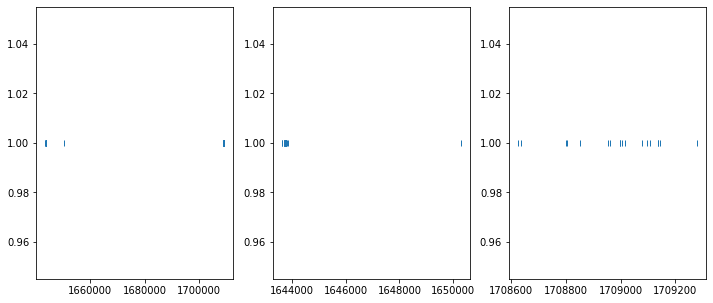

In [295]:
x = [[1643602.7057537881, 1643614.7057537881, 1643682.7057537881, 1643692.7057537881, 1643696.8943224142, 1643702.7057537881, 1643711.7057537881, 1643711.7057537881, 1643712.8943224142, 1643718.7057537881, 1643720.7057537881, 1643723.7057537881, 1643723.7057537881, 1643724.289005529, 1643724.7057537881, 1643728.7057537881, 1643728.7057537881, 1643728.7057537881, 1643728.7057537881, 1643728.7057537881, 1643728.7057537881, 1643728.7057537881, 1643728.7057537881, 1643728.7057537881, 1643728.7057537881, 1643728.7057537881, 1643728.7057537881, 1643728.7057537881, 1643728.7057537881, 1643728.7057537881, 1643728.7057537881, 1643728.7057537881, 1643728.7057537881, 1643728.7057537881, 1643728.7057537881, 1643728.7057537881, 1643728.7057537881, 1643728.7057537881, 1643729.7057537881, 1643729.7057537881, 1643729.7057537881, 1643730.7057537881, 1643730.7057537881, 1643731.7057537881, 1643732.7057537881, 1643733.7057537881, 1643733.7057537881, 1643733.7057537881, 1643733.7057537881, 1643734.7057537881, 1643736.7057537881, 1643737.8943224142, 1643738.7057537881, 1643738.7057537881, 1643738.7057537881, 1643738.7057537881, 1643738.7057537881, 1643738.7057537881, 1643738.7057537881, 1643738.7057537881, 1643738.7057537881, 1643738.7057537881, 1643738.7057537881, 1643738.7057537881, 1643738.7057537881, 1643738.7057537881, 1643738.7057537881, 1643738.7057537881, 1643738.7057537881, 1643738.7057537881, 1643738.7057537881, 1643738.7057537881, 1643738.7057537881, 1643738.7057537881, 1643738.7057537881, 1643738.7057537881, 1643738.7057537881, 1643738.7057537881, 1643738.7057537881, 1643738.7057537881, 1643738.7057537881, 1643738.7057537881, 1643738.7057537881, 1643739.7057537881, 1643739.7057537881, 1643740.7057537881, 1643740.7057537881, 1643741.7057537881, 1643741.7057537881, 1643741.7057537881, 1643743.7057537881, 1643744.7057537881, 1643745.7057537881, 1643746.7057537881, 1643746.7057537881, 1643747.7057537881, 1643748.7057537881, 1643748.7057537881, 1643748.7057537881, 1643751.289005529, 1643751.7057537881, 1643755.7057537881, 1643761.7057537881, 1643761.7057537881, 1643773.7057537881, 1643811.7057537881, 1643818.7057537881, 1650293.7057537881], {'607APD_0': 3, '339APD_0': 2, '1664APD_0': 1, '417APD_0': 1, '660APD_0': 1, '442APD_0': 1, '2328APD_0': 1, '234APD_0': 1, '47APD_0': 1, '52APD_0': 1, '558APD_0': 1, '901APD_0': 1, '370APD_1': 1, '1004APD_0': 1, '1961APD_0': 1, '22APD_0': 1, '292APD_0': 1, '1120APD_0': 1, '1178APD_0': 1, '1690APD_0': 1, '1810APD_0': 1, '203APD_0': 1, '2101APD_0': 1, '2165APD_0': 1, '2176APD_0': 1, '2371APD_0': 1, '2447APD_0': 1, '26APD_0': 1, '402APD_0': 1, '499APD_0': 1, '513APD_0': 1, '517APD_0': 1, '557APD_0': 1, '66APD_0': 1, '710APD_0': 1, '796APD_0': 1, '804APD_0': 1, '847APD_0': 1, '911APD_0': 1, '1028APD_0': 1, '252APD_0': 1, '419APD_0': 1, '2028APD_0': 1, '647APD_0': 1, '45APD_0': 1, '2374APD_0': 1, '107APD_0': 1, '1999APD_0': 1, '907APD_0': 1, '967APD_0': 1, '1419APD_0': 1, '815APD_0': 1, '8APD_0': 1, '1094APD_0': 1, '1095APD_0': 1, '111APD_0': 1, '1129APD_0': 1, '1294APD_0': 1, '1325APD_0': 1, '1372APD_0': 1, '1407APD_0': 1, '1426APD_0': 1, '1521APD_0': 1, '1606APD_0': 1, '162APD_0': 1, '1663APD_0': 1, '1697APD_0': 1, '1726APD_0': 1, '1801APD_0': 1, '1832APD_0': 1, '2010APD_0': 1, '2111APD_0': 1, '2129APD_0': 1, '2162APD_0': 1, '2201APD_0': 1, '2213APD_0': 1, '2251APD_0': 1, '250APD_0': 1, '264APD_0': 1, '453APD_0': 1, '489APD_0': 1, '60APD_0': 1, '678APD_0': 1, '956APD_0': 1, '1540APD_0': 1, '951APD_0': 1, '1257APD_0': 1, '643APD_0': 1, '108APD_0': 1, '1431APD_0': 1, '2303APD_0': 1, '1497APD_0': 1, '2462APD_0': 1, '1901APD_0': 1, '561APD_0': 1, '769APD_0': 1, '115APD_0': 1, '1548APD_0': 1, '2317APD_0': 1, '34APD_0': 1, '2078APD_0': 1, '2453APD_0': 1, '135APD_0': 1, '807APD_0': 1, '197APD_0': 1}, {0, 1}]
y = [[1708624.8943224142, 1708636.7057537881, 1708801.7057537881, 1708802.7057537881, 1708852.7057537881, 1708953.8943224142, 1708960.7057537881, 1708997.7057537881, 1708998.7057537881, 1709003.7057537881, 1709014.7057537881, 1709077.7057537881, 1709097.7057537881, 1709105.7057537881, 1709136.7057537881, 1709136.8943224142, 1709142.8943224142, 1709279.7057537881], {'558APD_0': 3, '419APD_0': 3, '1697APD_0': 3, '52APD_0': 3, '47APD_0': 3, '164APD_0': 1, '2328APD_0': 1, '2374APD_0': 1}, {1}]
#x[0] = [int(el) for el in x[0]]
a = x[0] + y[0]
plt.subplot(1,3,1)
plt.plot(a,[1]*len(a),'|')
plt.subplot(1,3,2)
plt.plot(x[0],[1]*len(x[0]),'|')
plt.subplot(1,3,3)
plt.plot(y[0],[1]*len(y[0]),'|')

In [299]:
extrahiere_daten([x[0][:-1],x[1],x[2]]),extrahiere_daten([x[0],x[1],x[2]]),

(Repeat(pos=1643738.7057537881, güte=29.161203594991427),
 Repeat(pos=1643738.7057537881, güte=0.057886370410580326))

In [10]:
len(ret.contig)

50

In [223]:
data = read_file('out1.lst')
data = connected(data)
position = {a for a,_,_ in data} | {b for _,b,_ in data}
contig_repeat = coll.defaultdict(list)
for contig in position:
    contig_repeat[contig_name(contig)].append(contig)

position = solve_LP(position, data)
write_file('data2.lst', data)
write_sol('sol2.lst', position)

Die Daten sind zusammenhängend
Optimize a model with 244438 rows, 124360 columns and 732398 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-06, 8e-06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 504 rows and 275 columns
Presolve time: 0.84s
Presolved: 243934 rows, 124085 columns, 731802 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1296
 AA' NZ     : 4.356e+06
 Factor NZ  : 6.686e+06 (roughly 200 MBytes of memory)
 Factor Ops : 9.544e+08 (less than 1 second per iteration)
 Threads    : 3

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.41867568e+05  3.24751553e+01  7.43e+05 0.00e+00  7.41e+04     3s
   1   7.52105164e+05 -2.58968972e+04  5.58e-10 1.01e-02  7.66e+03     3s
   2   7.52251730e+05  2.52776612e+02  5.86e-09 7

In [91]:
data = read_file('data1.lst','')
position, _ = read_position('sol1.lst',False)

In [49]:



def verbessere_loop(datei, out): 
    
    data = read_file(datei)
    data = connected(data)
    position = {a for a,_,_ in data} | {b for _,b,_ in data}
    contig_repeat = coll.defaultdict(list)
    for contig in position:
        contig_repeat[contig_name(contig)].append(contig)
        
    Ret = coll.namedtuple('Ret', ['contig','güte','g1','g2','fehler','pos','rep','data'])
    ret = []
    for i in range(50):
        position = solve_LP(position, data)
        print('max', max(position.values()))
        print('sortiere Bedingungen anderen repeats zu')
        
        fehler = umsortieren(data, contig_repeat, position)
        
        repeat, gruppe1, gruppe2, güte = get_repeat(fehler)
        
        contig = contig_name(repeat)
        new_contig = contig +'_'+ str(len(contig_repeat[contig]))
        contig_repeat[contig].append(new_contig)
        
        print('alter Wert', position[repeat])
        position[new_contig] = position[repeat] + gruppe2.median
        position[repeat] = position[repeat] + gruppe1.median
        
        print('neuer Wert', position[repeat])
        print('       und', position[new_contig])
        
        print('ordne neuem repeat zu: ' + new_contig)
        umsortieren(data, contig_repeat, position)
        
        print()
        print()
        #out = 'out' + str(i//10) + '.lst'
        write_file(out, data)
        #data = connected(data)
        ret.append(Ret(
            contig = contig,
            güte = güte,
            g1 = gruppe1,
            g2 = gruppe2,
            fehler = fehler,
            pos = position,
            rep = contig_repeat,
            data = data
        ))
    return ret
#position, data = verbessere_loop('my_apd200.lst', 'out.lst' )

ret = verbessere_loop('my_apd200.lst', 'test.lst' )




Es gibt unzusammenhängende Regionen in den Daten
99.86% der Contigs sind in der größten Komponente.
max 3035884.1259061797
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 0

güte 0.7587409414577064
gruppe1 Gruppe(min=-597.0, max=237.0, median=-41.0, std=114.46723557332075, anzahl=298, überdeckung=15)
gruppe2 Gruppe(min=22205.0, max=23067.0, median=22326.0, std=168.7310585231189, anzahl=186, überdeckung=12)
rest 14

alter Wert 314848.0
neuer Wert 314807.0
       und 337174.0
ordne neuem repeat zu: 157APD_1
Anzahl der Änderungen: 189



max 3036194.1259061797
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 0

güte 0.6888817430788796
gruppe1 Gruppe(min=-12562.0, max=-11401.137988218572, median=-11783.137988218572, std=207.0905131749324, anzahl=205, überdeckung=15)
gruppe2 Gruppe(min=-32.0, max=791.862011781428, median=323.0, std=141.754917642767, anzahl=203, überdeckung=14)
rest 9

alter Wert 1488047.7057537881
neuer Wert 1476264.5677655695
       und 1488370

Anzahl der Änderungen: 47



max 3036349.329249826
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 0

güte 0.18191963301504152
gruppe1 Gruppe(min=-1246.0, max=749.0, median=-1044.0, std=377.0445744037839, anzahl=116, überdeckung=15)
gruppe2 Gruppe(min=93445.0, max=94239.0, median=93647.0, std=138.0973590260852, anzahl=91, überdeckung=12)
rest 11

alter Wert 1070109.7057537881
neuer Wert 1069065.7057537881
       und 1163756.7057537881
ordne neuem repeat zu: 465APD_1
Anzahl der Änderungen: 100



max 3036296.077259682
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 0

güte 0.1394926392408755
gruppe1 Gruppe(min=-505.25199014367536, max=340.74800985632464, median=36.74800985632464, std=126.04766322825833, anzahl=138, überdeckung=17)
gruppe2 Gruppe(min=-2689.0, max=-2040.2519901436754, median=-2359.2519901436754, std=217.5268113835216, anzahl=54, überdeckung=13)
rest 3

alter Wert 1151279.7057537881
neuer Wert 1151316.4537636444
       und 1148920.4537636444
o

Anzahl der Änderungen: 10



max 3037627.705569294
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 9

güte 0.015723710781948584
gruppe1 Gruppe(min=-658.0, max=118.0, median=-158.0, std=205.24041889993654, anzahl=54, überdeckung=12)
gruppe2 Gruppe(min=22951.0, max=23551.079174810555, median=23384.63756949408, std=178.8464738400426, anzahl=26, überdeckung=4)
rest 5

alter Wert 2134320.7057537884
neuer Wert 2134162.7057537884
       und 2157705.3433232824
ordne neuem repeat zu: 214APD_1
Anzahl der Änderungen: 28



max 3037928.1259061797
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 0

güte 0.013870174380686745
gruppe1 Gruppe(min=-577.0, max=312.0, median=2.0, std=140.15225694512438, anzahl=159, überdeckung=15)
gruppe2 Gruppe(min=-8980.0, max=-7474.844819207559, median=-8252.84481920756, std=523.1929967903128, anzahl=39, überdeckung=6)
rest 25

alter Wert 581452.0
neuer Wert 581454.0
       und 573199.1551807924
ordne neuem repeat zu: 58APD_2
Anzahl der Änd

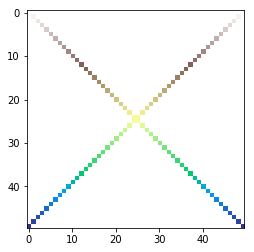

In [78]:
gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))
n = 50
l = [[0]*n for i in range(n)]
for i in range(n):
    l[i][i]=i
    l[i][n-i-1]=i
plt.imshow(l,cmap='terrain_r')
#plt.plot([1,2],[1,2],cmap='blues')

In [51]:
l=[1,2,1,4,2]

In [53]:

p1 = {'690APD_0': 474770.3142061554, '813APD_0': 1334640.0118184693, '1222APD_0': 2993061.853027273, '537APD_0': 2152815.408609131, '94APD_0': 632335.0, '1973APD_0': 2862854.3724931846, '1387APD_0': 796054.7354974365, '546APD_0': 16562.0, '510APD_0': 1497450.8197916918, '1838APD_0': 2094545.3294343206, '1749APD_0': 1325292.8197916918, '1078APD_0': 2974968.329249826, '1367APD_0': 2859056.329249826, '2322APD_0': 199810.0, '647APD_0': 1591118.3294343206, '1651APD_0': 657043.0, '1455APD_0': 2592003.2207858386, '1426APD_0': 1708421.3294343206, '1247APD_0': 760121.8810718309, '2349APD_0': 1498049.8197916918, '1773APD_0': 628018.0, '2081APD_0': 1491672.8319095878, '309APD_0': 2870248.329249826, '639APD_0': 906445.8976084167, '1975APD_0': 753338.1363622899, '1817APD_0': 1053964.8976084166, '1598APD_0': 2798119.329249826, '1142APD_0': 1031729.7057537881, '47APD_0': 1695894.3294343206, '1978APD_0': 1482419.8197916918, '2299APD_0': 2957216.4814396705, '1742APD_0': 1168351.7057537881, '548APD_0': 489227.0, '2350APD_0': 462656.0, '316APD_0': 1169439.7057537881, '803APD_0': 2413888.9090974345, '1689APD_0': 1419582.8197916918, '1720APD_0': 1454838.0118184693, '1974APD_0': 1152348.7057537881, '1002APD_0': 1378367.8197916918, '1508APD_0': 1465944.8197916918, '1218APD_0': 2940546.329249826, '1481APD_0': 49279.0, '1533APD_0': 2895294.4600826805, '2084APD_0': 2745412.760359616, '233APD_0': 2641035.2207858386, '2264APD_0': 1216603.7057537881, '1082APD_0': 2875026.329249826, '422APD_0': 1163975.7057537881, '1389APD_0': 1093410.8197916918, '1471APD_0': 1072962.7057537881, '1139APD_0': 2163149.5437996034, '72APD_0': 1150038.7057537881, '2296APD_0': 344724.0, '1409APD_0': 239330.0, '1993APD_0': 949085.7057537881, '1030APD_0': 1525675.8197916918, '2372APD_0': 2719891.432335437, '2340APD_0': 1065144.7057537881, '1294APD_0': 1721257.3294343206, '1910APD_0': 1379076.7164165329, '338APD_0': 1527423.3294343206, '1583APD_0': 1095711.5124780505, '1386APD_0': 1370038.8197916918, '1971APD_0': 900450.7057537881, '330APD_0': 2286658.3294343203, '2203APD_0': 1294769.0118184693, '749APD_0': 2220421.3294343203, '1964APD_0': 1500752.3294343206, '1312APD_0': 1192709.781569415, '1801APD_0': 1810890.3294343206, '2401APD_0': 3005115.329249826, '834APD_0': 1065682.7057537881, '1089APD_0': 1516148.5061755974, '780APD_0': 948887.3628282015, '979APD_0': 1958178.3294343206, '1238APD_0': 233660.5775405727, '1036APD_0': 1259131.3899821988, '1492APD_0': 1375598.7164165329, '2104APD_0': 1480287.3294343206, '2051APD_0': 1161381.0118184693, '386APD_0': 1449068.7057537881, '2375APD_0': 2161466.5437996034, '1556APD_0': 1390222.7164165329, '714APD_0': 505739.0, '2287APD_0': 1340617.8197916918, '1641APD_0': 1523447.0118184693, '515APD_0': 1356068.7164165329, '1011APD_0': 1129530.3756294472, '1573APD_0': 2190796.177505315, '2165APD_0': 1557348.3294343206, '2014APD_0': 3003582.7069775905, '430APD_0': 1087378.7057537881, '1095APD_0': 1814246.3294343206, '929APD_0': 942988.7057537881, '1361APD_0': 944867.7057537881, '317APD_0': 1482628.3294343206, '2173APD_0': 1115081.7057537881, '1393APD_0': 1285558.0118184693, '736APD_0': 1116251.2126798073, '1615APD_0': 2819093.325989038, '1566APD_0': 1268676.9161417962, '582APD_0': 2212971.408609131, '595APD_0': 1687076.2210647205, '370APD_0': 1701869.3294343206, '566APD_0': 856151.7057537881, '1300APD_0': 1228384.2707536456, '571APD_0': 232844.55799933852, '2234APD_0': 2361474.9090974345, '2038APD_0': 993689.8976084167, '1584APD_0': 1753731.3394080892, '2204APD_0': 495522.0, '2318APD_0': 1282099.7057537881, '457APD_0': 2139241.3294343203, '606APD_0': 2387320.988498952, '1544APD_0': 1108153.8976084166, '2339APD_0': 1078646.8976084166, '40APD_0': 1142555.8197916918, '2420APD_0': 633127.0, '500APD_0': 2187564.7774992906, '891APD_0': 1263448.7057537881, '64APD_0': 1158234.7057537881, '84APD_0': 1176591.7057537881, '819APD_0': 2701696.329249826, '1905APD_0': 2018117.3294343206, '2067APD_0': 2268211.9090974345, '917APD_0': 1028418.7057537881, '1165APD_0': 1358597.7057537881, '1633APD_0': 1464584.0118184693, '656APD_0': 514061.0, '1755APD_0': 1400813.7057537881, '2145APD_0': 1291720.0118184693, '939APD_0': 411458.0, '120APD_0': 1590444.5307268098, '1310APD_0': 2198430.465867169, '2195APD_0': 1122284.8197916918, '2313APD_0': 2442935.2500335188, '1930APD_0': 288665.0, '165APD_0': 2943244.329249826, '1687APD_0': 1459418.3294343206, '1025APD_0': 1406056.0118184693, '1045APD_0': 2002925.3294343206, '7APD_0': 2211793.408609131, '1350APD_0': 2928438.329249826, '356APD_0': 1286172.0118184693, '1434APD_0': 1256063.7057537881, '1099APD_0': 885392.7057537881, '1507APD_0': 737061.6136502073, '1692APD_0': 1075426.272997561, '1077APD_0': 404294.0, '26APD_0': 1626948.3294343206, '643APD_0': 1788014.3294343206, '944APD_0': 1105582.8976084166, '2394APD_0': 612503.1551807924, '1380APD_0': 220569.0, '429APD_0': 423663.0, '870APD_0': 2689701.3915556376, '2102APD_0': 1286614.7057537881, '2442APD_0': 2748490.329249826, '1493APD_0': 1881683.3294343206, '188APD_0': 1189842.0118184693, '920APD_0': 1420001.0118184693, '1997APD_0': 2985159.329249826, '628APD_0': 2712570.2207858386, '1314APD_0': 1439523.0118184693, '1207APD_0': 1063086.9225468065, '1587APD_0': 2723729.329249826, '10APD_0': 2193718.9670038144, '106APD_0': 444504.0, '2061APD_0': 2012539.3294343206, '176APD_0': 126342.0, '2453APD_0': 1761087.3294343206, '1515APD_0': 1345780.5209095492, '2200APD_0': 1073027.7057537881, '1097APD_0': 1101189.8976084166, '863APD_0': 1806833.6911094887, '547APD_0': 280046.0, '2159APD_0': 1413947.8197916918, '1412APD_0': 1273859.7057537881, '1966APD_0': 313611.0, '874APD_0': 401432.0, '1321APD_0': 1290539.0118184693, '147APD_0': 1505484.8197916918, '69APD_0': 616118.1551807924, '605APD_0': 1323099.7057537881, '1586APD_0': 325385.0, '1955APD_0': 295588.0, '2190APD_0': 1062669.8976084166, '2461APD_0': 454900.0, '1504APD_0': 2949794.329249826, '1003APD_0': 1389975.8197916918, '762APD_0': 2870844.329249826, '987APD_0': 2427152.026368894, '888APD_0': 1026450.7057537881, '949APD_0': 1530022.3294343206, '2278APD_0': 1175969.8197916918, '1528APD_0': 1374036.0118184693, '1907APD_0': 49027.85705787707, '1241APD_0': 1249937.136440603, '793APD_0': 227447.0, '1998APD_0': 1410538.7057537881, '2068APD_0': 402220.0, '1289APD_0': 752139.8810718309, '1448APD_0': 1121582.7057537881, '2239APD_0': 1475687.8385819546, '577APD_0': 19154.0, '710APD_0': 1567966.3294343206, '523APD_0': 1058094.8197916918, '241APD_0': 332590.0, '1267APD_0': 2876769.4600826805, '1276APD_0': 1282797.7057537881, '410APD_0': 1082480.8976084166, '1886APD_0': 1294238.0118184693, '604APD_0': 881671.7057537881, '392APD_0': 1489516.3294343206, '2006APD_0': 1464176.3294343206, '617APD_0': 1469572.3294343206, '357APD_0': 1513816.1744063331, '122APD_0': 2918867.329249826, '236APD_0': 2158098.408609131, '2022APD_0': 238930.0, '1686APD_0': 2770610.329249826, '1084APD_0': 1352336.0118184693, '666APD_0': 1504423.0081266987, '484APD_0': 1230637.7057537881, '264APD_0': 1754173.3294343206, '2415APD_0': 494578.0, '4APD_0': 1416283.7164165329, '1520APD_0': 1490566.312507351, '511APD_0': 152161.0, '855APD_0': 279109.0, '312APD_0': 1485577.0118184693, '1946APD_0': 1185925.0118184693, '1138APD_0': 2902891.329249826, '1033APD_0': 803545.0306679717, '1034APD_0': 1475665.3294343206, '2390APD_0': 427456.0, '242APD_0': 288519.40282005194, '1985APD_0': 2559830.1146327583, '2293APD_0': 1277121.0118184693, '1130APD_0': 2305989.3294343203, '1502APD_0': 928308.7057537881, '51APD_0': 1237612.7057537881, '2187APD_0': 1217242.0118184693, '983APD_0': 1214123.7057537881, '1887APD_0': 2470949.9090974345, '576APD_0': 1160347.7057537881, '87APD_0': 2879522.329249826, '973APD_0': 875825.7057537881, '158APD_0': 779137.2160942999, '1600APD_0': 1436918.0118184693, '52APD_0': 1695242.3294343206, '2244APD_0': 1230562.7057537881, '2059APD_0': 1391829.0984096604, '1070APD_0': 2904675.329249826, '806APD_0': 862248.0306679717, '96APD_0': 912561.4639847967, '1670APD_0': 2735026.107612337, '1148APD_0': 1521264.0118184693, '650APD_0': 1148842.7057537881, '2345APD_0': 0.0, '487APD_0': 1477323.3294343206, '951APD_0': 1812638.3294343206, '610APD_0': 1407886.8197916918, '1453APD_0': 1035683.8976084166, '1693APD_0': 1143634.8197916918, '732APD_0': 1469133.3294343206, '1890APD_0': 1444744.3294343206, '2127APD_0': 2823125.329249826, '1709APD_0': 1468167.3294343206, '1819APD_0': 1267674.0118184693, '1542APD_0': 2305868.048773004, '1977APD_0': 1534520.1744063331, '1733APD_0': 1218876.0118184693, '291APD_0': 1153383.7057537881, '734APD_0': 2731687.760359616, '2176APD_0': 1553947.3294343206, '1366APD_0': 656507.0, '1427APD_0': 1089577.7057537881, '1925APD_0': 1331993.0118184693, '572APD_0': 673552.0, '1748APD_0': 1070133.7057537881, '882APD_0': 1311607.0118184693, '234APD_0': 1724994.3294343206, '1620APD_0': 987506.7057537881, '2230APD_0': 794985.6346076817, '2330APD_0': 995966.7057537881, '390APD_0': 1125039.7057537881, '1792APD_0': 2702117.329249826, '2060APD_0': 1177427.7057537881, '1100APD_0': 2993470.329249826, '905APD_0': 1923650.3294343206, '1203APD_0': 2426342.9090974345, '686APD_0': 1430164.7057537881, '2268APD_0': 1533610.3294343206, '2434APD_0': 453351.0, '189APD_0': 560180.0, '369APD_0': 1161041.7057537881, '744APD_0': 1159133.7057537881, '950APD_0': 762189.1363622899, '779APD_0': 1100142.6588275444, '2092APD_0': 440033.1452148856, '2421APD_0': 1438155.7057537881, '894APD_0': 1320435.8197916918, '1230APD_0': 1454821.3294343206, '287APD_0': 962036.7057537881, '509APD_0': 1045493.7057537881, '15APD_0': 1081027.7057537881, '846APD_0': 1462326.0118184693, '2008APD_0': 3001985.5321363267, '65APD_0': 1957523.49329238, '2050APD_0': 95264.0, '1274APD_0': 697546.5596176438, '1602APD_0': 1267841.7057537881, '2245APD_0': 2788597.329249826, '1113APD_0': 99790.0, '2130APD_0': 2769139.2147307247, '1328APD_0': 1889504.3294343206, '1120APD_0': 1555149.3294343206, '1376APD_0': 2832612.329249826, '159APD_0': 1073121.7057537881, '705APD_0': 2901498.329249826, '1634APD_0': 1283907.8197916918, '1126APD_0': 1403020.7057537881, '268APD_0': 1838238.3294343206, '42APD_0': 2860329.329249826, '528APD_0': 834003.7057537881, '1322APD_0': 1370939.8983589306, '1787APD_0': 2796018.329249826, '341APD_0': 2695560.2207858386, '789APD_0': 287264.0, '13APD_0': 2868614.329249826, '723APD_0': 2823714.329249826, '1803APD_0': 1233676.7057537881, '1848APD_0': 2844779.329249826, '841APD_0': 2820135.329249826, '520APD_0': 1701222.8775478555, '868APD_0': 2173997.408609131, '1356APD_0': 1380644.1447044867, '1264APD_0': 1225600.7057537881, '1827APD_0': 1275925.0118184693, '275APD_0': 1162554.7057537881, '45APD_0': 1572244.3294343206, '2399APD_0': 1214402.8197916918, '499APD_0': 1614048.3294343206, '849APD_0': 1061471.7057537881, '473APD_0': 2177835.3294343203, '1406APD_0': 1397120.8197916918, '1032APD_0': 2519858.9090974345, '2325APD_0': 1481169.3294343206, '1840APD_0': 1696605.996635559, '1889APD_0': 331252.0, '552APD_0': 2281080.3294343203, '1451APD_0': 1541493.1744063331, '375APD_0': 2577027.2207858386, '507APD_0': 1924744.3518771727, '540APD_0': 1336893.7057537881, '1425APD_0': 1510586.734326541, '801APD_0': 2462025.9090974345, '63APD_0': 1018560.7057537881, '782APD_0': 1505319.3294343206, '802APD_0': 913662.8976084167, '1369APD_0': 1140256.8197916918, '1121APD_0': 1050465.5005199583, '1927APD_0': 1264123.7057537881, '441APD_0': 1367644.8197916918, '2005APD_0': 1534097.3294343206, '1157APD_0': 1222659.0118184693, '203APD_0': 1550805.3294343206, '1776APD_0': 1292641.0118184693, '2041APD_0': 3000816.329249826, '420APD_0': 1894580.3294343206, '1868APD_0': 2789720.329249826, '685APD_0': 2734713.7447148315, '2047APD_0': 1328537.7057537881, '1784APD_0': 2081929.3294343206, '2027APD_0': 1435317.7057537881, '2445APD_0': 3020455.329249826, '1981APD_0': 375192.0, '354APD_0': 1566944.0734229654, '980APD_0': 1066812.8976084166, '1347APD_0': 1175749.0118184693, '1015APD_0': 1150920.7057537881, '777APD_0': 1479216.8197916918, '2054APD_0': 1569470.9397334687, '1757APD_0': 2869881.329249826, '729APD_0': 2815258.329249826, '1140APD_0': 1243010.3899821988, '2328APD_0': 1675918.3294343206, '1666APD_0': 2270097.9090974345, '961APD_0': 1567188.4420140143, '1898APD_0': 2956651.984583513, '440APD_0': 1131474.7057537881, '658APD_0': 1152291.7057537881, '328APD_0': 1269666.7057537881, '138APD_0': 1517924.0118184693, '383APD_0': 1697600.8726776082, '92APD_0': 1848963.3294343206, '2082APD_0': 1265757.7057537881, '2197APD_0': 251245.0, '2276APD_0': 3002348.542098777, '893APD_0': 2887147.329249826, '136APD_0': 1204599.7057537881, '151APD_0': 529483.0, '1363APD_0': 219787.0, '633APD_0': 1144975.7057537881, '909APD_0': 1138269.7057537881, '1704APD_0': 1127747.8197916918, '820APD_0': 818889.0306679717, '1160APD_0': 1115775.7057537881, '438APD_0': 781317.2613832409, '244APD_0': 1110202.5055182567, '462APD_0': 614254.0, '2355APD_0': 2748193.329249826, '1570APD_0': 1228835.0118184693, '1416APD_0': 1294871.7057537881, '2429APD_0': 1158706.0118184693, '2396APD_0': 90730.0, '1833APD_0': 1251633.9473149308, '1430APD_0': 1161583.7057537881, '2368APD_0': 1109438.8976084166, '1227APD_0': 1449884.0118184693, '2010APD_0': 1792531.3294343206, '607APD_0': 1637262.3294343206, '1499APD_0': 1383641.0118184693, '592APD_0': 2924711.329249826, '2202APD_0': 1034909.7057537881, '2169APD_0': 1126171.7057537881, '175APD_0': 2651313.2207858386, '2255APD_0': 1261225.0118184693, '2232APD_0': 2169972.408609131, '2033APD_0': 2193104.9670038144, '1731APD_0': 2217280.1416079253, '1131APD_0': 1375030.7164165329, '1176APD_0': 1220042.0118184693, '1568APD_0': 1063164.8976084166, '965APD_0': 2421517.9090974345, '1769APD_0': 1177331.7057537881, '1133APD_0': 2315058.9090974345, '508APD_0': 2125444.3294343203, '513APD_0': 1550164.3294343206, '862APD_0': 1087859.7057537881, '377APD_0': 1578000.7834904576, '245APD_0': 2117472.3294343203, '2167APD_0': 1856487.3294343206, '78APD_0': 1082623.7057537881, '258APD_0': 1135544.7057537881, '30APD_0': 1518087.1374598644, '209APD_0': 34279.0, '1796APD_0': 1309241.7057537881, '223APD_0': 3035126.329249826, '2412APD_0': 1039167.8976084166, '1652APD_0': 2916079.329249826, '224APD_0': 737486.1363622899, '1123APD_0': 1890549.3294343206, '1967APD_0': 383385.0, '2329APD_0': 3024318.329249826, '324APD_0': 935370.7057537881, '1132APD_0': 1310403.0118184693, '2140APD_0': 1475870.0118184693, '14APD_0': 1183512.7057537881, '1235APD_0': 2885752.329249826, '1535APD_0': 1233780.0118184693, '1682APD_0': 1325518.7057537881, '283APD_0': 1362648.7164165329, '1420APD_0': 1129589.7057537881, '1790APD_0': 1596163.285823133, '1365APD_0': 2932391.329249826, '1750APD_0': 1276063.7057537881, '1918APD_0': 2932758.329249826, '1640APD_0': 1093845.7057537881, '2184APD_0': 930870.7057537881, '910APD_0': 940282.7057537881, '2392APD_0': 2762819.7894763006, '1785APD_0': 1099126.8976084166, '401APD_0': 2147021.3294343203, '479APD_0': 2342377.9090974345, '2063APD_0': 2925148.329249826, '313APD_0': 999091.7057537881, '2132APD_0': 1510883.3294343206, '1278APD_0': 1216963.7057537881, '2037APD_0': 1484611.1744063331, '2226APD_0': 1007868.7057537881, '971APD_0': 2720058.2207858386, '1645APD_0': 1505358.0118184693, '903APD_0': 1280367.7057537881, '2144APD_0': 2001271.3294343206, '1245APD_0': 624276.0, '792APD_0': 1284190.7057537881, '1696APD_0': 1316778.0118184693, '735APD_0': 377007.0, '1608APD_0': 250993.41992303627, '995APD_0': 796541.0306679717, '281APD_0': 1198442.1943612795, '558APD_0': 1677449.3294343206, '2348APD_0': 2953969.329249826, '1672APD_0': 364122.0, '29APD_0': 2911594.329249826, '444APD_0': 243895.0, '756APD_0': 858676.7057537881, '1150APD_0': 1562612.8197916918, '1894APD_0': 77630.0, '2298APD_0': 2961876.329249826, '1531APD_0': 1911385.3294343206, '261APD_0': 324538.5617431685, '2359APD_0': 1284215.0118184693, '1891APD_0': 1360361.7164165329, '396APD_0': 2699508.329249826, '1523APD_0': 790529.0306679717, '637APD_0': 2903245.329249826, '998APD_0': 32441.0, '1146APD_0': 836698.2019685869, '2178APD_0': 1150798.7057537881, '2260APD_0': 1991593.3294343206, '351APD_0': 1070823.8976084166, '1597APD_0': 1862285.3294343206, '742APD_0': 985994.8976084167, '851APD_0': 2265600.9090974345, '166APD_0': 2891739.329249826, '302APD_0': 2145959.3294343203, '555APD_0': 1263744.7057537881, '994APD_0': 1250789.8197916918, '1761APD_0': 1448615.7057537881, '956APD_0': 1809092.3294343206, '2088APD_0': 252553.0, '23APD_0': 1047976.8976084166, '2129APD_0': 1751761.3294343206, '486APD_0': 1138736.7057537881, '1888APD_0': 2901980.329249826, '1212APD_0': 2994247.329249826, '989APD_0': 440414.0, '2180APD_0': 1269275.395496215, '1339APD_0': 2465537.9090974345, '169APD_0': 2206653.408609131, '480APD_0': 268906.0, '82APD_0': 1450526.3805138937, '535APD_0': 1491021.7057537881, '288APD_0': 1965124.3294343206, '1345APD_0': 2896254.4600826805, '2100APD_0': 1219545.1208644544, '282APD_0': 1310443.7057537881, '1550APD_0': 2331619.9090974345, '551APD_0': 1019340.8976084167, '632APD_0': 2937651.329249826, '750APD_0': 1439209.2120338916, '1552APD_0': 1167458.0118184693, '256APD_0': 1942695.3294343206, '2424APD_0': 2446025.9090974345, '1928APD_0': 1215416.0118184693, '2248APD_0': 1572044.971595615, '1754APD_0': 1226787.7057537881, '3APD_0': 874473.8976084167, '2058APD_0': 149732.0, '1325APD_0': 1802567.3294343206, '1199APD_0': 437442.0, '625APD_0': 1902813.3294343206, '150APD_0': 1110836.7057537881, '445APD_0': 1152157.7057537881, '696APD_0': 2906323.329249826, '706APD_0': 935720.7057537881, '2249APD_0': 1116334.6549799587, '1400APD_0': 146145.0, '98APD_0': 400203.0, '1659APD_0': 2730402.760359616, '1735APD_0': 2416220.9090974345, '1575APD_0': 2903745.8736560447, '194APD_0': 2816435.329249826, '1631APD_0': 125092.0, '2198APD_0': 2507954.9090974345, '56APD_0': 2530715.9090974345, '1181APD_0': 1359094.8197916918, '88APD_0': 291890.0, '252APD_0': 1578239.3294343206, '101APD_0': 1407803.0118184693, '575APD_0': 1230075.7057537881, '67APD_0': 1221933.7057537881, '454APD_0': 1240491.7057537881, '2246APD_0': 2251825.9090974345, '2206APD_0': 1171028.0299785982, '1349APD_0': 979952.7057537881, '1454APD_0': 367546.0, '541APD_0': 2042598.3294343206, '1205APD_0': 977839.7057537881, '2450APD_0': 1533313.0118184693, '709APD_0': 1910164.3294343206, '1378APD_0': 2958882.329249826, '1391APD_0': 1124573.7057537881, '844APD_0': 1052591.7057537881, '353APD_0': 2608136.2207858386, '1333APD_0': 1292309.7057537881, '2030APD_0': 2555367.9090974345, '2215APD_0': 2419984.9090974345, '2021APD_0': 348167.0, '501APD_0': 1163255.7057537881, '2APD_0': 1288779.0118184693, '2000APD_0': 1566881.8197916918, '1932APD_0': 1585447.2298610169, '653APD_0': 724313.6136502073, '1058APD_0': 1559618.215527499, '1190APD_0': 1553287.3294343206, '2397APD_0': 2862230.329249826, '2373APD_0': 1542096.3294343206, '1488APD_0': 2205234.9670038144, '273APD_0': 1311302.7057537881, '668APD_0': 1504678.0118184693, '739APD_0': 752862.1363622899, '627APD_0': 597456.3472437494, '1191APD_0': 1296072.7057537881, '2441APD_0': 2484814.9090974345, '720APD_0': 1167247.822233614, '1172APD_0': 897689.7057537881, '1404APD_0': 1164033.8197916918, '1639APD_0': 1963956.3294343206, '1959APD_0': 1151657.7057537881, '746APD_0': 1495759.1144481148, '752APD_0': 1487552.1796658956, '521APD_0': 81173.0, '1860APD_0': 1193629.0118184693, '1676APD_0': 2900999.329249826, '1917APD_0': 1321125.7057537881, '922APD_0': 1053455.7057537881, '2147APD_0': 2208059.2305420446, '1285APD_0': 1156537.8197916918, '81APD_0': 2392909.9090974345, '678APD_0': 1714939.3294343206, '698APD_0': 1283291.5395215985, '1665APD_0': 475877.0, '544APD_0': 1119897.7057537881, '1064APD_0': 1162483.7057537881, '2162APD_0': 1780499.3294343206, '2418APD_0': 2535929.9090974345, '1783APD_0': 610545.1551807924, '11APD_0': 603945.1551807924, '1881APD_0': 1984568.3294343206, '2032APD_0': 372701.0, '2045APD_0': 2025168.3294343206, '2379APD_0': 1240697.0118184693, '988APD_0': 1303997.0118184693, '516APD_0': 1106777.9580743674, '2382APD_0': 557048.4458692747, '2275APD_0': 1011263.8976084167, '1000APD_0': 1078672.4543307594, '2259APD_0': 1048224.7057537881, '1296APD_0': 1176058.7057537881, '2243APD_0': 1082056.7057537881, '114APD_0': 2062064.3294343206, '39APD_0': 2375616.9090974345, '997APD_0': 2818185.7237752196, '2436APD_0': 1336093.7057537881, '1295APD_0': 1207245.7057537881, '2004APD_0': 1304239.7057537881, '2114APD_0': 1033693.8976084167, '892APD_0': 1149810.0118184693, '1049APD_0': 1146376.7057537881, '308APD_0': 1346356.0118184693, '2212APD_0': 1466317.8197916918, '799APD_0': 1113634.7057537881, '1541APD_0': 696999.8123248597, '1484APD_0': 2606108.2207858386, '1257APD_0': 1792001.3294343206, '1718APD_0': 2191392.408609131, '2209APD_0': 1489886.0118184693, '807APD_0': 1794566.3294343206, '426APD_0': 2222952.9090974345, '755APD_0': 1422786.8197916918, '1234APD_0': 1872228.3294343206, '216APD_0': 302442.0, '1067APD_0': 68179.0, '1774APD_0': 924792.9571538111, '1816APD_0': 478993.0, '1397APD_0': 233738.0, '2323APD_0': 1509755.8197916918, '425APD_0': 1893078.3294343206, '1401APD_0': 2768196.329249826, '1857APD_0': 183194.0, '719APD_0': 2793901.329249826, '12APD_0': 1125155.8976084166, '379APD_0': 406203.0, '1664APD_0': 1818500.3294343206, '345APD_0': 594004.0, '1842APD_0': 1482537.0118184693, '321APD_0': 2085258.3294343206, '519APD_0': 1337009.0118184693, '837APD_0': 2999564.329249826, '1286APD_0': 1493101.3294343206, '1662APD_0': 1566484.6622859652, '2214APD_0': 1171238.7057537881, '19APD_0': 190754.0, '2111APD_0': 1807925.3294343206, '74APD_0': 1476263.3294343206, '616APD_0': 953910.7057537881, '109APD_0': 1290854.0118184693, '1280APD_0': 789459.2613832409, '1885APD_0': 1146266.7057537881, '33APD_0': 2846782.329249826, '1940APD_0': 1760773.9917969939, '251APD_0': 1088533.8197916918, '482APD_0': 2463108.3433810845, '1394APD_0': 1276840.7057537881, '2222APD_0': 2949323.329249826, '1444APD_0': 1377812.7164165329, '1767APD_0': 819610.2613832409, '468APD_0': 2959557.329249826, '872APD_0': 2188290.408609131, '6APD_0': 1229744.0118184693, '1288APD_0': 1888493.3294343206, '1904APD_0': 212505.0, '588APD_0': 407901.0, '347APD_0': 1246950.0118184693, '1825APD_0': 1190878.0118184693, '542APD_0': 121102.0, '20APD_0': 1168234.7057537881, '1500APD_0': 615029.0, '419APD_0': 1687110.3294343206, '1253APD_0': 829213.0306679717, '804APD_0': 1568917.3294343206, '230APD_0': 1116837.7057537881, '996APD_0': 47832.0, '2314APD_0': 2557934.9090974345, '622APD_0': 1267032.7057537881, '1732APD_0': 896542.7057537881, '1059APD_0': 1080848.8976084166, '1661APD_0': 471907.0, '1649APD_0': 1248885.0118184693, '1519APD_0': 2807677.329249826, '1758APD_0': 2023044.3294343206, '609APD_0': 972243.8976084167, '1175APD_0': 2889087.329249826, '1736APD_0': 1268991.7057537881, '279APD_0': 1111074.8197916918, '2223APD_0': 1093941.8976084166, '2175APD_0': 2101892.5046131285, '2205APD_0': 576018.0, '307APD_0': 748605.0306679717, '1202APD_0': 1208320.7057537881, '1779APD_0': 218616.0, '50APD_0': 88716.0, '1275APD_0': 1483773.0118184693, '930APD_0': 1545178.3294343206, '2086APD_0': 1105578.7057537881, '829APD_0': 1199985.7057537881, '1512APD_0': 2879298.958601682, '1565APD_0': 1347535.7164165329, '451APD_0': 2540126.9090974345, '1852APD_0': 527488.0, '1821APD_0': 2761600.329249826, '1667APD_0': 2935000.329249826, '2080APD_0': 3036349.329249826, '2352APD_0': 2187144.408609131, '2451APD_0': 2285264.9090974345, '1582APD_0': 1050763.7057537881, '1375APD_0': 187010.0, '2225APD_0': 1062003.7057537881, '2085APD_0': 215207.0, '1262APD_0': 795552.2613832409, '329APD_0': 2709646.329249826, '522APD_0': 1042471.7057537881, '2280APD_0': 2992420.329249826, '1766APD_0': 2877990.329249826, '663APD_0': 2480405.9090974345, '1643APD_0': 2733303.760359616, '1348APD_0': 906736.7057537881, '2237APD_0': 850439.7057537881, '320APD_0': 1191586.0118184693, '584APD_0': 1163915.7057537881, '2309APD_0': 1882408.3294343206, '1668APD_0': 3032342.4634453445, '266APD_0': 407637.2620118739, '140APD_0': 1417539.7057537881, '2384APD_0': 1195347.7057537881, '2273APD_0': 2208751.2680001133, '2457APD_0': 2179699.6967190322, '2125APD_0': 311105.053188019, '464APD_0': 719661.0306679717, '1949APD_0': 1447658.3557582966, '1027APD_0': 1989984.3294343206, '1303APD_0': 1373723.7164165329, '990APD_0': 1327719.0118184693, '1446APD_0': 1433798.7057537881, '44APD_0': 597707.1551807924, '978APD_0': 542509.2833234861, '916APD_0': 759766.0371063963, '1970APD_0': 811810.0306679717, '860APD_0': 1867664.3294343206, '925APD_0': 2104120.3294343203, '212APD_0': 182832.0, '1828APD_0': 1495403.0946418976, '842APD_0': 1346490.7164165329, '1433APD_0': 414269.0, '1260APD_0': 2988100.329249826, '1043APD_0': 1231560.7057537881, '2211APD_0': 911156.8976084167, '358APD_0': 1082966.8976084166, '1690APD_0': 1585746.3294343206, '1984APD_0': 2727814.760359616, '1683APD_0': 1515510.3294343206, '549APD_0': 1473575.8197916918, '1630APD_0': 109440.95022688534, '436APD_0': 795409.5161756733, '2385APD_0': 2972246.329249826, '348APD_0': 1198816.7057537881, '318APD_0': 280428.0, '1813APD_0': 1153287.7057537881, '1658APD_0': 1708043.5553669212, '936APD_0': 1131779.8197916918, '2386APD_0': 1169443.7057537881, '688APD_0': 2078869.3294343206, '2196APD_0': 2193571.7718572905, '1171APD_0': 1234819.0118184693, '1945APD_0': 1122762.7057537881, '2112APD_0': 1057276.8976084166, '788APD_0': 1093021.8976084166, '2238APD_0': 1524735.3294343206, '1436APD_0': 1232434.0118184693, '2327APD_0': 925038.7057537881, '1540APD_0': 1777734.3294343206, '1717APD_0': 1293267.0118184693, '162APD_0': 1698104.3294343206, '48APD_0': 887484.8976084167, '926APD_0': 2469728.9090974345, '977APD_0': 2889641.329249826, '1926APD_0': 1194454.0118184693, '1922APD_0': 1274334.7057537881, '2141APD_0': 1219048.8197916918, '8APD_0': 1703878.3294343206, '1849APD_0': 2783832.329249826, '932APD_0': 1461803.3294343206, '2335APD_0': 483209.0, '365APD_0': 1114500.8197916918, '469APD_0': 2825105.329249826, '1074APD_0': 1221348.7057537881, '2236APD_0': 1112538.7057537881, '553APD_0': 1320161.5082657551, '144APD_0': 1539051.3294343206, '1445APD_0': 365771.0, '1419APD_0': 1573966.3294343206, '1551APD_0': 1497773.0118184693, '1457APD_0': 1297769.0118184693, '518APD_0': 1304585.0118184693, '269APD_0': 3035656.9281392316, '1128APD_0': 1246267.7057537881, '679APD_0': 2782589.329249826, '1472APD_0': 141201.0, '1933APD_0': 1119033.1859867244, '1791APD_0': 2473229.9090974345, '1284APD_0': 1162120.7057537881, '177APD_0': 1533635.0118184693, '1878APD_0': 1091950.8976084166, '651APD_0': 2104741.7190395547, '952APD_0': 2680077.2207858386, '1248APD_0': 330568.0, '90APD_0': 463024.0, '2072APD_0': 2953687.329249826, '292APD_0': 1736116.3294343206, '1324APD_0': 2189573.6257983637, '1371APD_0': 2209477.3705918323, '2133APD_0': 3005454.329249826, '156APD_0': 188042.0, '298APD_0': 2162071.408609131, '424APD_0': 936106.7057537881, '388APD_0': 2310373.9090974345, '957APD_0': 2934466.329249826, '654APD_0': 1107796.8028230637, '660APD_0': 1829094.3294343206, '387APD_0': 2956639.8446362643, '2409APD_0': 1252735.0118184693, '661APD_0': 2056501.936591957, '564APD_0': 1434860.8197916918, '2414APD_0': 1701522.05177608, '1116APD_0': 1219836.7057537881, '1147APD_0': 1034549.9365810602, '270APD_0': 1573782.4260460748, '1897APD_0': 2048166.3294343206, '1647APD_0': 414658.0, '1186APD_0': 2935657.329249826, '2142APD_0': 1116747.8976084166, '1465APD_0': 225062.0, '1876APD_0': 1468226.0118184693, '427APD_0': 2895638.329249826, '970APD_0': 1178124.7057537881, '594APD_0': 3006146.329249826, '1902APD_0': 974818.7057537881, '1702APD_0': 1461279.4515576344, '1421APD_0': 865971.6327372344, '172APD_0': 1415300.7164165329, '1054APD_0': 1080388.8976084166, '1173APD_0': 1456597.3294343206, '2153APD_0': 1484465.0118184693, '59APD_0': 114643.0, '112APD_0': 1896423.3294343206, '497APD_0': 718051.0306679717, '1474APD_0': 720409.0306679717, '2056APD_0': 1537948.1744063331, '1747APD_0': 1294096.7057537881, '2438APD_0': 1014931.7057537881, '1091APD_0': 929589.7057537881, '446APD_0': 2962722.329249826, '921APD_0': 367908.0, '217APD_0': 1177678.0118184693, '1497APD_0': 1671411.3294343206, '1623APD_0': 1432306.7057537881, '1899APD_0': 2020265.3294343206, '121APD_0': 924619.2927104736, '79APD_0': 1398682.0118184693, '878APD_0': 1551605.8197916918, '128APD_0': 796026.739531374, '163APD_0': 1816469.3294343206, '2199APD_0': 1544458.3294343206, '2055APD_0': 887023.6327372344, '1096APD_0': 1127284.8197916918, '198APD_0': 1194342.7057537881, '2043APD_0': 1163092.7057537881, '1189APD_0': 1441359.0118184693, '310APD_0': 2534274.9090974345, '963APD_0': 1497842.9775344722, '2378APD_0': 1156476.0118184693, '1282APD_0': 1283944.776765961, '1915APD_0': 1287501.7057537881, '2155APD_0': 683505.0, '2398APD_0': 1194863.0118184693, '325APD_0': 1100712.8197916918, '912APD_0': 2312885.9090974345, '193APD_0': 821843.6425024942, '2341APD_0': 1186034.7057537881, '2052APD_0': 749992.1363622899, '1538APD_0': 801180.2613832409, '885APD_0': 235289.0, '95APD_0': 1698981.584943059, '2251APD_0': 1788606.3294343206, '1850APD_0': 381487.0, '2346APD_0': 1498837.0118184693, '1351APD_0': 1303474.0118184693, '1246APD_0': 271913.0, '185APD_0': 1479220.0118184693, '691APD_0': 1595666.285823133, '506APD_0': 264190.0, '1963APD_0': 2788158.329249826, '1442APD_0': 1392007.7164165329, '794APD_0': 2883731.4600826805, '1877APD_0': 106582.0, '649APD_0': 1936610.3294343206, '432APD_0': 1118282.7057537881, '1893APD_0': 1058427.8976084166, '981APD_0': 1407703.7057537881, '958APD_0': 93440.0, '1006APD_0': 1479827.8197916918, '832APD_0': 327870.0, '1707APD_0': 1327868.6368697844, '1213APD_0': 1467004.0118184693, '1388APD_0': 1289052.7332836485, '1874APD_0': 1141777.7057537881, '796APD_0': 1567494.3294343206, '1626APD_0': 298496.47863426106, '1405APD_0': 1056021.8197916918, '2091APD_0': 1138779.7057537881, '1706APD_0': 1297523.7057537881, '1751APD_0': 484276.0, '2347APD_0': 2389511.9090974345, '1489APD_0': 2536995.9090974345, '405APD_0': 1074745.7057537881, '1628APD_0': 2269849.0935211442, '835APD_0': 1161899.0118184693, '2370APD_0': 1310546.7057537881, '489APD_0': 1806114.3294343206, '1490APD_0': 1998309.3294343206, '740APD_0': 380093.0, '1094APD_0': 1787539.3294343206, '1789APD_0': 1099679.8976084166, '1460APD_0': 841686.0306679717, '374APD_0': 244342.0, '2009APD_0': 1350124.7496583522, '443APD_0': 2496816.9090974345, '1073APD_0': 940258.8976084167, '703APD_0': 638872.0, '743APD_0': 1550748.8197916918, '211APD_0': 1118186.7057537881, '538APD_0': 2773754.329249826, '237APD_0': 1328325.9490210942, '1259APD_0': 1136133.7057537881, '35APD_0': 359156.0, '452APD_0': 761035.0306679717, '371APD_0': 1207802.7057537881, '1729APD_0': 695434.0306679717, '202APD_0': 461728.0, '1780APD_0': 2800988.329249826, '164APD_0': 1699086.8678978807, '1590APD_0': 329170.0, '413APD_0': 614457.4332121558, '1461APD_0': 1517869.7386806812, '2269APD_0': 1375212.8197916918, '301APD_0': 86677.0, '1483APD_0': 6671.0, '1700APD_0': 2197805.9670038144, '527APD_0': 1182426.0118184693, '1560APD_0': 1077357.6288099715, '800APD_0': 232612.48725806092, '785APD_0': 1332376.7496583522, '450APD_0': 2750536.329249826, '657APD_0': 2948955.329249826, '1080APD_0': 2041804.3294343206, '1605APD_0': 1493801.0118184693, '2304APD_0': 3008404.329249826, '117APD_0': 897607.8976084167, '1076APD_0': 83511.0, '1545APD_0': 1260046.7057537881, '200APD_0': 1921214.3294343206, '590APD_0': 1320610.0118184693, '2317APD_0': 1798678.3294343206, '2387APD_0': 164218.0, '1458APD_0': 1295969.0118184693, '1346APD_0': 1438114.8197916918, '1862APD_0': 1396803.0118184693, '557APD_0': 1576448.3294343206, '1768APD_0': 1150718.2550698596, '722APD_0': 1365503.8197916918, '262APD_0': 2336737.9090974345, '534APD_0': 1507768.3294343206, '195APD_0': 1086791.8976084166, '496APD_0': 2221739.3294343203, '828APD_0': 1900832.3294343206, '485APD_0': 1219764.8197916918, '798APD_0': 1502624.3294343206, '1174APD_0': 1245406.0118184693, '1644APD_0': 1515830.8197916918, '778APD_0': 1313933.0118184693, '1298APD_0': 2169352.408609131, '417APD_0': 1822369.3294343206, '412APD_0': 1840832.3294343206, '68APD_0': 426965.0, '456APD_0': 1518802.3294343206, '1948APD_0': 1203923.7057537881, '1654APD_0': 1550703.2086133424, '1031APD_0': 1337558.0118184693, '1056APD_0': 2809018.329249826, '17APD_0': 1038839.1033628768, '877APD_0': 1012850.8976084167, '1179APD_0': 1425696.7520416158, '814APD_0': 1516797.0118184693, '665APD_0': 1576050.3570458398, '938APD_0': 2986853.329249826, '2288APD_0': 2095768.7469458352, '708APD_0': 689216.0, '624APD_0': 1472553.0118184693, '859APD_0': 1402804.8197916918, '751APD_0': 1175346.7057537881, '1882APD_0': 1464947.3294343206, '1061APD_0': 2091070.3294343206, '2271APD_0': 1504089.3294343206, '2182APD_0': 1490535.1744063331, '246APD_0': 1188817.7057537881, '1224APD_0': 1140737.7057537881, '1753APD_0': 785118.0306679717, '28APD_0': 1472732.3294343206, '143APD_0': 1178184.7057537881, '741APD_0': 1385111.7164165329, '1992APD_0': 1357976.443996336, '2015APD_0': 1075639.8976084166, '1942APD_0': 324698.0, '1178APD_0': 1546010.3294343206, '1574APD_0': 439297.0, '2426APD_0': 1081158.8976084166, '1705APD_0': 2981076.329249826, '2053APD_0': 1319469.7057537881, '411APD_0': 1163211.7057537881, '887APD_0': 1181000.7057537881, '1013APD_0': 1624205.3849447158, '1968APD_0': 1517833.1744063331, '911APD_0': 1633261.3294343206, '334APD_0': 892622.7719453977, '1429APD_0': 2093765.3294343206, '852APD_0': 1356390.7057537881, '1319APD_0': 1582603.131633697, '414APD_0': 1111700.8976084166, '2456APD_0': 2997765.329249826, '142APD_0': 1111480.7057537881, '940APD_0': 2256770.9090974345, '1072APD_0': 1465938.3294343206, '1418APD_0': 2198955.408609131, '2137APD_0': 2206275.1788061596, '2305APD_0': 1346674.0118184693, '1529APD_0': 138347.0, '1812APD_0': 1373580.8197916918, '536APD_0': 1496236.0118184693, '2383APD_0': 2893874.329249826, '1786APD_0': 2996050.329249826, '636APD_0': 2756033.329249826, '1334APD_0': 272886.0, '1117APD_0': 1394738.0118184693, '1240APD_0': 1336839.8197916918, '407APD_0': 610750.0, '37APD_0': 596402.1551807924, '161APD_0': 1926571.3294343206, '280APD_0': 1542514.8197916918, '570APD_0': 2522548.9090974345, '771APD_0': 1198000.8624128262, '962APD_0': 1884224.3294343206, '908APD_0': 321508.2193785675, '1149APD_0': 1427196.7520416158, '1452APD_0': 1493910.3294343206, '927APD_0': 1111999.8197916918, '1360APD_0': 832234.1051953278, '494APD_0': 1208949.8197916918, '1364APD_0': 2508920.9090974345, '1595APD_0': 426081.0, '1048APD_0': 1030591.8976084167, '1934APD_0': 1435930.1796658956, '652APD_0': 1281802.661052466, '1503APD_0': 1568719.8197916918, '1317APD_0': 165838.0, '645APD_0': 1130903.2945060239, '724APD_0': 1282245.7057537881, '2157APD_0': 1532189.8197916918, '613APD_0': 2022886.939982616, '1636APD_0': 826007.2613832409, '2301APD_0': 1120952.7057537881, '160APD_0': 2168621.3294343203, '1396APD_0': 1165633.7057537881, '676APD_0': 1519901.1744063331, '433APD_0': 1072714.600946341, '585APD_0': 2443407.3129672185, '1691APD_0': 760362.0306679717, '134APD_0': 692129.0, '907APD_0': 1636335.3294343206, '517APD_0': 1561857.3294343206, '763APD_0': 1403396.7164165329, '1441APD_0': 1330632.8197916918, '759APD_0': 1187358.0118184693, '1214APD_0': 1589101.3294343206, '1660APD_0': 2957501.329249826, '619APD_0': 983278.7057537881, '815APD_0': 1595015.3294343206, '1572APD_0': 1215533.8197916918, '1272APD_0': 1353983.0118184693, '146APD_0': 2680368.2207858386, '86APD_0': 131682.0, '2002APD_0': 1353673.0118184693, '274APD_0': 1036420.7057537881, '2427APD_0': 1503469.3294343206, '890APD_0': 752542.3204160545, '1087APD_0': 2863865.329249826, '1723APD_0': 1344815.5209095492, '46APD_0': 2437682.9090974345, '1638APD_0': 2627468.2207858386, '1986APD_0': 357307.0, '640APD_0': 1139260.7057537881, '2277APD_0': 1368658.0118184693, '621APD_0': 1398321.7979376216, '286APD_0': 1509982.0118184693, '1730APD_0': 1115759.7057537881, '221APD_0': 1151076.7057537881, '671APD_0': 2903999.329249826, '2217APD_0': 1399116.7164165329, '623APD_0': 1067557.8976084166, '514APD_0': 2558746.9090974345, '672APD_0': 1130348.7057537881, '2297APD_0': 1564302.8197916918, '1764APD_0': 1325332.0118184693, '850APD_0': 355909.0, '1724APD_0': 1532864.5061755974, '608APD_0': 1498249.0118184693, '1261APD_0': 759052.0306679717, '2011APD_0': 405594.0, '1377APD_0': 2001623.3294343206, '2073APD_0': 1363075.8197916918, '361APD_0': 1252272.8197916918, '2228APD_0': 1570847.2039731299, '2103APD_0': 1474804.0118184693, '687APD_0': 2176785.3294343203, '1239APD_0': 1280434.7057537881, '1815APD_0': 573851.0, '948APD_0': 203680.0, '289APD_0': 1494214.3294343206, '1990APD_0': 1082091.7028024062, '187APD_0': 543340.0, '102APD_0': 956415.7057537881, '754APD_0': 1406735.7057537881, '2201APD_0': 1756649.3294343206, '1382APD_0': 2820587.329249826, '1183APD_0': 1485061.3294343206, '2452APD_0': 1397543.7057537881, '2433APD_0': 2701052.329249826, '693APD_0': 1836053.3294343206, '250APD_0': 1789329.3294343206, '960APD_0': 101709.0, '459APD_0': 553396.0, '2261APD_0': 556646.3407178883, '461APD_0': 911343.7057537881, '2110APD_0': 624619.0, '597APD_0': 697956.0, '1114APD_0': 1173081.7057537881, '2454APD_0': 971973.7057537881, '1908APD_0': 1322449.8197916918, '845APD_0': 697189.9599617386, '1336APD_0': 1314754.7057537881, '181APD_0': 1454132.3294343206, '1151APD_0': 206124.0, '848APD_0': 1447247.3557582966, '2279APD_0': 775296.2613832409, '2231APD_0': 1262962.7893629044, '2407APD_0': 1913269.3294343206, '1410APD_0': 523192.0, '776APD_0': 130387.0, '524APD_0': 813126.7057537881, '1028APD_0': 1632350.3294343206, '2095APD_0': 2856290.329249826, '372APD_0': 1634970.29522317, '2025APD_0': 2994152.0816396256, '2012APD_0': 2168910.408609131, '1355APD_0': 1430411.8197916918, '504APD_0': 1094509.7057537881, '467APD_0': 2505041.026368894, '2283APD_0': 2785785.329249826, '2049APD_0': 3030289.329249826, '249APD_0': 1182404.7057537881, '1802APD_0': 2197322.9670038144, '1845APD_0': 1213424.0118184693, '2057APD_0': 3002582.329249826, '1158APD_0': 1437621.1587087023, '1826APD_0': 1358229.0118184693, '600APD_0': 1262140.7057537881, '1496APD_0': 2190108.408609131, '1673APD_0': 2597056.7822523364, '297APD_0': 2214204.9670038144, '563APD_0': 1067989.7057537881, '895APD_0': 1289245.7057537881, '2403APD_0': 2221162.3294343203, '2062APD_0': 870295.6327372344, '1621APD_0': 314189.053188019, '2003APD_0': 233136.0, '1697APD_0': 1688052.3294343206, '1756APD_0': 1327123.9242672382, '1562APD_0': 1004875.7057537881, '253APD_0': 1239806.7057537881, '1182APD_0': 2089811.3294343206, '985APD_0': 2211107.9670038144, '680APD_0': 433073.0, '1699APD_0': 1068373.7057537881, '2177APD_0': 1325231.8997218995, '1335APD_0': 983728.8976084167, '1215APD_0': 3033535.329249826, '1599APD_0': 1259557.8197916918, '790APD_0': 2746593.760359616, '1614APD_0': 1362050.7164165329, '795APD_0': 1056345.7057537881, '2035APD_0': 2891173.329249826, '682APD_0': 282338.0, '111APD_0': 1813167.3294343206, '1991APD_0': 229632.0, '2247APD_0': 1113221.8976084166, '1988APD_0': 1924924.3294343206, '975APD_0': 1410238.8197916918, '1192APD_0': 418859.0, '1880APD_0': 1399840.8197916918, '758APD_0': 1100433.7332155397, '1818APD_0': 1119316.7057537881, '695APD_0': 2231152.3294343203, '2192APD_0': 898998.7057537881, '539APD_0': 1511337.3294343206, '947APD_0': 3020039.2449619723, '167APD_0': 737641.6136502073, '1438APD_0': 1635354.170360937, '1657APD_0': 1131238.7057537881, '129APD_0': 1832611.3294343206, '474APD_0': 2810126.329249826, '1APD_0': 615787.0, '2343APD_0': 2552057.9090974345, '826APD_0': 891900.7057537881, '1340APD_0': 2919601.329249826, '1646APD_0': 1458351.837187964, '1341APD_0': 749363.1363622899, '1143APD_0': 1234468.0118184693, '1228APD_0': 1405756.408473902, '174APD_0': 1542471.3294343206, '1851APD_0': 1142155.8197916918, '453APD_0': 1758453.3294343206, '376APD_0': 847054.0306679717, '2040APD_0': 778276.2613832409, '1470APD_0': 3028012.329249826, '475APD_0': 791088.2613832409, '213APD_0': 2491908.3129672185, '197APD_0': 1796441.3294343206, '1196APD_0': 1491375.3294343206, '1938APD_0': 808659.2613832409, '1679APD_0': 938812.8976084167, '2448APD_0': 80780.20626257994, '2422APD_0': 1194273.7057537881, '1923APD_0': 1125714.7057537881, '1865APD_0': 1458761.3294343206, '2029APD_0': 343103.3395792549, '1475APD_0': 1071719.7057537881, '100APD_0': 2233413.9090974345, '745APD_0': 1069545.8976084166, '1225APD_0': 1029092.7057537881, '1576APD_0': 2026204.3294343206, '1155APD_0': 1138450.8197916918, '210APD_0': 1308161.7057537881, '232APD_0': 1034769.8976084166, '1569APD_0': 1983949.3294343206, '919APD_0': 1176084.7057537881, '614APD_0': 2896708.329249826, '1811APD_0': 1160747.9899311431, '2371APD_0': 1588841.3294343206, '2174APD_0': 1045124.7057537881, '1521APD_0': 1807243.3294343206, '2332APD_0': 2078167.3294343206, '1919APD_0': 861640.7057537881, '470APD_0': 2525621.9090974345, '2262APD_0': 1387126.7057537881, '1408APD_0': 1235478.0118184693, '343APD_0': 1294481.7057537881, '1728APD_0': 2734445.613948364, '738APD_0': 1166802.0118184693, '149APD_0': 1509575.3540193068, '1374APD_0': 627647.1551807924, '1921APD_0': 222972.0, '2090APD_0': 2168674.0028704847, '1159APD_0': 978555.7057537881, '2118APD_0': 1128916.8197916918, '1534APD_0': 14973.0, '300APD_0': 1165269.8197916918, '2270APD_0': 2333795.9090974345, '133APD_0': 1258124.7057537881, '1498APD_0': 1540260.0822323835, '1001APD_0': 2179473.9670038144, '1354APD_0': 1527703.1744063331, '1510APD_0': 1170887.7057537881, '1920APD_0': 1139858.8197916918, '1038APD_0': 422569.0, '2020APD_0': 1404645.8197916918, '478APD_0': 1361350.0118184693, '2281APD_0': 2546783.9090974345, '2044APD_0': 1154170.0118184693, '1788APD_0': 1954799.3294343206, '1859APD_0': 2187213.3294343203, '1929APD_0': 1151586.7057537881, '1249APD_0': 961126.8496269198, '1567APD_0': 1983794.150520934, '1619APD_0': 2887014.149286912, '1629APD_0': 1177765.426996322, '2423APD_0': 452289.0, '2007APD_0': 1079776.7057537881, '1708APD_0': 995221.7057537881, '1625APD_0': 163724.2002441027, '697APD_0': 1301432.7057537881, '1057APD_0': 139031.0, '1316APD_0': 1102227.7057537881, '2240APD_0': 1890255.3294343206, '1281APD_0': 457608.0, '2369APD_0': 1274108.0118184693, '294APD_0': 2020886.3294343206, '1546APD_0': 1368181.7164165329, '2163APD_0': 1316618.7057537881, '116APD_0': 1110829.7057537881, '1372APD_0': 1765728.3294343206, '247APD_0': 2706668.2207858386, '730APD_0': 2818527.329249826, '884APD_0': 1339940.0118184693, '1594APD_0': 1899698.3294343206, '701APD_0': 1409607.7057537881, '1509APD_0': 2806546.329249826, '1162APD_0': 552608.0, '1715APD_0': 2403666.9090974345, '1650APD_0': 2691189.2207858386, '1941APD_0': 1298679.7057537881, '340APD_0': 1366957.0118184693, '774APD_0': 799030.2613832409, '53APD_0': 1151280.7057537881, '1169APD_0': 385856.0, '830APD_0': 1162321.9000448813, '394APD_0': 1076387.8197916918, '1265APD_0': 826797.0306679717, '1847APD_0': 1498023.3045744325, '265APD_0': 1051494.8976084166, '574APD_0': 2188616.3294343203, '631APD_0': 1171309.0118184693, '1185APD_0': 436825.0, '60APD_0': 1809989.3294343206, '2449APD_0': 1366947.7164165329, '333APD_0': 1401578.7164165329, '1830APD_0': 1057189.7057537881, '437APD_0': 2338500.9090974345, '148APD_0': 1152921.0118184693, '906APD_0': 203323.97134716003, '1106APD_0': 1388549.8042216357, '716APD_0': 1227627.0118184693, '208APD_0': 388116.0, '1211APD_0': 1159547.7057537881, '229APD_0': 1110591.8976084166, '115APD_0': 1763489.3294343206, '1022APD_0': 616990.1551807924, '784APD_0': 2752844.329249826, '900APD_0': 558518.0, '1804APD_0': 1045866.7057537881, '141APD_0': 1013349.7057537881, '1698APD_0': 157540.0, '565APD_0': 721330.0306679717, '1972APD_0': 2695917.2207858386, '1063APD_0': 1052118.8976084166, '670APD_0': 1079733.8976084166, '1726APD_0': 1801305.3294343206, '765APD_0': 1959524.3294343206, '898APD_0': 312344.0, '2266APD_0': 2480062.922684314, '1103APD_0': 1253416.0118184693, '352APD_0': 1263753.7057537881, '531APD_0': 1193318.7057537881, '2070APD_0': 1864256.3294343206, '2207APD_0': 2166080.408609131, '923APD_0': 2403085.653414445, '1547APD_0': 1145014.8197916918, '434APD_0': 2886190.329249826, '611APD_0': 1465371.3294343206, '409APD_0': 2763026.329249826, '483APD_0': 1157468.7057537881, '1953APD_0': 2923181.329249826, '1909APD_0': 1234951.7057537881, '118APD_0': 2900730.329249826, '1166APD_0': 2747229.329249826, '380APD_0': 1495688.8197916918, '1866APD_0': 246722.0, '2134APD_0': 706207.273135584, '2406APD_0': 805951.2613832409, '1456APD_0': 1268602.0118184693, '1200APD_0': 2894197.329249826, '2019APD_0': 1033024.9717444491, '2189APD_0': 914941.7057537881, '2185APD_0': 1676875.3294343206, '349APD_0': 2440393.9090974345, '1936APD_0': 2835028.329249826, '505APD_0': 2847331.329249826, '1557APD_0': 2875444.4600826805, '2310APD_0': 1482113.3294343206, '1392APD_0': 1499172.3294343206, '2105APD_0': 2802485.329249826, '2122APD_0': 322297.0, '339APD_0': 1714435.3294343206, '2065APD_0': 2821440.329249826, '1256APD_0': 1378663.0118184693, '659APD_0': 2863375.329249826, '1763APD_0': 2991284.303163306, '2306APD_0': 2869345.329249826, '896APD_0': 195290.0, '1806APD_0': 1697757.3505087725, '76APD_0': 1925487.3294343206, '2186APD_0': 2744835.329249826, '248APD_0': 2941543.8636337463, '1563APD_0': 936666.7057537881, '1807APD_0': 2994819.329249826, '113APD_0': 1132110.7057537881, '626APD_0': 1496169.3294343206, '1279APD_0': 1147625.7057537881, '2001APD_0': 1069266.5146189188, '1368APD_0': 1344809.8197916918, '721APD_0': 2277848.3294343203, '1226APD_0': 928683.7057537881, '182APD_0': 1157141.7057537881, '1398APD_0': 2152553.035249931, '1814APD_0': 866953.7057537881, '18APD_0': 1123931.7057537881, '1359APD_0': 1409957.7057537881, '1309APD_0': 474910.0, '618APD_0': 1077781.7057537881, '2267APD_0': 1272414.7057537881, '1102APD_0': 853816.2103412931, '2338APD_0': 1414269.7164165329, '2028APD_0': 1732523.3294343206, '1208APD_0': 1168999.8197916918, '1480APD_0': 145700.0, '1554APD_0': 1162947.7057537881, '36APD_0': 1252171.7057537881, '1462APD_0': 1512279.3294343206, '1231APD_0': 1348689.0118184693, '1327APD_0': 1261117.7057537881, '1437APD_0': 2809664.329249826, '1871APD_0': 890344.6327372344, '692APD_0': 1281410.7057537881, '1495APD_0': 1150287.7057537881, '363APD_0': 1280814.7057537881, '398APD_0': 1004963.8976084167, '498APD_0': 1080082.8197916918, '1164APD_0': 1305304.0118184693, '554APD_0': 1952073.3294343206, '2440APD_0': 1137949.5525174444, '1979APD_0': 921018.7057537881, '902APD_0': 1391718.8197916918, '1204APD_0': 965926.7057537881, '1476APD_0': 1757385.2240100652, '227APD_0': 826318.2613832409, '1467APD_0': 417516.0, '2128APD_0': 1169097.200224823, '1135APD_0': 1386683.7164165329, '2097APD_0': 1427995.3378776954, '733APD_0': 1237025.7057537881, '199APD_0': 1516787.8342279429, '1969APD_0': 1164366.7057537881, '769APD_0': 1758951.3294343206, '2356APD_0': 1129384.0672090335, '1685APD_0': 1039297.7057537881, '2432APD_0': 912826.7057537881, '1021APD_0': 1037292.2268827047, '2302APD_0': 2168503.878137835, '131APD_0': 1173798.7057537881, '296APD_0': 1431910.616185255, '1606APD_0': 1772619.3294343206, '5APD_0': 1920081.9606851996, '2374APD_0': 1701390.3294343206, '2319APD_0': 83131.0, '1578APD_0': 1438351.0118184693, '2413APD_0': 1099429.8197916918, '215APD_0': 2794604.329249826, '2191APD_0': 2822657.329249826, '359APD_0': 1446418.0118184693, '1050APD_0': 2871607.329249826, '1065APD_0': 1380946.9517962928, '1805APD_0': 1274469.7057537881, '201APD_0': 1189314.7057537881, '1939APD_0': 286237.0, '1781APD_0': 1414929.4965724342, '1711APD_0': 1209929.0118184693, '783APD_0': 965077.8976084167, '1759APD_0': 1300311.7057537881, '1522APD_0': 690749.0, '953APD_0': 2562184.2207858386, '1675APD_0': 385206.0, '2380APD_0': 297342.0, '2274APD_0': 1524236.3294343206, '2410APD_0': 645714.0, '573APD_0': 878620.8976084167, '1017APD_0': 239759.0, '567APD_0': 128517.0, '1487APD_0': 1406733.0118184693, '1115APD_0': 2717388.760359616, '967APD_0': 1597721.3294343206, '825APD_0': 3003029.329249826, '1746APD_0': 1298320.0118184693, '2233APD_0': 2000422.3294343206, '1463APD_0': 604644.0, '1422APD_0': 697641.491221523, '1616APD_0': 1517227.3294343206, '192APD_0': 1932468.3294343206, '1384APD_0': 2436761.9090974345, '655APD_0': 1083327.7057537881, '1079APD_0': 836994.7057537881, '2099APD_0': 1251381.0118184693, '1994APD_0': 2914624.4600826805, '704APD_0': 1415667.7164165329, '1112APD_0': 1304922.7057537881, '1954APD_0': 747943.1363622899, '525APD_0': 695013.0306679717, '1588APD_0': 1413196.7057537881, '766APD_0': 559356.0, '1042APD_0': 1341113.7057537881, '135APD_0': 1718138.3294343206, '1055APD_0': 892880.8976084167, '2326APD_0': 1232901.0118184693, '2460APD_0': 801441.0306679717, '1088APD_0': 1253792.0118184693, '2146APD_0': 2944898.329249826, '1473APD_0': 1388765.8197916918, '1950APD_0': 1866113.3294343206, '1156APD_0': 352635.8841639469, '1040APD_0': 1031492.9323167, '2250APD_0': 866282.0306679717, '753APD_0': 2827847.329249826, '1559APD_0': 2196751.408609131, '493APD_0': 2225172.9090974345, '1197APD_0': 1322770.0118184693, '1561APD_0': 2257312.9090974345, '1580APD_0': 1059630.8688285379, '125APD_0': 1203522.0118184693, '876APD_0': 226281.0, '1901APD_0': 1796055.3294343206, '748APD_0': 1174256.0118184693, '186APD_0': 1816181.9321744204, '447APD_0': 1305785.7057537881, '326APD_0': 1162838.7057537881, '512APD_0': 2111290.3294343203, '1188APD_0': 1854701.3294343206, '1014APD_0': 2919335.9636876704, '966APD_0': 1344968.7164165329, '1244APD_0': 1386119.9919027973, '817APD_0': 1427056.8197916918, '1684APD_0': 2700618.329249826, '1494APD_0': 326896.0, '1952APD_0': 1188887.7057537881, '556APD_0': 804448.2613832409, '1883APD_0': 1395461.8197916918, '684APD_0': 309217.0, '767APD_0': 2845827.329249826, '1581APD_0': 1527032.3294343206, '1896APD_0': 2431777.9090974345, '1836APD_0': 840000.7057537881, '1469APD_0': 2061360.3294343206, '465APD_0': 1069065.7057537881, '2036APD_0': 1063440.7057537881, '1090APD_0': 1384494.0118184693, '1823APD_0': 1430740.8197916918, '104APD_0': 1354848.0118184693, '1912APD_0': 1450803.3294343206, '2395APD_0': 1492769.8197916918, '869APD_0': 2141018.555164375, '707APD_0': 2943736.329249826, '416APD_0': 2183273.408609131, '93APD_0': 1411939.0118184693, '1024APD_0': 406617.0, '1110APD_0': 2560625.9090974345, '601APD_0': 282895.0, '1875APD_0': 2802970.329249826, '2367APD_0': 467950.0, '2101APD_0': 1582766.3294343206, '99APD_0': 1100849.0190169683, '1016APD_0': 1214084.7057537881, '1931APD_0': 2940366.141903093, '1145APD_0': 1035365.142282722, '1485APD_0': 1261641.0118184693, '1980APD_0': 92371.0, '545APD_0': 1282251.0118184693, '824APD_0': 1033717.7057537881, '897APD_0': 2725997.760359616, '2428APD_0': 1228642.7057537881, '350APD_0': 1332398.8197916918, '2108APD_0': 1276683.0118184693, '591APD_0': 1281268.1696119024, '1752APD_0': 1557582.8197916918, '55APD_0': 1221228.0118184693, '1961APD_0': 1635531.3294343206, '2018APD_0': 2209999.9670038144, '1330APD_0': 481286.0, '986APD_0': 352826.0, '1778APD_0': 1842330.3294343206, '2459APD_0': 1125750.7057537881, '702APD_0': 1343177.7164165329, '2300APD_0': 2710659.329249826, '1935APD_0': 1094446.8976084166, '1536APD_0': 1059960.7057537881, '303APD_0': 1078329.7057537881, '2219APD_0': 902841.7057537881, '982APD_0': 1160182.0118184693, '43APD_0': 2895935.329249826, '231APD_0': 1510070.7016681463, '1435APD_0': 1558911.296001396, '2324APD_0': 1138901.2738689925, '1242APD_0': 1437866.0118184693, '1373APD_0': 1017361.7057537881, '1491APD_0': 1412089.8197916918, '1648APD_0': 2217748.3294343203, '323APD_0': 2322711.9090974345, '945APD_0': 214549.0, '145APD_0': 1138228.7057537881, '1743APD_0': 2839009.329249826, '22APD_0': 1711818.3294343206, '914APD_0': 1888880.3294343206, '168APD_0': 1279423.0118184693, '1221APD_0': 1276166.7057537881, '764APD_0': 311530.0, '204APD_0': 1433365.7057537881, '638APD_0': 300840.0, '2083APD_0': 1092020.8197916918, '1771APD_0': 186675.8851913698, '2241APD_0': 2267186.9090974345, '184APD_0': 343756.0, '2337APD_0': 746041.6136502073, '2075APD_0': 614090.0, '1440APD_0': 1395828.8197916918, '73APD_0': 833046.0306679717, '1727APD_0': 2559939.9090974345, '821APD_0': 1247570.7057537881, '1447APD_0': 2497527.9090974345, '1066APD_0': 925537.7057537881, '2136APD_0': 2104862.269958325, '1268APD_0': 386589.0, '1911APD_0': 45639.702710173704, '2227APD_0': 1157904.0118184693, '1834APD_0': 2902578.329249826, '240APD_0': 1459341.8197916918, '781APD_0': 784118.0306679717, '1201APD_0': 1221030.7057537881, '75APD_0': 706378.0306679717, '589APD_0': 718756.1292405162, '2046APD_0': 1262633.3028373786, '1867APD_0': 1391370.0118184693, '2123APD_0': 1113112.7057537881, '1358APD_0': 1095351.8197916918, '1109APD_0': 2886674.329249826, '1252APD_0': 193824.0, '999APD_0': 1217035.8197916918, '2139APD_0': 1527898.3294343206, '1122APD_0': 785113.2613832409, '214APD_0': 2133000.3294343203, '2152APD_0': 1394847.7164165329, '1217APD_0': 1393032.7164165329, '853APD_0': 1115663.7057537881, '2031APD_0': 2800383.329249826, '21APD_0': 1366119.7164165329, '304APD_0': 2945212.8636337463, '946APD_0': 1300517.0118184693, '243APD_0': 1470093.3294343206, '1722APD_0': 1411111.7164165329, '1739APD_0': 1460294.3294343206, '2285APD_0': 1034580.4228198553, '2405APD_0': 2819352.329249826, '2447APD_0': 1571165.3294343206, '2295APD_0': 1907769.3294343206, '1439APD_0': 636270.0, '1831APD_0': 2209047.5071489885, '1085APD_0': 1476633.312507351, '2077APD_0': 921039.8976084167, '491APD_0': 614086.1551807924, '1263APD_0': 1168004.4459131265, '408APD_0': 1131221.8197916918, '381APD_0': 1349413.8197916918, '2444APD_0': 2593510.2207858386, '1943APD_0': 2056809.3294343206, '2116APD_0': 2463415.9090974345, '568APD_0': 804969.0306679717, '2256APD_0': 420986.0, '2331APD_0': 1110919.8976084166, '314APD_0': 1388588.0118184693, '831APD_0': 103345.0, '2066APD_0': 1154958.7057537881, '293APD_0': 2917866.329249826, '1710APD_0': 2934165.722524893, '1505APD_0': 1083378.7057537881, '2286APD_0': 1432430.8197916918, '1129APD_0': 1771968.3294343206, '2120APD_0': 2546005.9090974345, '49APD_0': 1100425.7057537881, '1603APD_0': 2370929.9090974345, '2315APD_0': 952641.7057537881, '336APD_0': 1332358.7164165329, '119APD_0': 663229.0, '332APD_0': 1438734.8197916918, '641APD_0': 343412.25253410713, '1125APD_0': 1076302.7057537881, '737APD_0': 1116928.8197916918, '955APD_0': 1371040.8197916918, '1104APD_0': 1186611.0118184693, '727APD_0': 1170310.0118184693, '1362APD_0': 930497.9297173708, '207APD_0': 2022325.9883825828, '32APD_0': 2948597.329249826, '747APD_0': 2773378.329249826, '1180APD_0': 2822025.329249826, '598APD_0': 1270016.7057537881, '1273APD_0': 968225.7057537881, '267APD_0': 1870860.3294343206, '477APD_0': 1447164.8197916918, '1209APD_0': 1371138.7164165329, '1872APD_0': 1486213.7057537881, '2365APD_0': 1964765.3294343206, '1051APD_0': 1285982.7057537881, '393APD_0': 2131091.408609131, '428APD_0': 1118575.7057537881, '1607APD_0': 1121524.8976084166, '1144APD_0': 2772469.329249826, '1308APD_0': 1843890.3294343206, '2042APD_0': 2781466.329249826, '1029APD_0': 1957948.3203688024, '1152APD_0': 1847225.3294343206, '635APD_0': 2316443.9090974345, '2257APD_0': 1599931.7868517917, '2416APD_0': 1313072.7057537881, '378APD_0': 2702501.329249826, '403APD_0': 1415472.0118184693, '2164APD_0': 1249603.545299395, '2290APD_0': 875115.6327372344, '355APD_0': 1985807.3294343206, '97APD_0': 2874092.4600826805, '1549APD_0': 1301781.0118184693, '683APD_0': 1328452.0118184693, '391APD_0': 724852.6136502073, '285APD_0': 1271453.3899821988, '675APD_0': 1317523.0118184693, '1951APD_0': 2387827.518331598, '105APD_0': 2123202.3294343203, '2017APD_0': 2587964.2207858386, '83APD_0': 1892180.3294343206, '1332APD_0': 64645.0, '634APD_0': 2411093.9090974345, '857APD_0': 1423836.7520416158, '2039APD_0': 1386574.8197916918, '1864APD_0': 1892589.3294343206, '38APD_0': 1525646.0118184693, '1906APD_0': 1461600.4078031355, '1869APD_0': 1407405.0959306036, '399APD_0': 1034029.8976084166, '913APD_0': 1516928.625011726, '2216APD_0': 2798740.329249826, '2210APD_0': 1085032.7057537881, '178APD_0': 1112718.7057537881, '1290APD_0': 1038510.9438769332, '220APD_0': 1156090.7057537881, '901APD_0': 1624392.3294343206, '880APD_0': 1530935.0118184693, '1479APD_0': 1333982.0118184693, '1716APD_0': 1301511.0266922128, '2462APD_0': 1717298.3294343206, '593APD_0': 347554.0, '2194APD_0': 2930800.329249826, '1008APD_0': 1923380.2094004645, '1596APD_0': 9923.0, '272APD_0': 2194940.9670038144, '809APD_0': 772960.2613832409, '954APD_0': 3032477.329249826, '1258APD_0': 821245.0306679717, '816APD_0': 1162960.731840635, '1798APD_0': 1047195.8976084167, '768APD_0': 1362006.8197916918, '1395APD_0': 6998.0, '2312APD_0': 243602.0, '368APD_0': 838677.7057537881, '2404APD_0': 1379052.0118184693, '1331APD_0': 2218422.9090974345, '1564APD_0': 2442337.224488816, '642APD_0': 2814352.329249826, '586APD_0': 1917899.3294343206, '476APD_0': 1040081.8197916918, '1304APD_0': 2474954.9090974345, '271APD_0': 1098560.7057537881, '2093APD_0': 1800413.2896768223, '449APD_0': 2795207.329249826, '1047APD_0': 2790517.329249826, '532APD_0': 2201735.9670038144, '1415APD_0': 1423918.8197916918, '2078APD_0': 1600217.3294343206, '278APD_0': 2004955.3294343206, '931APD_0': 186156.0, '1760APD_0': 2423377.9090974345, '1342APD_0': 1361349.7164165329, '1655APD_0': 773741.2613832409, '1311APD_0': 2998834.329249826, '1797APD_0': 1358128.3741109655, '455APD_0': 2892800.329249826, '974APD_0': 1854107.3294343206, '2357APD_0': 1485541.3294343206, '596APD_0': 1100323.8474804536, '2351APD_0': 1014007.8976084167, '41APD_0': 2817541.329249826, '1443APD_0': 1388005.0118184693, '964APD_0': 1390716.8197916918, '1671APD_0': 808271.2613832409, '1532APD_0': 915750.7057537881, '1669APD_0': 985244.7057537881, '85APD_0': 2202873.408609131, '460APD_0': 1697608.6965351154, '560APD_0': 1167928.3485242908, '529APD_0': 1183272.0118184693, '2458APD_0': 268025.0, '2013APD_0': 197002.0, '458APD_0': 1861818.3294343206, '1037APD_0': 1002372.7057537881, '1526APD_0': 2447004.9090974345, '1543APD_0': 289505.0, '1035APD_0': 1409091.8197916918, '2131APD_0': 781691.2613832409, '1734APD_0': 2207635.082120348, '856APD_0': 1440117.0118184693, '1548APD_0': 1772953.3294343206, '127APD_0': 914247.7057537881, '1019APD_0': 1891450.3294343206, '367APD_0': 991002.8496269198, '904APD_0': 488319.0, '2218APD_0': 2971374.329249826, '196APD_0': 501916.0, '2393APD_0': 1370790.5246702954, '1957APD_0': 1386393.0118184693, '335APD_0': 419798.0, '1195APD_0': 1380129.8197916918, '123APD_0': 2969835.329249826, '153APD_0': 478208.0, '1843APD_0': 880978.7057537881, '2303APD_0': 1800588.3294343206, '2193APD_0': 1381246.0118184693, '57APD_0': 557605.0, '612APD_0': 995700.0690423492, '1701APD_0': 307717.0, '1413APD_0': 1250105.0118184693, '1612APD_0': 1102294.7057537881, '2071APD_0': 403340.0, '943APD_0': 151411.0, '373APD_0': 2105154.3294343203, '1301APD_0': 1359183.0118184693, '89APD_0': 652770.1551807924, '2113APD_0': 55919.0, '2316APD_0': 1535509.0118184693, '205APD_0': 236107.0, '1431APD_0': 1780147.3294343206, '2254APD_0': 2718954.329249826, '1338APD_0': 1106595.7057537881, '712APD_0': 1802281.3294343206, '2115APD_0': 1596924.285823133, '2213APD_0': 1699267.3294343206, '472APD_0': 3013059.329249826, '342APD_0': 1179777.7057537881, '331APD_0': 1350498.343538336, '2148APD_0': 1540677.1744063331, '319APD_0': 1099323.7057537881, '1198APD_0': 1306195.7057537881, '972APD_0': 1263054.7057537881, '1101APD_0': 1392855.0118184693, '2076APD_0': 1244970.3899821988, '290APD_0': 1138680.7057537881, '2362APD_0': 1457415.3294343206, '1837APD_0': 987937.8496269198, '255APD_0': 1490557.882432052, '191APD_0': 1331302.0118184693, '861APD_0': 542688.0, '1501APD_0': 2210440.408609131, '1220APD_0': 1087386.7057537881, '2089APD_0': 1498650.3427675285, '155APD_0': 2735308.760359616, '431APD_0': 843308.7057537881, '130APD_0': 977260.7057537881, '602APD_0': 787071.2613832409, '976APD_0': 743203.1363622899, '1010APD_0': 429860.0, '1052APD_0': 2817222.5187711767, '797APD_0': 1348210.7496583522, '235APD_0': 340773.0, '1136APD_0': 1385846.640681782, '1810APD_0': 1626446.3294343206, '400APD_0': 2624689.2207858386, '561APD_0': 1757494.3294343206, '1424APD_0': 2914808.329249826, '61APD_0': 1432916.0118184693, '587APD_0': 2367238.9090974345, '402APD_0': 1569583.3294343206, '315APD_0': 1371477.0118184693, '2168APD_0': 1272068.7057537881, '2294APD_0': 2805661.329249826, '263APD_0': 1451519.3294343206, '415APD_0': 1353752.7164165329, '1283APD_0': 1247456.0118184693, '423APD_0': 1885069.3294343206, '1009APD_0': 1324989.0118184693, '1402APD_0': 64498.36860706253, '1307APD_0': 2736365.329249826, '811APD_0': 492772.0, '1835APD_0': 986873.8976084167, '439APD_0': 202761.0, '881APD_0': 1070510.6144514584, '1417APD_0': 1421902.8197916918, '1775APD_0': 1544750.3294343206, '219APD_0': 1118207.8976084166, '157APD_0': 314808.0, '646APD_0': 2797837.074787883, '761APD_0': 1448042.9073492526, '1635APD_0': 43683.0, '2034APD_0': 1155441.7057537881, '526APD_0': 1037823.9816171321, '865APD_0': 605834.0, '2235APD_0': 14278.0, '2258APD_0': 2202562.9670038144, '2443APD_0': 2303259.9090974345, '2455APD_0': 1210444.8197916918, '1514APD_0': 247191.0, '674APD_0': 1701271.2512922008, '1390APD_0': 298780.0, '1663APD_0': 1785488.3294343206, '1832APD_0': 1750193.3294343206, '873APD_0': 796118.2613832409, '124APD_0': 1440851.3294343206, '1525APD_0': 1201538.7057537881, '2208APD_0': 2365690.9090974345, '77APD_0': 819616.0306679717, '1385APD_0': 1287900.0118184693, '66APD_0': 1558345.3294343206, '681APD_0': 621642.1551807924, '1800APD_0': 1115745.1455460838, '1046APD_0': 2330917.9090974345, '1903APD_0': 158749.0, '1809APD_0': 1552749.8197916918, '2320APD_0': 1023714.7057537881, '2109APD_0': 45808.0, '360APD_0': 988354.7057537881, '1210APD_0': 1387515.0118184693, '31APD_0': 507763.57223288965, '580APD_0': 255007.0, '599APD_0': 589567.0, '421APD_0': 587781.1551807924, '2391APD_0': 1244845.8197916918, '875APD_0': 2698745.2207858386, '2388APD_0': 1088179.4510765537, '2188APD_0': 1513264.3629248461, '34APD_0': 1710328.3294343206, '843APD_0': 1779901.7828892458, '492APD_0': 1463508.0118184693, '1137APD_0': 402579.0, '662APD_0': 1384673.7057537881, '2229APD_0': 1358304.7057537881, '1762APD_0': 1196887.7057537881, '80APD_0': 404826.0, '1379APD_0': 1161959.7057537881, '1642APD_0': 2030031.3294343206, '579APD_0': 225826.0, '689APD_0': 2718617.1040594373, '1020APD_0': 1219146.7322772408, '2402APD_0': 2736818.760359616, '1323APD_0': 1458581.0118184693, '1428APD_0': 1146750.8197916918, '1744APD_0': 1559950.8197916918, '1858APD_0': 1415251.0696639626, '442APD_0': 1745540.3294343206, '1592APD_0': 1795716.5213929692, '2292APD_0': 1821966.2594445313, '2342APD_0': 1054211.7057537881, '1601APD_0': 2795647.329249826, '385APD_0': 747155.0306679717, '1962APD_0': 3023815.329249826, '1855APD_0': 1996948.3294343206, '1999APD_0': 1573149.3294343206, '1383APD_0': 868665.7057537881, '1656APD_0': 2188986.408609131, '1119APD_0': 2303261.3822813854, '2358APD_0': 874136.0306679717, '1524APD_0': 1350788.0118184693, '1558APD_0': 2274769.9090974345, '170APD_0': 907425.7057537881, '1464APD_0': 1951591.3294343206, '1617APD_0': 1086242.7057537881, '16APD_0': 2014913.3294343206, '311APD_0': 1132246.8197916918, '2172APD_0': 1302525.7057537881, '1352APD_0': 2557273.9090974345, '1965APD_0': 779391.2613832409, '839APD_0': 2708077.329249826, '488APD_0': 2520812.9090974345, '389APD_0': 1409292.0118184693, '126APD_0': 837809.7057537881, '226APD_0': 1464918.0118184693, '854APD_0': 2762014.329249826, '259APD_0': 2149733.3294343203, '827APD_0': 1156807.0118184693, '2333APD_0': 1366640.7164165329, '1611APD_0': 1107341.7057537881, '2150APD_0': 1492530.3294343206, '179APD_0': 2939819.329249826, '559APD_0': 1326570.8197916918, '276APD_0': 392850.0, '418APD_0': 2129887.3294343203, '578APD_0': 922615.7057537881, '543APD_0': 1016484.8976084167, '257APD_0': 1187943.7057537881, '1937APD_0': 1282543.0118184693, '787APD_0': 2868195.329249826, '1449APD_0': 1120413.7057537881, '1553APD_0': 2308593.3294343203, '495APD_0': 1018261.1859139856, '812APD_0': 2806105.329249826, '1381APD_0': 2731254.760359616, '1895APD_0': 1107032.8976084166, '569APD_0': 474421.0, '1795APD_0': 1887205.3294343206, '2098APD_0': 1265081.7057537881, '58APD_0': 581452.0, '1407APD_0': 1782109.3294343206, '337APD_0': 1063891.8976084166, '2023APD_0': 880619.7057537881, '70APD_0': 1428314.0118184693, '1255APD_0': 1358803.0849967957, '2344APD_0': 2905631.329249826, '2400APD_0': 1037069.3537614415, '1870APD_0': 1228537.2476498852, '397APD_0': 1863120.3294343206, '463APD_0': 1241300.3899821988, '1053APD_0': 2403422.745945426, '71APD_0': 138139.9267010986, '1770APD_0': 751373.8337724232, '132APD_0': 1106296.8197916918, '1177APD_0': 934849.8976084167, '2181APD_0': 1038242.217998263, '107APD_0': 1767076.3294343206, '530APD_0': 2207213.729111043, '2311APD_0': 2567353.2207858386, '277APD_0': 241791.0, '2160APD_0': 426392.0, '2124APD_0': 3023425.329249826, '346APD_0': 1154231.7057537881, '2376APD_0': 2096867.3294343206, '62APD_0': 1028490.8976084167, '1822APD_0': 1205102.8197916918, '1007APD_0': 1477776.0118184693, '466APD_0': 274719.0, '384APD_0': 1455415.8197916918, '1223APD_0': 1427475.8197916918, '773APD_0': 927828.7057537881, '305APD_0': 2152393.3294343203, '1004APD_0': 1699528.3294343206, '1506APD_0': 963806.8976084167, '772APD_0': 194581.0, '137APD_0': 2145935.3294343203, '1423APD_0': 625602.0, '2149APD_0': 390307.0, '2282APD_0': 2102405.746945835, '718APD_0': 1889885.3294343206, '1960APD_0': 1248617.7057537881, '1799APD_0': 1547426.8197916918, '937APD_0': 2878778.329249826, '694APD_0': 613914.1827150546, '1824APD_0': 2424728.9090974345, '1337APD_0': 107437.0, '25APD_0': 2449592.9090974345, '1924APD_0': 1192027.7057537881, '1069APD_0': 2103735.746945835, '2048APD_0': 1123224.7057537881, '1622APD_0': 331730.0, '2263APD_0': 2885448.329249826, '847APD_0': 1729449.3294343206, '550APD_0': 1509279.3294343206, '225APD_0': 68567.0, '382APD_0': 1018033.2819343472, '1721APD_0': 640846.1551807924, '1714APD_0': 142976.0, '2435APD_0': 1436317.0118184693, '238APD_0': 2066398.3294343206, '1305APD_0': 1429483.7057537881, '899APD_0': 2747870.329249826, '1624APD_0': 1440659.89326883, '108APD_0': 1666557.3294343206, '615APD_0': 610317.0, '2360APD_0': 1257881.7057537881, '157APD_1': 337459.0, '74APD_1': 1488391.7057537881, '1004APD_1': 1666807.3294343206, '162APD_1': 1665399.3294343206, '370APD_1': 1669031.3294343206, '1497APD_1': 1638676.3294343206, '47APD_1': 1663239.3294343206, '339APD_1': 1707886.3294343206, '52APD_1': 1662566.3294343206, '1697APD_1': 1655372.3294343206, '2328APD_1': 1643196.3294343206, '558APD_1': 1644755.3294343206, '388APD_1': 2207461.408609131, '2185APD_1': 1644165.3294343206, '419APD_1': 1654410.3294343206, '58APD_1': 644442.0, '898APD_1': 296802.0, '465APD_1': 1163756.7057537881}
p2 = {'690APD_0': 474770.3142061554, '813APD_0': 1334650.2314295438, '1222APD_0': 2993041.924085024, '537APD_0': 2152835.549045395, '94APD_0': 632334.0, '1973APD_0': 2862834.4435509355, '1387APD_0': 796065.955108511, '546APD_0': 16561.0, '510APD_0': 1497461.0394027664, '1838APD_0': 2094557.549045395, '1749APD_0': 1325303.0394027664, '1078APD_0': 2974948.4003075766, '1367APD_0': 2859036.4003075766, '2322APD_0': 199809.0, '647APD_0': 1591130.549045395, '1651APD_0': 657043.0, '1455APD_0': 2592024.860733799, '1426APD_0': 1708433.549045395, '1247APD_0': 760133.1006829054, '2349APD_0': 1498060.0394027664, '1773APD_0': 628017.0, '2081APD_0': 1491683.0515206624, '309APD_0': 2870228.4003075766, '639APD_0': 906446.1172194914, '1975APD_0': 753349.3559733644, '1817APD_0': 1053965.1172194912, '1598APD_0': 2798099.4003075766, '1142APD_0': 1031739.9253648627, '47APD_0': 1695905.549045395, '1978APD_0': 1482430.0394027664, '2299APD_0': 2957196.5524974214, '1742APD_0': 1168361.9253648627, '548APD_0': 489227.0, '2350APD_0': 462657.0, '316APD_0': 1169449.9253648627, '803APD_0': 2413910.549045395, '1689APD_0': 1419593.0394027664, '1720APD_0': 1454847.2314295438, '1974APD_0': 1152348.9253648627, '1002APD_0': 1378378.0394027664, '1508APD_0': 1465955.0394027664, '1218APD_0': 2940526.4003075766, '1481APD_0': 49279.0, '1533APD_0': 2895274.4003075766, '2084APD_0': 2745434.4003075766, '233APD_0': 2641056.860733799, '2264APD_0': 1216613.9253648627, '1082APD_0': 2875006.4003075766, '422APD_0': 1163985.9253648627, '1389APD_0': 1093421.0394027664, '1471APD_0': 1072972.9253648627, '1139APD_0': 2163160.763410678, '72APD_0': 1150048.9253648627, '2296APD_0': 344723.0, '1409APD_0': 239330.0, '1993APD_0': 949095.9253648627, '1030APD_0': 1525686.0394027664, '2372APD_0': 2719913.5033931877, '2340APD_0': 1065154.9253648627, '1294APD_0': 1721269.549045395, '1910APD_0': 1379086.9253648627, '338APD_0': 1527433.549045395, '1583APD_0': 1095711.732089125, '1386APD_0': 1370049.0394027664, '1971APD_0': 900461.9253648627, '330APD_0': 2286671.549045395, '2203APD_0': 1294779.2314295438, '749APD_0': 2220432.549045395, '1964APD_0': 1500762.549045395, '1312APD_0': 1192720.0011804895, '1801APD_0': 1810902.549045395, '2401APD_0': 3005095.4003075766, '834APD_0': 1065692.9253648627, '1089APD_0': 1516158.9212792208, '780APD_0': 948897.582439276, '979APD_0': 1958190.549045395, '1238APD_0': 233660.5775405727, '1036APD_0': 1259141.6095932734, '1492APD_0': 1375608.9253648627, '2104APD_0': 1480297.549045395, '2051APD_0': 1161391.2314295438, '386APD_0': 1449078.9253648627, '2375APD_0': 2161477.763410678, '1556APD_0': 1390232.9253648627, '714APD_0': 505738.0, '2287APD_0': 1340628.0394027664, '1641APD_0': 1523457.2314295438, '515APD_0': 1356078.9253648627, '1011APD_0': 1129540.5952405217, '1573APD_0': 2190892.317941579, '2165APD_0': 1557360.549045395, '2014APD_0': 3003562.7780353413, '430APD_0': 1087388.9253648627, '1095APD_0': 1814258.549045395, '929APD_0': 942999.9253648627, '1361APD_0': 944878.9253648627, '317APD_0': 1482638.549045395, '2173APD_0': 1115081.9253648627, '1393APD_0': 1285568.2314295438, '736APD_0': 1116261.4322908819, '1615APD_0': 2819073.397046789, '1566APD_0': 1268687.1357528707, '582APD_0': 2213148.549045395, '595APD_0': 1687079.440675795, '370APD_0': 1701878.549045395, '566APD_0': 856162.9253648627, '1300APD_0': 1228394.49036472, '571APD_0': 232844.55799933852, '2234APD_0': 2361496.549045395, '2038APD_0': 993690.1172194914, '1584APD_0': 1753743.5590191637, '2204APD_0': 495522.0, '2318APD_0': 1282109.9253648627, '457APD_0': 2139248.549045395, '606APD_0': 2387342.6284469124, '1544APD_0': 1108154.1172194912, '2339APD_0': 1078647.1172194912, '40APD_0': 1142566.0394027664, '2420APD_0': 633126.0, '500APD_0': 2187663.917935555, '891APD_0': 1263458.9253648627, '64APD_0': 1158244.9253648627, '84APD_0': 1176601.9253648627, '819APD_0': 2701718.4003075766, '1905APD_0': 2018129.549045395, '2067APD_0': 2268229.549045395, '917APD_0': 1028428.9253648627, '1165APD_0': 1358607.9253648627, '1633APD_0': 1464594.2314295438, '656APD_0': 514060.0, '1755APD_0': 1400823.9253648627, '2145APD_0': 1291730.2314295438, '939APD_0': 411458.0, '120APD_0': 1590456.7503378843, '1310APD_0': 2198564.04790875, '2195APD_0': 1122295.0394027664, '2313APD_0': 2442956.8899814794, '1930APD_0': 288665.0, '165APD_0': 2943224.4003075766, '1687APD_0': 1459428.549045395, '1025APD_0': 1406066.2314295438, '1045APD_0': 2002937.549045395, '7APD_0': 2211970.549045395, '1350APD_0': 2928418.4003075766, '356APD_0': 1286182.2314295438, '1434APD_0': 1256073.9253648627, '1099APD_0': 885403.9253648627, '1507APD_0': 737060.833261282, '1692APD_0': 1075426.4926086355, '1077APD_0': 404293.0, '26APD_0': 1626960.549045395, '643APD_0': 1788026.549045395, '944APD_0': 1105583.1172194912, '2394APD_0': 612503.0, '1380APD_0': 220569.0, '429APD_0': 423663.0, '870APD_0': 2689723.031503598, '2102APD_0': 1286624.9253648627, '2442APD_0': 2748512.4003075766, '1493APD_0': 1881695.549045395, '188APD_0': 1189851.2314295438, '920APD_0': 1420011.2314295438, '1997APD_0': 2985139.4003075766, '628APD_0': 2712591.860733799, '1314APD_0': 1439533.2314295438, '1207APD_0': 1063097.142157881, '1587APD_0': 2723751.4003075766, '10APD_0': 2193850.549045395, '106APD_0': 444505.0, '2061APD_0': 2012551.549045395, '176APD_0': 126341.0, '2453APD_0': 1761099.549045395, '1515APD_0': 1345790.7405206237, '2200APD_0': 1073037.9253648627, '1097APD_0': 1101190.1172194912, '863APD_0': 1806845.9107205633, '547APD_0': 280046.0, '2159APD_0': 1413958.0394027664, '1412APD_0': 1273869.9253648627, '1966APD_0': 313610.0, '874APD_0': 401432.0, '1321APD_0': 1290549.2314295438, '147APD_0': 1505495.0394027664, '69APD_0': 616118.0, '605APD_0': 1323108.9253648627, '1586APD_0': 325384.0, '1955APD_0': 295589.0, '2190APD_0': 1062670.1172194912, '2461APD_0': 454901.0, '1504APD_0': 2949774.4003075766, '1003APD_0': 1389986.0394027664, '762APD_0': 2870824.4003075766, '987APD_0': 2427173.666316855, '888APD_0': 1026460.9253648627, '949APD_0': 1530032.549045395, '2278APD_0': 1175980.0394027664, '1528APD_0': 1374046.2314295438, '1907APD_0': 49027.85705787707, '1241APD_0': 1249947.3560516776, '793APD_0': 227447.0, '1998APD_0': 1410548.9253648627, '2068APD_0': 402219.81863893714, '1289APD_0': 752151.1006829054, '1448APD_0': 1121592.9253648627, '2239APD_0': 1475698.0581930291, '577APD_0': 19153.0, '710APD_0': 1567978.549045395, '523APD_0': 1058105.0394027664, '241APD_0': 332589.0, '1267APD_0': 2876749.4003075766, '1276APD_0': 1282807.9253648627, '410APD_0': 1082481.1172194912, '1886APD_0': 1294248.2314295438, '604APD_0': 881682.9253648627, '392APD_0': 1489526.549045395, '2006APD_0': 1464186.549045395, '617APD_0': 1469582.549045395, '357APD_0': 1513826.3940174077, '122APD_0': 2918847.4003075766, '236APD_0': 2158160.549045395, '2022APD_0': 238930.0, '1686APD_0': 2770590.4003075766, '1084APD_0': 1352346.2314295438, '666APD_0': 1504433.2277377732, '484APD_0': 1230647.9253648627, '264APD_0': 1754185.549045395, '2415APD_0': 494578.0, '4APD_0': 1416293.9253648627, '1520APD_0': 1490576.5321184255, '511APD_0': 152161.0, '855APD_0': 279108.0, '312APD_0': 1485587.2314295438, '1946APD_0': 1185935.2314295438, '1138APD_0': 2902871.4003075766, '1033APD_0': 803546.2502790464, '1034APD_0': 1475675.549045395, '2390APD_0': 427455.0, '242APD_0': 288519.40282005194, '1985APD_0': 2559851.754580719, '2293APD_0': 1277131.2314295438, '1130APD_0': 2305988.549045395, '1502APD_0': 928319.9253648627, '51APD_0': 1237622.9253648627, '2187APD_0': 1217252.2314295438, '983APD_0': 1214133.9253648627, '1887APD_0': 2470971.549045395, '576APD_0': 1160357.9253648627, '87APD_0': 2879502.4003075766, '973APD_0': 875836.9253648627, '158APD_0': 779148.4357053745, '1600APD_0': 1436928.2314295438, '52APD_0': 1695254.549045395, '2244APD_0': 1230572.9253648627, '2059APD_0': 1391839.3073579902, '1070APD_0': 2904655.4003075766, '806APD_0': 862248.2502790464, '96APD_0': 912572.6835958712, '1670APD_0': 2735047.7475602976, '1148APD_0': 1521274.2314295438, '650APD_0': 1148852.9253648627, '2345APD_0': 0.0, '487APD_0': 1477333.549045395, '951APD_0': 1812650.549045395, '610APD_0': 1407897.0394027664, '1453APD_0': 1035684.1172194912, '1693APD_0': 1143645.0394027664, '732APD_0': 1469143.549045395, '1890APD_0': 1444754.549045395, '2127APD_0': 2823105.4003075766, '1709APD_0': 1468177.549045395, '1819APD_0': 1267684.2314295438, '1542APD_0': 2305867.268384079, '1977APD_0': 1534530.3940174077, '1733APD_0': 1218886.2314295438, '291APD_0': 1153393.9253648627, '734APD_0': 2731709.4003075766, '2176APD_0': 1553959.549045395, '1366APD_0': 656507.0, '1427APD_0': 1089587.9253648627, '1925APD_0': 1332003.2314295438, '572APD_0': 673550.0, '1748APD_0': 1070143.9253648627, '882APD_0': 1311617.2314295438, '234APD_0': 1725006.549045395, '1620APD_0': 987516.9253648627, '2230APD_0': 794996.8542187562, '2330APD_0': 995976.9253648627, '390APD_0': 1125049.9253648627, '1792APD_0': 2702139.4003075766, '2060APD_0': 1177437.9253648627, '1100APD_0': 2993450.4003075766, '905APD_0': 1923662.549045395, '1203APD_0': 2426364.549045395, '686APD_0': 1430174.9253648627, '2268APD_0': 1533620.549045395, '2434APD_0': 453352.0, '189APD_0': 560180.0, '369APD_0': 1161051.9253648627, '744APD_0': 1159143.9253648627, '950APD_0': 762200.3559733644, '779APD_0': 1100152.878438619, '2092APD_0': 440034.1452148856, '2421APD_0': 1438165.9253648627, '894APD_0': 1320446.0394027664, '1230APD_0': 1454831.549045395, '287APD_0': 962046.9253648627, '509APD_0': 1045503.9253648627, '15APD_0': 1081037.9253648627, '846APD_0': 1462336.2314295438, '2008APD_0': 3001965.6031940775, '65APD_0': 1957535.7129034544, '2050APD_0': 95263.0, '1274APD_0': 697544.5596176438, '1602APD_0': 1267851.9253648627, '2245APD_0': 2788577.4003075766, '1113APD_0': 99789.0, '2130APD_0': 2769161.2857884755, '1328APD_0': 1889516.549045395, '1120APD_0': 1555161.549045395, '1376APD_0': 2832592.4003075766, '159APD_0': 1073131.9253648627, '705APD_0': 2901478.4003075766, '1634APD_0': 1283918.0394027664, '1126APD_0': 1403030.9253648627, '268APD_0': 1838250.549045395, '42APD_0': 2860309.4003075766, '528APD_0': 834014.9253648627, '1322APD_0': 1370950.1073072604, '1787APD_0': 2795998.4003075766, '341APD_0': 2695581.860733799, '789APD_0': 287264.0, '13APD_0': 2868594.4003075766, '723APD_0': 2823694.4003075766, '1803APD_0': 1233686.9253648627, '1848APD_0': 2844759.4003075766, '841APD_0': 2820115.4003075766, '520APD_0': 1701232.09715893, '868APD_0': 2174076.549045395, '1356APD_0': 1380654.3643155613, '1264APD_0': 1225610.9253648627, '1827APD_0': 1275935.2314295438, '275APD_0': 1162554.9253648627, '45APD_0': 1572257.549045395, '2399APD_0': 1214413.0394027664, '499APD_0': 1614060.549045395, '849APD_0': 1061481.9253648627, '473APD_0': 2177846.549045395, '1406APD_0': 1397131.0394027664, '1032APD_0': 2519880.549045395, '2325APD_0': 1481179.549045395, '1840APD_0': 1696618.2162466336, '1889APD_0': 331252.0, '552APD_0': 2281089.549045395, '1451APD_0': 1541503.3940174077, '375APD_0': 2577048.860733799, '507APD_0': 1924756.5714882473, '540APD_0': 1336903.9253648627, '1425APD_0': 1510596.9539376155, '801APD_0': 2462047.549045395, '63APD_0': 1018570.9253648627, '782APD_0': 1505329.549045395, '802APD_0': 913663.1172194914, '1369APD_0': 1140267.0394027664, '1121APD_0': 1050465.7201310329, '1927APD_0': 1264133.9253648627, '441APD_0': 1367655.0394027664, '2005APD_0': 1534107.549045395, '1157APD_0': 1222668.2314295438, '203APD_0': 1550817.549045395, '1776APD_0': 1292651.2314295438, '2041APD_0': 3000796.4003075766, '420APD_0': 1894592.549045395, '1868APD_0': 2789700.4003075766, '685APD_0': 2734735.384662792, '2047APD_0': 1328547.9253648627, '1784APD_0': 2081941.549045395, '2027APD_0': 1435327.9253648627, '2445APD_0': 3020435.4003075766, '1981APD_0': 375191.0, '354APD_0': 1566956.29303404, '980APD_0': 1066813.1172194912, '1347APD_0': 1175759.2314295438, '1015APD_0': 1150930.9253648627, '777APD_0': 1479227.0394027664, '2054APD_0': 1569483.1593445432, '1757APD_0': 2869861.4003075766, '729APD_0': 2815238.4003075766, '1140APD_0': 1243020.6095932734, '2328APD_0': 1675929.549045395, '1666APD_0': 2270112.549045395, '961APD_0': 1567200.661625089, '1898APD_0': 2956632.0556412637, '440APD_0': 1131484.9253648627, '658APD_0': 1152301.9253648627, '328APD_0': 1269676.9253648627, '138APD_0': 1517934.2314295438, '383APD_0': 1697612.0922886827, '92APD_0': 1848975.549045395, '2082APD_0': 1265767.9253648627, '2197APD_0': 251244.0, '2276APD_0': 3002328.6131565277, '893APD_0': 2887127.4003075766, '136APD_0': 1204609.9253648627, '151APD_0': 529483.0, '1363APD_0': 219787.0, '633APD_0': 1144985.9253648627, '909APD_0': 1138269.9253648627, '1704APD_0': 1127758.0394027664, '820APD_0': 818890.2502790464, '1160APD_0': 1115785.9253648627, '438APD_0': 781328.4809943155, '244APD_0': 1110202.7251293312, '462APD_0': 614254.0, '2355APD_0': 2748215.4003075766, '1570APD_0': 1228844.2314295438, '1416APD_0': 1294881.9253648627, '2429APD_0': 1158716.2314295438, '2396APD_0': 90730.0, '1833APD_0': 1251644.1669260054, '1430APD_0': 1161583.9253648627, '2368APD_0': 1109439.1172194912, '1227APD_0': 1449893.5321184255, '2010APD_0': 1792543.549045395, '607APD_0': 1637273.549045395, '1499APD_0': 1383651.2314295438, '592APD_0': 2924691.4003075766, '2202APD_0': 1034919.9253648627, '2169APD_0': 1126181.9253648627, '175APD_0': 2651334.860733799, '2255APD_0': 1261235.2314295438, '2232APD_0': 2170041.549045395, '2033APD_0': 2193236.549045395, '1731APD_0': 2217291.361219, '1131APD_0': 1375040.9253648627, '1176APD_0': 1220051.2314295438, '1568APD_0': 1063165.1172194912, '965APD_0': 2421539.549045395, '1769APD_0': 1177331.9253648627, '1133APD_0': 2315059.549045395, '508APD_0': 2125455.549045395, '513APD_0': 1550176.549045395, '862APD_0': 1087869.9253648627, '377APD_0': 1578013.003101532, '245APD_0': 2117483.549045395, '2167APD_0': 1856499.549045395, '78APD_0': 1082633.9253648627, '258APD_0': 1135554.9253648627, '30APD_0': 1518097.357070939, '209APD_0': 34278.0, '1796APD_0': 1309251.9253648627, '223APD_0': 3035106.4003075766, '2412APD_0': 1039168.1172194912, '1652APD_0': 2916059.4003075766, '224APD_0': 737497.3559733644, '1123APD_0': 1890561.549045395, '1967APD_0': 383383.0, '2329APD_0': 3024298.4003075766, '324APD_0': 935381.9253648627, '1132APD_0': 1310413.2314295438, '2140APD_0': 1475880.2314295438, '14APD_0': 1183522.9253648627, '1235APD_0': 2885732.4003075766, '1535APD_0': 1233790.2314295438, '1682APD_0': 1325527.9253648627, '283APD_0': 1362658.9253648627, '1420APD_0': 1129599.9253648627, '1790APD_0': 1596175.5054342076, '1365APD_0': 2932371.4003075766, '1750APD_0': 1276073.9253648627, '1918APD_0': 2932738.4003075766, '1640APD_0': 1093855.9253648627, '2184APD_0': 930881.9253648627, '910APD_0': 940293.9253648627, '2392APD_0': 2762841.8605340514, '1785APD_0': 1099127.1172194912, '401APD_0': 2147032.549045395, '479APD_0': 2342399.549045395, '2063APD_0': 2925128.4003075766, '313APD_0': 999101.9253648627, '2132APD_0': 1510893.549045395, '1278APD_0': 1216973.9253648627, '2037APD_0': 1484621.3940174077, '2226APD_0': 1007878.9253648627, '971APD_0': 2720079.860733799, '1645APD_0': 1505368.2314295438, '903APD_0': 1280377.9253648627, '2144APD_0': 2001283.549045395, '1245APD_0': 624275.0, '792APD_0': 1284200.9253648627, '1696APD_0': 1316788.2314295438, '735APD_0': 377007.0, '1608APD_0': 250992.41992303627, '995APD_0': 796542.2502790464, '281APD_0': 1198442.413972354, '558APD_0': 1677463.549045395, '2348APD_0': 2953949.4003075766, '1672APD_0': 364123.0, '29APD_0': 2911574.4003075766, '444APD_0': 243895.0, '756APD_0': 858687.9253648627, '1150APD_0': 1562623.0394027664, '1894APD_0': 77629.0, '2298APD_0': 2961856.4003075766, '1531APD_0': 1911397.549045395, '261APD_0': 324537.5617431685, '2359APD_0': 1284225.2314295438, '1891APD_0': 1360371.9253648627, '396APD_0': 2699530.4003075766, '1523APD_0': 790530.2502790464, '637APD_0': 2903225.4003075766, '998APD_0': 32441.0, '1146APD_0': 836709.4215796614, '2178APD_0': 1150808.9253648627, '2260APD_0': 1991605.549045395, '351APD_0': 1070824.1172194912, '1597APD_0': 1862297.549045395, '742APD_0': 985995.1172194914, '851APD_0': 2265615.549045395, '166APD_0': 2891719.4003075766, '302APD_0': 2145970.549045395, '555APD_0': 1263754.9253648627, '994APD_0': 1250800.0394027664, '1761APD_0': 1448625.9253648627, '956APD_0': 1809104.549045395, '2088APD_0': 252553.0, '23APD_0': 1047977.1172194912, '2129APD_0': 1751773.549045395, '486APD_0': 1138736.9253648627, '1888APD_0': 2901960.4003075766, '1212APD_0': 2994227.4003075766, '989APD_0': 440415.0, '2180APD_0': 1269285.6151072895, '1339APD_0': 2465559.549045395, '169APD_0': 2206798.549045395, '480APD_0': 268905.0, '82APD_0': 1450536.6001249682, '535APD_0': 1491031.9253648627, '288APD_0': 1965136.549045395, '1345APD_0': 2896234.4003075766, '2100APD_0': 1219555.340475529, '282APD_0': 1310453.9253648627, '1550APD_0': 2331629.549045395, '551APD_0': 1019341.1172194914, '632APD_0': 2937631.4003075766, '750APD_0': 1439219.4316449661, '1552APD_0': 1167468.2314295438, '256APD_0': 1942707.549045395, '2424APD_0': 2446047.549045395, '1928APD_0': 1215426.2314295438, '2248APD_0': 1572058.1912066895, '1754APD_0': 1226797.9253648627, '3APD_0': 874474.1172194914, '2058APD_0': 149733.0, '1325APD_0': 1802579.549045395, '1199APD_0': 437443.0, '625APD_0': 1902825.549045395, '150APD_0': 1110846.9253648627, '445APD_0': 1152167.9253648627, '696APD_0': 2906303.4003075766, '706APD_0': 935731.9253648627, '2249APD_0': 1116334.8745910332, '1400APD_0': 146145.0, '98APD_0': 400203.0, '1659APD_0': 2730424.4003075766, '1735APD_0': 2416242.549045395, '1575APD_0': 2903725.9447137956, '194APD_0': 2816415.4003075766, '1631APD_0': 125091.0, '2198APD_0': 2507976.549045395, '56APD_0': 2530737.549045395, '1181APD_0': 1359105.0394027664, '88APD_0': 291890.0, '252APD_0': 1578251.549045395, '101APD_0': 1407813.2314295438, '575APD_0': 1230085.9253648627, '67APD_0': 1221943.9253648627, '454APD_0': 1240501.9253648627, '2246APD_0': 2251839.549045395, '2206APD_0': 1171028.2495896728, '1349APD_0': 979962.9253648627, '1454APD_0': 367547.0, '541APD_0': 2042610.549045395, '1205APD_0': 977849.9253648627, '2450APD_0': 1533323.2314295438, '709APD_0': 1910176.549045395, '1378APD_0': 2958862.4003075766, '1391APD_0': 1124583.9253648627, '844APD_0': 1052601.9253648627, '353APD_0': 2608157.860733799, '1333APD_0': 1292319.9253648627, '2030APD_0': 2555389.549045395, '2215APD_0': 2420006.549045395, '2021APD_0': 348168.0, '501APD_0': 1163265.9253648627, '2APD_0': 1288789.2314295438, '2000APD_0': 1566892.0394027664, '1932APD_0': 1585459.4494720914, '653APD_0': 724312.833261282, '1058APD_0': 1559630.4351385736, '1190APD_0': 1553299.549045395, '2397APD_0': 2862210.4003075766, '2373APD_0': 1542106.549045395, '1488APD_0': 2205380.549045395, '273APD_0': 1311312.9253648627, '668APD_0': 1504688.2314295438, '739APD_0': 752873.3559733644, '627APD_0': 597456.192062957, '1191APD_0': 1296082.9253648627, '2441APD_0': 2484836.549045395, '720APD_0': 1167258.0418446886, '1172APD_0': 897700.9253648627, '1404APD_0': 1164044.0394027664, '1639APD_0': 1963968.549045395, '1959APD_0': 1151667.9253648627, '746APD_0': 1495769.3340591893, '752APD_0': 1487562.3992769702, '521APD_0': 81172.0, '1860APD_0': 1193639.2314295438, '1676APD_0': 2900979.4003075766, '1917APD_0': 1321135.9253648627, '922APD_0': 1053465.9253648627, '2147APD_0': 2208243.48724202, '1285APD_0': 1156548.0394027664, '81APD_0': 2392931.549045395, '678APD_0': 1714952.549045395, '698APD_0': 1283301.759132673, '1665APD_0': 475877.0, '544APD_0': 1119907.9253648627, '1064APD_0': 1162493.9253648627, '2162APD_0': 1780511.549045395, '2418APD_0': 2535951.549045395, '1783APD_0': 610545.0, '11APD_0': 603945.0, '1881APD_0': 1984580.549045395, '2032APD_0': 372701.0, '2045APD_0': 2025180.549045395, '2379APD_0': 1240707.2314295438, '988APD_0': 1304007.2314295438, '516APD_0': 1106778.177685442, '2382APD_0': 557047.4458692747, '2275APD_0': 1011264.1172194914, '1000APD_0': 1078682.673941834, '2259APD_0': 1048234.9253648627, '1296APD_0': 1176068.9253648627, '2243APD_0': 1082066.9253648627, '114APD_0': 2062076.549045395, '39APD_0': 2375638.549045395, '997APD_0': 2818165.7948329705, '2436APD_0': 1336103.9253648627, '1295APD_0': 1207245.9253648627, '2004APD_0': 1304249.9253648627, '2114APD_0': 1033694.1172194914, '892APD_0': 1149820.2314295438, '1049APD_0': 1146376.9253648627, '308APD_0': 1346366.2314295438, '2212APD_0': 1466328.0394027664, '799APD_0': 1113644.9253648627, '1541APD_0': 696997.8123248597, '1484APD_0': 2606129.860733799, '1257APD_0': 1792013.549045395, '1718APD_0': 2191490.549045395, '2209APD_0': 1489896.2314295438, '807APD_0': 1794580.549045395, '426APD_0': 2222964.549045395, '755APD_0': 1422797.0394027664, '1234APD_0': 1872240.549045395, '216APD_0': 302444.0, '1067APD_0': 68178.0, '1774APD_0': 924804.1767648857, '1816APD_0': 478993.0, '1397APD_0': 233737.0, '2323APD_0': 1509766.0394027664, '425APD_0': 1893090.549045395, '1401APD_0': 2768218.4003075766, '1857APD_0': 183193.0, '719APD_0': 2793880.4003075766, '12APD_0': 1125156.1172194912, '379APD_0': 406203.0, '1664APD_0': 1818512.549045395, '345APD_0': 594005.0, '1842APD_0': 1482547.2314295438, '321APD_0': 2085270.549045395, '519APD_0': 1337019.2314295438, '837APD_0': 2999544.4003075766, '1286APD_0': 1493111.549045395, '1662APD_0': 1566496.8818970397, '2214APD_0': 1171238.9253648627, '19APD_0': 190753.0, '2111APD_0': 1807937.549045395, '74APD_0': 1476273.549045395, '616APD_0': 953920.9253648627, '109APD_0': 1290864.2314295438, '1280APD_0': 789470.4809943155, '1885APD_0': 1146276.9253648627, '33APD_0': 2846762.4003075766, '1940APD_0': 1760786.2114080684, '251APD_0': 1088544.0394027664, '482APD_0': 2463129.983329045, '1394APD_0': 1276850.9253648627, '2222APD_0': 2949303.4003075766, '1444APD_0': 1377822.9253648627, '1767APD_0': 819621.4809943155, '468APD_0': 2959537.4003075766, '872APD_0': 2188389.549045395, '6APD_0': 1229754.2314295438, '1288APD_0': 1888505.549045395, '1904APD_0': 212504.0, '588APD_0': 407901.0, '347APD_0': 1246960.2314295438, '1825APD_0': 1190887.2314295438, '542APD_0': 121103.0, '20APD_0': 1168244.9253648627, '1500APD_0': 615028.0, '419APD_0': 1687113.549045395, '1253APD_0': 829214.2502790464, '804APD_0': 1568929.549045395, '230APD_0': 1116847.9253648627, '996APD_0': 47831.0, '2314APD_0': 2557956.549045395, '622APD_0': 1267042.9253648627, '1732APD_0': 896553.9253648627, '1059APD_0': 1080849.1172194912, '1661APD_0': 471907.0, '1649APD_0': 1248895.2314295438, '1519APD_0': 2807657.4003075766, '1758APD_0': 2023056.549045395, '609APD_0': 972244.1172194914, '1175APD_0': 2889067.4003075766, '1736APD_0': 1269001.9253648627, '279APD_0': 1111085.0394027664, '2223APD_0': 1093942.1172194912, '2175APD_0': 2101904.7242242033, '2205APD_0': 576015.0, '307APD_0': 748604.2502790464, '1202APD_0': 1208330.9253648627, '1779APD_0': 218616.0, '50APD_0': 88715.0, '1275APD_0': 1483783.2314295438, '930APD_0': 1545188.549045395, '2086APD_0': 1105588.9253648627, '829APD_0': 1199985.9253648627, '1512APD_0': 2879279.029659433, '1565APD_0': 1347545.9253648627, '451APD_0': 2540148.549045395, '1852APD_0': 527488.0, '1821APD_0': 2761622.4003075766, '1667APD_0': 2934980.4003075766, '2080APD_0': 3036329.4003075766, '2352APD_0': 2187240.549045395, '2451APD_0': 2285275.549045395, '1582APD_0': 1050773.9253648627, '1375APD_0': 187010.0, '2225APD_0': 1062013.9253648627, '2085APD_0': 215207.0, '1262APD_0': 795563.4809943155, '329APD_0': 2709668.4003075766, '522APD_0': 1042481.9253648627, '2280APD_0': 2992400.4003075766, '1766APD_0': 2877970.4003075766, '663APD_0': 2480427.549045395, '1643APD_0': 2733325.4003075766, '1348APD_0': 906747.9253648627, '2237APD_0': 850450.9253648627, '320APD_0': 1191595.2314295438, '584APD_0': 1163915.9253648627, '2309APD_0': 1882420.549045395, '1668APD_0': 3032322.5345030953, '266APD_0': 407637.2620118739, '140APD_0': 1417549.9253648627, '2384APD_0': 1195357.9253648627, '2273APD_0': 2208935.524700089, '2457APD_0': 2179710.916330107, '2125APD_0': 311104.053188019, '464APD_0': 719659.2502790464, '1949APD_0': 1447668.575369371, '1027APD_0': 1989996.549045395, '1303APD_0': 1373733.9253648627, '990APD_0': 1327729.2314295438, '1446APD_0': 1433808.9253648627, '44APD_0': 597707.0, '978APD_0': 542509.2833234861, '916APD_0': 759777.2567174708, '1970APD_0': 811811.2502790464, '860APD_0': 1867676.549045395, '925APD_0': 2104132.549045395, '212APD_0': 182831.0, '1828APD_0': 1495413.3142529721, '842APD_0': 1346500.9253648627, '1433APD_0': 414269.0, '1260APD_0': 2988080.4003075766, '1043APD_0': 1231570.9253648627, '2211APD_0': 911157.1172194914, '358APD_0': 1082967.1172194912, '1690APD_0': 1585758.549045395, '1984APD_0': 2727836.4003075766, '1683APD_0': 1515520.549045395, '549APD_0': 1473586.0394027664, '1630APD_0': 109440.95022688534, '436APD_0': 795420.7357867479, '2385APD_0': 2972226.4003075766, '348APD_0': 1198816.9253648627, '318APD_0': 280428.0, '1813APD_0': 1153297.9253648627, '1658APD_0': 1708055.7749779958, '936APD_0': 1131790.0394027664, '2386APD_0': 1169443.9253648627, '688APD_0': 2078881.549045395, '2196APD_0': 2193703.353898871, '1171APD_0': 1234829.2314295438, '1945APD_0': 1122772.9253648627, '2112APD_0': 1057277.1172194912, '788APD_0': 1093022.1172194912, '2238APD_0': 1524745.549045395, '1436APD_0': 1232444.2314295438, '2327APD_0': 925049.9253648627, '1540APD_0': 1777746.549045395, '1717APD_0': 1293277.2314295438, '162APD_0': 1698115.549045395, '48APD_0': 887485.1172194914, '926APD_0': 2469750.549045395, '977APD_0': 2889621.4003075766, '1926APD_0': 1194464.2314295438, '1922APD_0': 1274344.9253648627, '2141APD_0': 1219059.0394027664, '8APD_0': 1703890.549045395, '1849APD_0': 2783812.4003075766, '932APD_0': 1461813.549045395, '2335APD_0': 483209.0, '365APD_0': 1114511.0394027664, '469APD_0': 2825085.4003075766, '1074APD_0': 1221348.9253648627, '2236APD_0': 1112548.9253648627, '553APD_0': 1320171.7278768297, '144APD_0': 1539061.549045395, '1445APD_0': 365772.0, '1419APD_0': 1573978.549045395, '1551APD_0': 1497783.2314295438, '1457APD_0': 1297779.2314295438, '518APD_0': 1304595.2314295438, '269APD_0': 3035636.9991969825, '1128APD_0': 1246277.9253648627, '679APD_0': 2782569.4003075766, '1472APD_0': 141200.0, '1933APD_0': 1119043.405597799, '1791APD_0': 2473251.549045395, '1284APD_0': 1162120.9253648627, '177APD_0': 1533645.2314295438, '1878APD_0': 1091951.1172194912, '651APD_0': 2104753.9386506295, '952APD_0': 2680098.860733799, '1248APD_0': 330567.0, '90APD_0': 463024.0, '2072APD_0': 2953667.4003075766, '292APD_0': 1736124.549045395, '1324APD_0': 2189669.766234628, '1371APD_0': 2209659.627291808, '2133APD_0': 3005434.4003075766, '156APD_0': 188041.0, '298APD_0': 2162144.549045395, '424APD_0': 936117.9253648627, '388APD_0': 2310375.549045395, '957APD_0': 2934446.4003075766, '654APD_0': 1107797.0224341382, '660APD_0': 1829106.549045395, '387APD_0': 2956619.915694015, '2409APD_0': 1252745.2314295438, '661APD_0': 2056514.1562030315, '564APD_0': 1434871.0394027664, '2414APD_0': 1701532.2713871545, '1116APD_0': 1219846.9253648627, '1147APD_0': 1034550.1561921347, '270APD_0': 1573795.6456571494, '1897APD_0': 2048178.549045395, '1647APD_0': 414657.0, '1186APD_0': 2935637.4003075766, '2142APD_0': 1116748.1172194912, '1465APD_0': 225062.0, '1876APD_0': 1468236.2314295438, '427APD_0': 2895618.4003075766, '970APD_0': 1178134.9253648627, '594APD_0': 3006126.4003075766, '1902APD_0': 974828.9253648627, '1702APD_0': 1461289.671168709, '1421APD_0': 865982.8523483089, '172APD_0': 1415310.9253648627, '1054APD_0': 1080389.1172194912, '1173APD_0': 1456607.549045395, '2153APD_0': 1484475.2314295438, '59APD_0': 114642.0, '112APD_0': 1896435.549045395, '497APD_0': 718049.2502790464, '1474APD_0': 720407.2502790464, '2056APD_0': 1537958.3940174077, '1747APD_0': 1294106.9253648627, '2438APD_0': 1014941.9253648627, '1091APD_0': 929600.9253648627, '446APD_0': 2962702.4003075766, '921APD_0': 367909.0, '217APD_0': 1177688.2314295438, '1497APD_0': 1671421.549045395, '1623APD_0': 1432316.9253648627, '1899APD_0': 2020277.549045395, '121APD_0': 924630.5123215482, '79APD_0': 1398692.2314295438, '878APD_0': 1551616.0394027664, '128APD_0': 796037.9591424485, '163APD_0': 1816481.549045395, '2199APD_0': 1544468.549045395, '2055APD_0': 887034.8523483089, '1096APD_0': 1127295.0394027664, '198APD_0': 1194342.9253648627, '2043APD_0': 1163102.9253648627, '1189APD_0': 1441369.2314295438, '310APD_0': 2534296.549045395, '963APD_0': 1497853.1971455468, '2378APD_0': 1156486.2314295438, '1282APD_0': 1283954.9963770355, '1915APD_0': 1287511.9253648627, '2155APD_0': 683503.0, '2398APD_0': 1194873.2314295438, '325APD_0': 1100723.0394027664, '912APD_0': 2312886.549045395, '193APD_0': 821854.8621135687, '2341APD_0': 1186044.9253648627, '2052APD_0': 750003.3559733644, '1538APD_0': 801191.4809943155, '885APD_0': 235289.0, '95APD_0': 1698991.8045541334, '2251APD_0': 1788618.549045395, '1850APD_0': 381486.0, '2346APD_0': 1498847.2314295438, '1351APD_0': 1303484.2314295438, '1246APD_0': 271913.0, '185APD_0': 1479229.5321184255, '691APD_0': 1595678.5054342076, '506APD_0': 264190.0, '1963APD_0': 2788138.4003075766, '1442APD_0': 1392017.9253648627, '794APD_0': 2883711.4003075766, '1877APD_0': 106581.0, '649APD_0': 1936622.549045395, '432APD_0': 1118292.9253648627, '1893APD_0': 1058428.1172194912, '981APD_0': 1407713.9253648627, '958APD_0': 93440.0, '1006APD_0': 1479838.0394027664, '832APD_0': 327870.0, '1707APD_0': 1327877.856480859, '1213APD_0': 1467013.2314295438, '1388APD_0': 1289062.952894723, '1874APD_0': 1141787.9253648627, '796APD_0': 1567506.549045395, '1626APD_0': 298497.47863426106, '1405APD_0': 1056032.0394027664, '2091APD_0': 1138789.9253648627, '1706APD_0': 1297533.9253648627, '1751APD_0': 484276.0, '2347APD_0': 2389533.549045395, '1489APD_0': 2537017.549045395, '405APD_0': 1074755.9253648627, '1628APD_0': 2269863.733469105, '835APD_0': 1161909.2314295438, '2370APD_0': 1310556.9253648627, '489APD_0': 1806126.549045395, '1490APD_0': 1998321.549045395, '740APD_0': 380094.0, '1094APD_0': 1787551.549045395, '1789APD_0': 1099680.1172194912, '1460APD_0': 841687.2502790464, '374APD_0': 244341.0, '2009APD_0': 1350134.9692694268, '443APD_0': 2496838.549045395, '1073APD_0': 940259.1172194914, '703APD_0': 638870.0, '743APD_0': 1550759.0394027664, '211APD_0': 1118196.9253648627, '538APD_0': 2773734.4003075766, '237APD_0': 1328336.1686321688, '1259APD_0': 1136133.9253648627, '35APD_0': 359156.0, '452APD_0': 761035.2502790464, '371APD_0': 1207802.9253648627, '1729APD_0': 695433.2502790464, '202APD_0': 461728.0, '1780APD_0': 2800968.4003075766, '164APD_0': 1699097.0875089553, '1590APD_0': 329170.0, '413APD_0': 614456.4332121558, '1461APD_0': 1517879.9582917558, '2269APD_0': 1375223.0394027664, '301APD_0': 86677.0, '1483APD_0': 6671.0, '1700APD_0': 2197939.549045395, '527APD_0': 1182435.2314295438, '1560APD_0': 1077367.848421046, '800APD_0': 232612.48725806092, '785APD_0': 1332386.9692694268, '450APD_0': 2750558.4003075766, '657APD_0': 2948935.4003075766, '1080APD_0': 2041816.549045395, '1605APD_0': 1493811.2314295438, '2304APD_0': 3008384.4003075766, '117APD_0': 897608.1172194914, '1076APD_0': 83510.0, '1545APD_0': 1260056.9253648627, '200APD_0': 1921226.549045395, '590APD_0': 1320620.2314295438, '2317APD_0': 1798690.549045395, '2387APD_0': 164218.0, '1458APD_0': 1295979.2314295438, '1346APD_0': 1438125.0394027664, '1862APD_0': 1396813.2314295438, '557APD_0': 1576460.549045395, '1768APD_0': 1150728.474680934, '722APD_0': 1365514.0394027664, '262APD_0': 2336759.549045395, '534APD_0': 1507778.549045395, '195APD_0': 1086792.1172194912, '496APD_0': 2221751.549045395, '828APD_0': 1900844.549045395, '485APD_0': 1219775.0394027664, '798APD_0': 1502634.549045395, '1174APD_0': 1245416.2314295438, '1644APD_0': 1515841.0394027664, '778APD_0': 1313943.2314295438, '1298APD_0': 2169434.549045395, '417APD_0': 1822381.549045395, '412APD_0': 1840844.549045395, '68APD_0': 426965.0, '456APD_0': 1518812.549045395, '1948APD_0': 1203933.9253648627, '1654APD_0': 1550715.428224417, '1031APD_0': 1337568.2314295438, '1056APD_0': 2808998.4003075766, '17APD_0': 1038849.3229739513, '877APD_0': 1012851.1172194914, '1179APD_0': 1425706.9716526903, '814APD_0': 1516807.2314295438, '665APD_0': 1576062.5766569143, '938APD_0': 2986833.4003075766, '2288APD_0': 2095780.96655691, '708APD_0': 689214.0, '624APD_0': 1472563.2314295438, '859APD_0': 1402815.0394027664, '751APD_0': 1175356.9253648627, '1882APD_0': 1464957.549045395, '1061APD_0': 2091082.549045395, '2271APD_0': 1504099.549045395, '2182APD_0': 1490545.3940174077, '246APD_0': 1188827.9253648627, '1224APD_0': 1140747.9253648627, '1753APD_0': 785118.2502790464, '28APD_0': 1472742.549045395, '143APD_0': 1178194.9253648627, '741APD_0': 1385121.9253648627, '1992APD_0': 1357986.6636074106, '2015APD_0': 1075640.1172194912, '1942APD_0': 324697.0, '1178APD_0': 1546022.549045395, '1574APD_0': 439297.0, '2426APD_0': 1081159.1172194912, '1705APD_0': 2981056.4003075766, '2053APD_0': 1319479.9253648627, '411APD_0': 1163221.9253648627, '887APD_0': 1181010.9253648627, '1013APD_0': 1624215.6045557903, '1968APD_0': 1517843.3940174077, '911APD_0': 1633273.549045395, '334APD_0': 892622.9915564724, '1429APD_0': 2093777.549045395, '852APD_0': 1356400.9253648627, '1319APD_0': 1582615.3512447716, '414APD_0': 1111701.1172194912, '2456APD_0': 2997745.4003075766, '142APD_0': 1111490.9253648627, '940APD_0': 2256785.549045395, '1072APD_0': 1465948.549045395, '1418APD_0': 2199052.549045395, '2137APD_0': 2206420.319242424, '2305APD_0': 1346684.2314295438, '1529APD_0': 138346.0, '1812APD_0': 1373591.0394027664, '536APD_0': 1496246.2314295438, '2383APD_0': 2893854.4003075766, '1786APD_0': 2996030.4003075766, '636APD_0': 2756055.4003075766, '1334APD_0': 272886.0, '1117APD_0': 1394748.2314295438, '1240APD_0': 1336850.0394027664, '407APD_0': 610749.0, '37APD_0': 596402.0, '161APD_0': 1926583.549045395, '280APD_0': 1542525.0394027664, '570APD_0': 2522570.549045395, '771APD_0': 1198001.0820239007, '962APD_0': 1884236.549045395, '908APD_0': 321507.2193785675, '1149APD_0': 1427206.9716526903, '1452APD_0': 1493920.549045395, '927APD_0': 1112010.0394027664, '1360APD_0': 832245.3248064023, '494APD_0': 1208960.0394027664, '1364APD_0': 2508942.549045395, '1595APD_0': 426081.0, '1048APD_0': 1030592.1172194914, '1934APD_0': 1435940.3992769702, '652APD_0': 1281812.8806635404, '1503APD_0': 1568730.0394027664, '1317APD_0': 165838.0, '645APD_0': 1130913.5141170984, '724APD_0': 1282255.9253648627, '2157APD_0': 1532200.0394027664, '613APD_0': 2022899.1595936907, '1636APD_0': 826018.4809943155, '2301APD_0': 1120962.9253648627, '160APD_0': 2168632.549045395, '1396APD_0': 1165633.9253648627, '676APD_0': 1519911.3940174077, '433APD_0': 1072724.8205574155, '585APD_0': 2443428.952915179, '1691APD_0': 760362.2502790464, '134APD_0': 692127.0, '907APD_0': 1636347.549045395, '517APD_0': 1561869.549045395, '763APD_0': 1403406.9253648627, '1441APD_0': 1330643.0394027664, '759APD_0': 1187368.2314295438, '1214APD_0': 1589113.549045395, '1660APD_0': 2957481.4003075766, '619APD_0': 983288.9253648627, '815APD_0': 1595027.549045395, '1572APD_0': 1215544.0394027664, '1272APD_0': 1353993.2314295438, '146APD_0': 2680389.860733799, '86APD_0': 131681.22360113185, '2002APD_0': 1353683.2314295438, '274APD_0': 1036430.9253648627, '2427APD_0': 1503479.549045395, '890APD_0': 752553.540027129, '1087APD_0': 2863845.4003075766, '1723APD_0': 1344825.7405206237, '46APD_0': 2437704.549045395, '1638APD_0': 2627489.860733799, '1986APD_0': 357307.0, '640APD_0': 1139260.9253648627, '2277APD_0': 1368668.2314295438, '621APD_0': 1398332.0175486961, '286APD_0': 1509992.2314295438, '1730APD_0': 1115759.9253648627, '221APD_0': 1151086.9253648627, '671APD_0': 2903979.4003075766, '2217APD_0': 1399126.9253648627, '623APD_0': 1067558.1172194912, '514APD_0': 2558768.549045395, '672APD_0': 1130358.9253648627, '2297APD_0': 1564313.0394027664, '1764APD_0': 1325342.2314295438, '850APD_0': 355909.0, '1724APD_0': 1532874.9212792208, '608APD_0': 1498259.2314295438, '1261APD_0': 759052.2502790464, '2011APD_0': 405593.0, '1377APD_0': 2001635.549045395, '2073APD_0': 1363086.0394027664, '361APD_0': 1252283.0394027664, '2228APD_0': 1570859.4235842044, '2103APD_0': 1474814.2314295438, '687APD_0': 2176796.549045395, '1239APD_0': 1280444.9253648627, '1815APD_0': 573851.0, '948APD_0': 203679.0, '289APD_0': 1494224.549045395, '1990APD_0': 1082091.9224134807, '187APD_0': 543339.0, '102APD_0': 956425.9253648627, '754APD_0': 1406745.9253648627, '2201APD_0': 1756661.549045395, '1382APD_0': 2820567.4003075766, '1183APD_0': 1485071.549045395, '2452APD_0': 1397553.9253648627, '2433APD_0': 2701074.4003075766, '693APD_0': 1836065.549045395, '250APD_0': 1789341.549045395, '960APD_0': 101709.0, '459APD_0': 553397.0, '2261APD_0': 556647.3407178883, '461APD_0': 911353.9253648627, '2110APD_0': 624618.0, '597APD_0': 697954.0, '1114APD_0': 1173091.9253648627, '2454APD_0': 971983.9253648627, '1908APD_0': 1322460.0394027664, '845APD_0': 697187.9599617386, '1336APD_0': 1314764.9253648627, '181APD_0': 1454142.549045395, '1151APD_0': 206124.0, '848APD_0': 1447257.575369371, '2279APD_0': 775307.4809943155, '2231APD_0': 1262973.008973979, '2407APD_0': 1913281.549045395, '1410APD_0': 523191.0, '776APD_0': 130386.0, '524APD_0': 813137.9253648627, '1028APD_0': 1632362.549045395, '2095APD_0': 2856270.4003075766, '372APD_0': 1634981.5148342445, '2025APD_0': 2994132.1526973764, '2012APD_0': 2168998.549045395, '1355APD_0': 1430422.0394027664, '504APD_0': 1094519.9253648627, '467APD_0': 2505062.666316855, '2283APD_0': 2785765.4003075766, '2049APD_0': 3030269.4003075766, '249APD_0': 1182414.9253648627, '1802APD_0': 2197457.549045395, '1845APD_0': 1213434.2314295438, '2057APD_0': 3002562.4003075766, '1158APD_0': 1437631.3783197768, '1826APD_0': 1358239.2314295438, '600APD_0': 1262150.9253648627, '1496APD_0': 2190204.549045395, '1673APD_0': 2597078.422200297, '297APD_0': 2214383.549045395, '563APD_0': 1067999.9253648627, '895APD_0': 1289255.9253648627, '2403APD_0': 2221173.549045395, '2062APD_0': 870306.8523483089, '1621APD_0': 314188.053188019, '2003APD_0': 233136.0, '1697APD_0': 1688065.549045395, '1756APD_0': 1327134.1438783128, '1562APD_0': 1004885.9253648627, '253APD_0': 1239816.9253648627, '1182APD_0': 2089823.549045395, '985APD_0': 2211286.549045395, '680APD_0': 433072.0, '1699APD_0': 1068383.9253648627, '2177APD_0': 1325241.119332974, '1335APD_0': 983729.1172194914, '1215APD_0': 3033515.4003075766, '1599APD_0': 1259568.0394027664, '790APD_0': 2746615.4003075766, '1614APD_0': 1362060.9253648627, '795APD_0': 1056355.9253648627, '2035APD_0': 2891153.4003075766, '682APD_0': 282338.0, '111APD_0': 1813179.549045395, '1991APD_0': 229632.0, '2247APD_0': 1113222.1172194912, '1988APD_0': 1924936.549045395, '975APD_0': 1410249.0394027664, '1192APD_0': 418859.0, '1880APD_0': 1399851.0394027664, '758APD_0': 1100443.9528266143, '1818APD_0': 1119326.9253648627, '695APD_0': 2231159.549045395, '2192APD_0': 899008.9253648627, '539APD_0': 1511347.549045395, '947APD_0': 3020019.316019723, '167APD_0': 737640.833261282, '1438APD_0': 1635365.3899720116, '1657APD_0': 1131248.9253648627, '129APD_0': 1832623.549045395, '474APD_0': 2810106.4003075766, '1APD_0': 615787.0, '2343APD_0': 2552079.549045395, '826APD_0': 891910.9253648627, '1340APD_0': 2919581.4003075766, '1646APD_0': 1458362.0567990385, '1341APD_0': 749374.3559733644, '1143APD_0': 1234478.2314295438, '1228APD_0': 1405766.6280849765, '174APD_0': 1542481.549045395, '1851APD_0': 1142166.0394027664, '453APD_0': 1758465.549045395, '376APD_0': 847054.2502790464, '2040APD_0': 778287.4809943155, '1470APD_0': 3027992.4003075766, '475APD_0': 791099.4809943155, '213APD_0': 2491929.952915179, '197APD_0': 1796454.549045395, '1196APD_0': 1491385.549045395, '1938APD_0': 808670.4809943155, '1679APD_0': 938813.1172194914, '2448APD_0': 80779.20626257994, '2422APD_0': 1194283.9253648627, '1923APD_0': 1125724.9253648627, '1865APD_0': 1458771.549045395, '2029APD_0': 343101.3395792549, '1475APD_0': 1071729.9253648627, '100APD_0': 2233424.549045395, '745APD_0': 1069546.1172194912, '1225APD_0': 1029102.9253648627, '1576APD_0': 2026216.549045395, '1155APD_0': 1138461.0394027664, '210APD_0': 1308171.9253648627, '232APD_0': 1034770.1172194912, '1569APD_0': 1983961.549045395, '919APD_0': 1176084.9253648627, '614APD_0': 2896688.4003075766, '1811APD_0': 1160758.2095422177, '2371APD_0': 1588853.549045395, '2174APD_0': 1045134.9253648627, '1521APD_0': 1807255.549045395, '2332APD_0': 2078179.549045395, '1919APD_0': 861651.9253648627, '470APD_0': 2525643.549045395, '2262APD_0': 1387136.9253648627, '1408APD_0': 1235488.2314295438, '343APD_0': 1294491.9253648627, '1728APD_0': 2734467.2538963244, '738APD_0': 1166812.2314295438, '149APD_0': 1509585.5736303814, '1374APD_0': 627647.0, '1921APD_0': 222972.0, '2090APD_0': 2168746.568159847, '1159APD_0': 978565.9253648627, '2118APD_0': 1128927.0394027664, '1534APD_0': 14972.0, '300APD_0': 1165280.0394027664, '2270APD_0': 2333805.549045395, '133APD_0': 1258134.9253648627, '1498APD_0': 1540270.301843458, '1001APD_0': 2179560.549045395, '1354APD_0': 1527713.3940174077, '1510APD_0': 1170897.9253648627, '1920APD_0': 1139869.0394027664, '1038APD_0': 422568.0, '2020APD_0': 1404656.0394027664, '478APD_0': 1361360.2314295438, '2281APD_0': 2546805.549045395, '2044APD_0': 1154180.2314295438, '1788APD_0': 1954811.549045395, '1859APD_0': 2187224.549045395, '1929APD_0': 1151596.9253648627, '1249APD_0': 961127.0692379945, '1567APD_0': 1983806.3701320086, '1619APD_0': 2886994.2203446627, '1629APD_0': 1177773.6466073967, '2423APD_0': 452290.0, '2007APD_0': 1079786.9253648627, '1708APD_0': 995231.9253648627, '1625APD_0': 163724.2002441027, '697APD_0': 1301442.9253648627, '1057APD_0': 139030.0, '1316APD_0': 1102237.9253648627, '2240APD_0': 1890267.549045395, '1281APD_0': 457608.0, '2369APD_0': 1274118.2314295438, '294APD_0': 2020898.549045395, '1546APD_0': 1368191.9253648627, '2163APD_0': 1316628.9253648627, '116APD_0': 1110839.9253648627, '1372APD_0': 1765740.549045395, '247APD_0': 2706689.860733799, '730APD_0': 2818507.4003075766, '884APD_0': 1339950.2314295438, '1594APD_0': 1899710.549045395, '701APD_0': 1409617.9253648627, '1509APD_0': 2806526.4003075766, '1162APD_0': 552609.0, '1715APD_0': 2403688.549045395, '1650APD_0': 2691210.860733799, '1941APD_0': 1298689.9253648627, '340APD_0': 1366967.2314295438, '774APD_0': 799041.4809943155, '53APD_0': 1151290.9253648627, '1169APD_0': 385854.0, '830APD_0': 1162332.1196559558, '394APD_0': 1076398.0394027664, '1265APD_0': 826798.2502790464, '1847APD_0': 1498033.524185507, '265APD_0': 1051495.1172194912, '574APD_0': 2188627.549045395, '631APD_0': 1171319.2314295438, '1185APD_0': 436825.0, '60APD_0': 1810001.549045395, '2449APD_0': 1366957.9253648627, '333APD_0': 1401588.9253648627, '1830APD_0': 1057199.9253648627, '437APD_0': 2338522.549045395, '148APD_0': 1152931.2314295438, '906APD_0': 203323.97134716003, '1106APD_0': 1388560.0238327102, '716APD_0': 1227636.2314295438, '208APD_0': 388117.0, '1211APD_0': 1159557.9253648627, '229APD_0': 1110592.1172194912, '115APD_0': 1763501.549045395, '1022APD_0': 616990.0, '784APD_0': 2752866.4003075766, '900APD_0': 558517.0, '1804APD_0': 1045876.9253648627, '141APD_0': 1013359.9253648627, '1698APD_0': 157539.0, '565APD_0': 721329.2502790464, '1972APD_0': 2695938.860733799, '1063APD_0': 1052119.1172194912, '670APD_0': 1079734.1172194912, '1726APD_0': 1801317.549045395, '765APD_0': 1959536.549045395, '898APD_0': 312343.0, '2266APD_0': 2480084.562632275, '1103APD_0': 1253426.2314295438, '352APD_0': 1263763.9253648627, '531APD_0': 1193328.9253648627, '2070APD_0': 1864268.549045395, '2207APD_0': 2166149.549045395, '923APD_0': 2403107.2933624056, '1547APD_0': 1145025.0394027664, '434APD_0': 2886170.4003075766, '611APD_0': 1465381.549045395, '409APD_0': 2763048.4003075766, '483APD_0': 1157478.9253648627, '1953APD_0': 2923161.4003075766, '1909APD_0': 1234961.9253648627, '118APD_0': 2900710.4003075766, '1166APD_0': 2747251.4003075766, '380APD_0': 1495699.0394027664, '1866APD_0': 246722.0, '2134APD_0': 706205.273135584, '2406APD_0': 805961.4809943155, '1456APD_0': 1268612.2314295438, '1200APD_0': 2894177.4003075766, '2019APD_0': 1033025.1913555238, '2189APD_0': 914952.9253648627, '2185APD_0': 1676875.549045395, '349APD_0': 2440415.549045395, '1936APD_0': 2835008.4003075766, '505APD_0': 2847311.4003075766, '1557APD_0': 2875424.4003075766, '2310APD_0': 1482123.549045395, '1392APD_0': 1499182.549045395, '2105APD_0': 2802465.4003075766, '2122APD_0': 322296.0, '339APD_0': 1714447.549045395, '2065APD_0': 2821420.4003075766, '1256APD_0': 1378673.2314295438, '659APD_0': 2863355.4003075766, '1763APD_0': 2991264.3742210567, '2306APD_0': 2869325.4003075766, '896APD_0': 195290.0, '1806APD_0': 1697768.570119847, '76APD_0': 1925499.549045395, '2186APD_0': 2744857.4003075766, '248APD_0': 2941523.934691497, '1563APD_0': 936677.9253648627, '1807APD_0': 2994799.4003075766, '113APD_0': 1132120.9253648627, '626APD_0': 1496179.549045395, '1279APD_0': 1147635.9253648627, '2001APD_0': 1069266.7342299933, '1368APD_0': 1344820.0394027664, '721APD_0': 2277855.549045395, '1226APD_0': 928694.9253648627, '182APD_0': 1157151.9253648627, '1398APD_0': 2152564.6162206433, '1814APD_0': 866964.9253648627, '18APD_0': 1123941.9253648627, '1359APD_0': 1409967.9253648627, '1309APD_0': 474910.0, '618APD_0': 1077791.9253648627, '2267APD_0': 1272424.9253648627, '1102APD_0': 853827.4299523677, '2338APD_0': 1414279.9253648627, '2028APD_0': 1732534.549045395, '1208APD_0': 1169010.0394027664, '1480APD_0': 145701.0, '1554APD_0': 1162957.9253648627, '36APD_0': 1252181.9253648627, '1462APD_0': 1512289.549045395, '1231APD_0': 1348699.2314295438, '1327APD_0': 1261127.9253648627, '1437APD_0': 2809644.4003075766, '1871APD_0': 890355.8523483089, '692APD_0': 1281420.9253648627, '1495APD_0': 1150287.9253648627, '363APD_0': 1280824.9253648627, '398APD_0': 1004964.1172194914, '498APD_0': 1080093.0394027664, '1164APD_0': 1305314.2314295438, '554APD_0': 1952085.549045395, '2440APD_0': 1137949.772128519, '1979APD_0': 921029.9253648627, '902APD_0': 1391729.0394027664, '1204APD_0': 965936.9253648627, '1476APD_0': 1757397.4436211397, '227APD_0': 826329.4809943155, '1467APD_0': 417516.0, '2128APD_0': 1169097.4198358976, '1135APD_0': 1386693.9253648627, '2097APD_0': 1428005.55748877, '733APD_0': 1237035.9253648627, '199APD_0': 1516798.2493315663, '1969APD_0': 1164366.9253648627, '769APD_0': 1758963.549045395, '2356APD_0': 1129394.286820108, '1685APD_0': 1039307.9253648627, '2432APD_0': 912837.9253648627, '1021APD_0': 1037302.4464937792, '2302APD_0': 2168592.018574099, '131APD_0': 1173808.9253648627, '296APD_0': 1431920.8357963297, '1606APD_0': 1772631.549045395, '5APD_0': 1920094.1802962741, '2374APD_0': 1701401.549045395, '2319APD_0': 83130.0, '1578APD_0': 1438361.2314295438, '2413APD_0': 1099440.0394027664, '215APD_0': 2794583.4003075766, '2191APD_0': 2822637.4003075766, '359APD_0': 1446427.2314295438, '1050APD_0': 2871587.4003075766, '1065APD_0': 1380957.1714073673, '1805APD_0': 1274479.9253648627, '201APD_0': 1189324.9253648627, '1939APD_0': 286237.0, '1781APD_0': 1414939.7161835087, '1711APD_0': 1209939.2314295438, '783APD_0': 965078.1172194914, '1759APD_0': 1300321.9253648627, '1522APD_0': 690747.0, '953APD_0': 2562205.860733799, '1675APD_0': 385204.0, '2380APD_0': 297344.0, '2274APD_0': 1524246.549045395, '2410APD_0': 645714.0, '573APD_0': 878621.1172194914, '1017APD_0': 239759.0, '567APD_0': 128517.0, '1487APD_0': 1406743.2314295438, '1115APD_0': 2717410.4003075766, '967APD_0': 1597734.549045395, '825APD_0': 3003009.4003075766, '1746APD_0': 1298330.2314295438, '2233APD_0': 2000434.549045395, '1463APD_0': 604644.0, '1422APD_0': 697639.491221523, '1616APD_0': 1517237.549045395, '192APD_0': 1932480.549045395, '1384APD_0': 2436783.549045395, '655APD_0': 1083337.9253648627, '1079APD_0': 837005.9253648627, '2099APD_0': 1251391.2314295438, '1994APD_0': 2914604.4003075766, '704APD_0': 1415677.9253648627, '1112APD_0': 1304932.9253648627, '1954APD_0': 747954.3559733644, '525APD_0': 695012.2502790464, '1588APD_0': 1413206.914702118, '766APD_0': 559355.0, '1042APD_0': 1341123.9253648627, '135APD_0': 1718156.549045395, '1055APD_0': 892881.1172194914, '2326APD_0': 1232911.2314295438, '2460APD_0': 801442.2502790464, '1088APD_0': 1253802.2314295438, '2146APD_0': 2944878.4003075766, '1473APD_0': 1388776.0394027664, '1950APD_0': 1866125.549045395, '1156APD_0': 352636.8841639469, '1040APD_0': 1031503.1519277745, '2250APD_0': 866282.2502790464, '753APD_0': 2827827.4003075766, '1559APD_0': 2196842.549045395, '493APD_0': 2225183.549045395, '1197APD_0': 1322780.2314295438, '1561APD_0': 2257327.549045395, '1580APD_0': 1059641.0884396124, '125APD_0': 1203532.2314295438, '876APD_0': 226280.0, '1901APD_0': 1796067.549045395, '748APD_0': 1174266.2314295438, '186APD_0': 1816194.151785495, '447APD_0': 1305795.9253648627, '326APD_0': 1162838.9253648627, '512APD_0': 2111301.549045395, '1188APD_0': 1854713.549045395, '1014APD_0': 2919316.0347454213, '966APD_0': 1344978.9253648627, '1244APD_0': 1386130.2115138718, '817APD_0': 1427067.0394027664, '1684APD_0': 2700640.4003075766, '1494APD_0': 326896.0, '1952APD_0': 1188887.9253648627, '556APD_0': 804459.4809943155, '1883APD_0': 1395472.0394027664, '684APD_0': 309216.0, '767APD_0': 2845807.4003075766, '1581APD_0': 1527042.549045395, '1896APD_0': 2431799.549045395, '1836APD_0': 840011.9253648627, '1469APD_0': 2061372.549045395, '465APD_0': 1070119.9253648627, '2036APD_0': 1063450.9253648627, '1090APD_0': 1384504.2314295438, '1823APD_0': 1430751.0394027664, '104APD_0': 1354858.2314295438, '1912APD_0': 1450813.549045395, '2395APD_0': 1492780.0394027664, '869APD_0': 2141029.7747754497, '707APD_0': 2943716.4003075766, '416APD_0': 2183373.549045395, '93APD_0': 1411949.2314295438, '1024APD_0': 406617.0, '1110APD_0': 2560647.549045395, '601APD_0': 282895.0, '1875APD_0': 2802950.4003075766, '2367APD_0': 467948.0, '2101APD_0': 1582778.549045395, '99APD_0': 1100849.2386280429, '1016APD_0': 1214084.9253648627, '1931APD_0': 2940346.212960844, '1145APD_0': 1035365.3618937966, '1485APD_0': 1261651.2314295438, '1980APD_0': 92370.0, '545APD_0': 1282261.2314295438, '824APD_0': 1033727.9253648627, '897APD_0': 2726019.4003075766, '2428APD_0': 1228652.9253648627, '350APD_0': 1332409.0394027664, '2108APD_0': 1276693.2314295438, '591APD_0': 1281278.389222977, '1752APD_0': 1557593.0394027664, '55APD_0': 1221238.2314295438, '1961APD_0': 1635542.549045395, '2018APD_0': 2210178.549045395, '1330APD_0': 481287.0, '986APD_0': 352827.0, '1778APD_0': 1842342.549045395, '2459APD_0': 1125750.9253648627, '702APD_0': 1343187.9253648627, '2300APD_0': 2710681.4003075766, '1935APD_0': 1094447.1172194912, '1536APD_0': 1059970.9253648627, '303APD_0': 1078339.9253648627, '2219APD_0': 902852.9253648627, '982APD_0': 1160192.2314295438, '43APD_0': 2895915.4003075766, '231APD_0': 1510080.9212792208, '1435APD_0': 1558923.5156124705, '2324APD_0': 1138901.493480067, '1242APD_0': 1437876.3992769702, '1373APD_0': 1017371.9253648627, '1491APD_0': 1412100.0394027664, '1648APD_0': 2217759.549045395, '323APD_0': 2322717.549045395, '945APD_0': 214549.0, '145APD_0': 1138238.9253648627, '1743APD_0': 2838989.4003075766, '22APD_0': 1711829.549045395, '914APD_0': 1888892.549045395, '168APD_0': 1279433.2314295438, '1221APD_0': 1276176.9253648627, '764APD_0': 311529.0, '204APD_0': 1433375.9253648627, '638APD_0': 300842.0, '2083APD_0': 1092031.0394027664, '1771APD_0': 186674.8851913698, '2241APD_0': 2267201.549045395, '184APD_0': 343755.0, '2337APD_0': 746040.833261282, '2075APD_0': 614089.0, '1440APD_0': 1395839.0394027664, '73APD_0': 833047.2502790464, '1727APD_0': 2559961.549045395, '821APD_0': 1247580.9253648627, '1447APD_0': 2497549.549045395, '1066APD_0': 925548.9253648627, '2136APD_0': 2104874.4895694, '1268APD_0': 386589.0, '1911APD_0': 45638.702710173704, '2227APD_0': 1157914.2314295438, '1834APD_0': 2902558.4003075766, '240APD_0': 1459352.0394027664, '781APD_0': 784118.2502790464, '1201APD_0': 1221040.9253648627, '75APD_0': 706377.2502790464, '589APD_0': 718754.3488515909, '2046APD_0': 1262643.5224484531, '1867APD_0': 1391380.2314295438, '2123APD_0': 1113122.9253648627, '1358APD_0': 1095362.0394027664, '1109APD_0': 2886654.4003075766, '1252APD_0': 193823.0, '999APD_0': 1217046.0394027664, '2139APD_0': 1527908.549045395, '1122APD_0': 785123.4809943155, '214APD_0': 2133011.549045395, '2152APD_0': 1394857.9253648627, '1217APD_0': 1393042.9253648627, '853APD_0': 1115673.9253648627, '2031APD_0': 2800363.4003075766, '21APD_0': 1366129.9253648627, '304APD_0': 2945192.934691497, '946APD_0': 1300527.2314295438, '243APD_0': 1470103.549045395, '1722APD_0': 1411121.9253648627, '1739APD_0': 1460304.549045395, '2285APD_0': 1034590.6424309298, '2405APD_0': 2819332.4003075766, '2447APD_0': 1571177.549045395, '2295APD_0': 1907781.549045395, '1439APD_0': 636268.0, '1831APD_0': 2209231.763848964, '1085APD_0': 1476643.5321184255, '2077APD_0': 921040.1172194914, '491APD_0': 614086.0, '1263APD_0': 1168014.665524201, '408APD_0': 1131232.0394027664, '381APD_0': 1349424.0394027664, '2444APD_0': 2593531.860733799, '1943APD_0': 2056821.549045395, '2116APD_0': 2463437.549045395, '568APD_0': 804969.2502790464, '2256APD_0': 420985.0, '2331APD_0': 1110920.1172194912, '314APD_0': 1388598.2314295438, '831APD_0': 103344.0, '2066APD_0': 1154968.9253648627, '293APD_0': 2917846.4003075766, '1710APD_0': 2934145.793582644, '1505APD_0': 1083388.9253648627, '2286APD_0': 1432441.0394027664, '1129APD_0': 1771980.549045395, '2120APD_0': 2546027.549045395, '49APD_0': 1100435.9253648627, '1603APD_0': 2370951.549045395, '2315APD_0': 952651.9253648627, '336APD_0': 1332368.9253648627, '119APD_0': 663229.0, '332APD_0': 1438745.0394027664, '641APD_0': 343410.25253410713, '1125APD_0': 1076312.9253648627, '737APD_0': 1116939.0394027664, '955APD_0': 1371051.0394027664, '1104APD_0': 1186621.2314295438, '727APD_0': 1170320.2314295438, '1362APD_0': 930509.1493284453, '207APD_0': 2022338.2079936573, '32APD_0': 2948577.4003075766, '747APD_0': 2773358.4003075766, '1180APD_0': 2822005.4003075766, '598APD_0': 1270026.9253648627, '1273APD_0': 968235.9253648627, '267APD_0': 1870872.549045395, '477APD_0': 1447175.0394027664, '1209APD_0': 1371148.9253648627, '1872APD_0': 1486223.9253648627, '2365APD_0': 1964777.549045395, '1051APD_0': 1285992.9253648627, '393APD_0': 2131111.549045395, '428APD_0': 1118585.9253648627, '1607APD_0': 1121525.1172194912, '1144APD_0': 2772448.4003075766, '1308APD_0': 1843902.549045395, '2042APD_0': 2781446.4003075766, '1029APD_0': 1957960.539979877, '1152APD_0': 1847237.549045395, '635APD_0': 2316444.549045395, '2257APD_0': 1599946.0064628662, '2416APD_0': 1313082.9253648627, '378APD_0': 2702523.4003075766, '403APD_0': 1415482.2314295438, '2164APD_0': 1249613.7649104695, '2290APD_0': 875126.8523483089, '355APD_0': 1985819.549045395, '97APD_0': 2874072.4003075766, '1549APD_0': 1301791.2314295438, '683APD_0': 1328462.2314295438, '391APD_0': 724851.833261282, '285APD_0': 1271463.6095932734, '675APD_0': 1317533.1468261648, '1951APD_0': 2387849.1582795586, '105APD_0': 2123213.549045395, '2017APD_0': 2587985.860733799, '83APD_0': 1892192.549045395, '1332APD_0': 64644.0, '634APD_0': 2411115.549045395, '857APD_0': 1423846.9716526903, '2039APD_0': 1386585.0394027664, '1864APD_0': 1892601.549045395, '38APD_0': 1525656.2314295438, '1906APD_0': 1461610.62741421, '1869APD_0': 1407415.315541678, '399APD_0': 1034030.1172194912, '913APD_0': 1516938.8446228006, '2216APD_0': 2798719.4003075766, '2210APD_0': 1085042.9253648627, '178APD_0': 1112728.9253648627, '1290APD_0': 1038521.1634880077, '220APD_0': 1156100.9253648627, '901APD_0': 1624402.549045395, '880APD_0': 1530945.2314295438, '1479APD_0': 1333992.2314295438, '1716APD_0': 1301521.2463032873, '2462APD_0': 1717310.549045395, '593APD_0': 347553.0, '2194APD_0': 2930780.4003075766, '1008APD_0': 1923392.429011539, '1596APD_0': 9923.0, '272APD_0': 2195071.549045395, '809APD_0': 772971.4809943155, '954APD_0': 3032457.4003075766, '1258APD_0': 821245.2502790464, '816APD_0': 1162970.9514517095, '1798APD_0': 1047196.1172194914, '768APD_0': 1362017.0394027664, '1395APD_0': 6998.0, '2312APD_0': 243602.0, '368APD_0': 838688.9253648627, '2404APD_0': 1379062.2314295438, '1331APD_0': 2218433.549045395, '1564APD_0': 2442358.864436777, '642APD_0': 2814332.4003075766, '586APD_0': 1917911.549045395, '476APD_0': 1040092.0394027664, '1304APD_0': 2474976.549045395, '271APD_0': 1098570.9253648627, '2093APD_0': 1800426.5092878968, '449APD_0': 2795187.4003075766, '1047APD_0': 2790497.4003075766, '532APD_0': 2201884.549045395, '1415APD_0': 1423929.0394027664, '2078APD_0': 1600231.549045395, '278APD_0': 2004967.549045395, '931APD_0': 186155.0, '1760APD_0': 2423399.549045395, '1342APD_0': 1361359.9253648627, '1655APD_0': 773751.4809943155, '1311APD_0': 2998814.4003075766, '1797APD_0': 1358138.59372204, '455APD_0': 2892780.4003075766, '974APD_0': 1854119.549045395, '2357APD_0': 1485551.549045395, '596APD_0': 1100324.067091528, '2351APD_0': 1014008.1172194914, '41APD_0': 2817521.4003075766, '1443APD_0': 1388015.2314295438, '964APD_0': 1390727.0394027664, '1671APD_0': 808281.4809943155, '1532APD_0': 915761.9253648627, '1669APD_0': 985254.9253648627, '85APD_0': 2203018.549045395, '460APD_0': 1697619.91614619, '560APD_0': 1167938.5681353654, '529APD_0': 1183282.2314295438, '2458APD_0': 268025.0, '2013APD_0': 197002.0, '458APD_0': 1861830.549045395, '1037APD_0': 1002382.9253648627, '1526APD_0': 2447026.549045395, '1543APD_0': 289505.0, '1035APD_0': 1409102.0394027664, '2131APD_0': 781701.4809943155, '1734APD_0': 2207814.3011941514, '856APD_0': 1440127.3992769702, '1548APD_0': 1772965.549045395, '127APD_0': 914257.9253648627, '1019APD_0': 1891462.549045395, '367APD_0': 991003.0692379945, '904APD_0': 488318.0, '2218APD_0': 2971354.4003075766, '196APD_0': 501915.0, '2393APD_0': 1370800.7336186252, '1957APD_0': 1386403.2314295438, '335APD_0': 419798.0, '1195APD_0': 1380140.0394027664, '123APD_0': 2969815.4003075766, '153APD_0': 478208.0, '1843APD_0': 880989.9253648627, '2303APD_0': 1800601.549045395, '2193APD_0': 1381256.2314295438, '57APD_0': 557604.0, '612APD_0': 995710.2886534238, '1701APD_0': 307716.0, '1413APD_0': 1250115.2314295438, '1612APD_0': 1102304.9253648627, '2071APD_0': 403340.0, '943APD_0': 151410.0, '373APD_0': 2105165.549045395, '1301APD_0': 1359193.2314295438, '89APD_0': 652770.0, '2113APD_0': 55919.0, '2316APD_0': 1535519.2314295438, '205APD_0': 236107.0, '1431APD_0': 1780160.549045395, '2254APD_0': 2718976.4003075766, '1338APD_0': 1106605.9253648627, '712APD_0': 1802293.549045395, '2115APD_0': 1596936.5054342076, '2213APD_0': 1699279.549045395, '472APD_0': 3013039.4003075766, '342APD_0': 1179787.9253648627, '331APD_0': 1350508.5631494105, '2148APD_0': 1540687.3940174077, '319APD_0': 1099333.9253648627, '1198APD_0': 1306205.9253648627, '972APD_0': 1263064.9253648627, '1101APD_0': 1392865.2314295438, '2076APD_0': 1244980.6095932734, '290APD_0': 1138690.9253648627, '2362APD_0': 1457425.549045395, '1837APD_0': 987938.0692379945, '255APD_0': 1490568.1020431265, '191APD_0': 1331312.2314295438, '861APD_0': 542688.0, '1501APD_0': 2210617.549045395, '1220APD_0': 1087396.9253648627, '2089APD_0': 1498660.562378603, '155APD_0': 2735330.4003075766, '431APD_0': 843319.9253648627, '130APD_0': 977270.9253648627, '602APD_0': 787082.4809943155, '976APD_0': 743214.3559733644, '1010APD_0': 429859.0, '1052APD_0': 2817202.5898289275, '797APD_0': 1348220.9692694268, '235APD_0': 340771.0, '1136APD_0': 1385856.8602928566, '1810APD_0': 1626458.549045395, '400APD_0': 2624710.860733799, '561APD_0': 1757506.549045395, '1424APD_0': 2914788.4003075766, '61APD_0': 1432926.2314295438, '587APD_0': 2367260.549045395, '402APD_0': 1569595.549045395, '315APD_0': 1371487.2314295438, '2168APD_0': 1272078.9253648627, '2294APD_0': 2805641.4003075766, '263APD_0': 1451529.549045395, '415APD_0': 1353762.9253648627, '1283APD_0': 1247466.2314295438, '423APD_0': 1885081.549045395, '1009APD_0': 1324999.2314295438, '1402APD_0': 64498.36860706253, '1307APD_0': 2736387.4003075766, '811APD_0': 492772.0, '1835APD_0': 986874.1172194914, '439APD_0': 202761.0, '881APD_0': 1070510.834062533, '1417APD_0': 1421913.0394027664, '1775APD_0': 1544760.549045395, '219APD_0': 1118208.1172194912, '157APD_0': 314807.0, '646APD_0': 2797817.145845634, '761APD_0': 1448053.1269603272, '1635APD_0': 43682.0, '2034APD_0': 1155451.9253648627, '526APD_0': 1037834.2012282066, '865APD_0': 605834.0, '2235APD_0': 14278.0, '2258APD_0': 2202709.549045395, '2443APD_0': 2303272.549045395, '2455APD_0': 1210455.0394027664, '1514APD_0': 247190.0, '674APD_0': 1701281.4709032753, '1390APD_0': 298781.0, '1663APD_0': 1785500.549045395, '1832APD_0': 1750205.549045395, '873APD_0': 796129.4809943155, '124APD_0': 1440861.549045395, '1525APD_0': 1201538.9253648627, '2208APD_0': 2365712.549045395, '77APD_0': 819617.2502790464, '1385APD_0': 1287910.2314295438, '66APD_0': 1558357.549045395, '681APD_0': 621642.0, '1800APD_0': 1115755.3651571583, '1046APD_0': 2330927.549045395, '1903APD_0': 158749.0, '1809APD_0': 1552760.0394027664, '2320APD_0': 1023724.9253648627, '2109APD_0': 45807.0, '360APD_0': 988364.9253648627, '1210APD_0': 1387525.2314295438, '31APD_0': 507763.0, '580APD_0': 255006.0, '599APD_0': 589570.0, '421APD_0': 587781.0, '2391APD_0': 1244856.0394027664, '875APD_0': 2698766.860733799, '2388APD_0': 1088189.6706876282, '2188APD_0': 1513274.5825359207, '34APD_0': 1710340.549045395, '843APD_0': 1779914.0025003203, '492APD_0': 1463518.2314295438, '1137APD_0': 402579.0, '662APD_0': 1384683.9253648627, '2229APD_0': 1358314.9253648627, '1762APD_0': 1196897.9253648627, '80APD_0': 404825.0, '1379APD_0': 1161969.9253648627, '1642APD_0': 2030043.549045395, '579APD_0': 225826.0, '689APD_0': 2718639.175117188, '1020APD_0': 1219156.9518883154, '2402APD_0': 2736840.4003075766, '1323APD_0': 1458591.2314295438, '1428APD_0': 1146761.0394027664, '1744APD_0': 1559961.0394027664, '1858APD_0': 1415261.2892750371, '442APD_0': 1745554.549045395, '1592APD_0': 1795728.7410040437, '2292APD_0': 1821978.4790556058, '2342APD_0': 1054221.9253648627, '1601APD_0': 2795627.4003075766, '385APD_0': 747154.2502790464, '1962APD_0': 3023795.4003075766, '1855APD_0': 1996960.549045395, '1999APD_0': 1573162.549045395, '1383APD_0': 868676.9253648627, '1656APD_0': 2189082.549045395, '1119APD_0': 2303274.022229346, '2358APD_0': 874136.2502790464, '1524APD_0': 1350798.2314295438, '1558APD_0': 2274797.549045395, '170APD_0': 907435.9253648627, '1464APD_0': 1951603.549045395, '1617APD_0': 1086252.9253648627, '16APD_0': 2014925.549045395, '311APD_0': 1132257.0394027664, '2172APD_0': 1302535.9253648627, '1352APD_0': 2557295.549045395, '1965APD_0': 779402.4809943155, '839APD_0': 2708099.4003075766, '488APD_0': 2520834.549045395, '389APD_0': 1409302.2314295438, '126APD_0': 837820.9253648627, '226APD_0': 1464928.2314295438, '854APD_0': 2762036.4003075766, '259APD_0': 2149744.549045395, '827APD_0': 1156817.2314295438, '2333APD_0': 1366650.9253648627, '1611APD_0': 1107351.9253648627, '2150APD_0': 1492540.549045395, '179APD_0': 2939799.4003075766, '559APD_0': 1326581.0394027664, '276APD_0': 392849.0, '418APD_0': 2129898.549045395, '578APD_0': 922626.9253648627, '543APD_0': 1016485.1172194914, '257APD_0': 1187953.9253648627, '1937APD_0': 1282553.2314295438, '787APD_0': 2868175.4003075766, '1449APD_0': 1120423.9253648627, '1553APD_0': 2308592.549045395, '495APD_0': 1018271.4055250601, '812APD_0': 2806085.4003075766, '1381APD_0': 2731276.4003075766, '1895APD_0': 1107033.1172194912, '569APD_0': 474421.0, '1795APD_0': 1887217.549045395, '2098APD_0': 1265091.9253648627, '58APD_0': 581471.0, '1407APD_0': 1782121.549045395, '337APD_0': 1063892.1172194912, '2023APD_0': 880630.9253648627, '70APD_0': 1428324.2314295438, '1255APD_0': 1358813.3046078703, '2344APD_0': 2905611.4003075766, '2400APD_0': 1037079.5733725161, '1870APD_0': 1228546.4672609598, '397APD_0': 1863132.549045395, '463APD_0': 1241310.6095932734, '1053APD_0': 2403444.385893387, '71APD_0': 138138.9267010986, '1770APD_0': 751385.0533834978, '132APD_0': 1106307.0394027664, '1177APD_0': 934850.1172194914, '2181APD_0': 1038252.4376093375, '107APD_0': 1767087.549045395, '530APD_0': 2207358.869547307, '2311APD_0': 2567374.860733799, '277APD_0': 241791.0, '2160APD_0': 426392.0, '2124APD_0': 3023405.4003075766, '346APD_0': 1154241.9253648627, '2376APD_0': 2096879.549045395, '62APD_0': 1028491.1172194914, '1822APD_0': 1205113.0394027664, '1007APD_0': 1477785.5321184255, '466APD_0': 274719.0, '384APD_0': 1455426.0394027664, '1223APD_0': 1427486.0394027664, '773APD_0': 927839.9253648627, '305APD_0': 2152404.549045395, '1004APD_0': 1699538.549045395, '1506APD_0': 963807.1172194914, '772APD_0': 194580.0, '137APD_0': 2145942.549045395, '1423APD_0': 625602.0, '2149APD_0': 390307.0, '2282APD_0': 2102417.96655691, '718APD_0': 1889897.549045395, '1960APD_0': 1248627.9253648627, '1799APD_0': 1547437.0394027664, '937APD_0': 2878758.4003075766, '694APD_0': 613914.0275342622, '1824APD_0': 2424750.549045395, '1337APD_0': 107437.0, '25APD_0': 2449614.549045395, '1924APD_0': 1192037.9253648627, '1069APD_0': 2103747.96655691, '2048APD_0': 1123234.9253648627, '1622APD_0': 331730.0, '2263APD_0': 2885428.4003075766, '847APD_0': 1729459.549045395, '550APD_0': 1509289.549045395, '225APD_0': 68566.0, '382APD_0': 1018043.5015454218, '1721APD_0': 640846.0, '1714APD_0': 142976.0, '2435APD_0': 1436327.2314295438, '238APD_0': 2066410.549045395, '1305APD_0': 1429493.9253648627, '899APD_0': 2747892.4003075766, '1624APD_0': 1440670.1128799045, '108APD_0': 1666569.549045395, '615APD_0': 610317.0, '2360APD_0': 1257891.9253648627, '157APD_1': 337459.0, '74APD_1': 1488401.9253648627, '1004APD_1': 1666820.549045395, '162APD_1': 1665412.549045395, '370APD_1': 1669043.549045395, '1497APD_1': 1638686.549045395, '47APD_1': 1663251.549045395, '339APD_1': 1707898.549045395, '52APD_1': 1662578.549045395, '1697APD_1': 1655384.549045395, '2328APD_1': 1643204.549045395, '558APD_1': 1644767.549045395, '388APD_1': 2207633.549045395}
min1 = min(p1.values())
min2 = min(p2.values())
max1 = max(p1.values())
max2 = max(p2.values())
for c in p1:
    if p1[c] == min1:
        print('min1',c)
    if p1[c] == max1:
        print('max1',c)
for c in p2:
    if p2[c] == min2:
        print('min1',c)
    if p2[c] == max2:
        print('max1',c)

min1 2345APD_0
max1 2080APD_0
min1 2345APD_0
max1 2080APD_0


In [ ]:
10+1







In [95]:
print(ret[17].pos)

{'690APD_0': 474770.3142061554, '813APD_0': 1334640.0118184693, '1222APD_0': 2993061.853027273, '537APD_0': 2152815.408609131, '94APD_0': 632335.0, '1973APD_0': 2862854.3724931846, '1387APD_0': 796054.7354974365, '546APD_0': 16562.0, '510APD_0': 1497450.8197916918, '1838APD_0': 2094545.3294343206, '1749APD_0': 1325292.8197916918, '1078APD_0': 2974968.329249826, '1367APD_0': 2859056.329249826, '2322APD_0': 199810.0, '647APD_0': 1591118.3294343206, '1651APD_0': 657043.0, '1455APD_0': 2592003.2207858386, '1426APD_0': 1708421.3294343206, '1247APD_0': 760121.8810718309, '2349APD_0': 1498049.8197916918, '1773APD_0': 628018.0, '2081APD_0': 1491672.8319095878, '309APD_0': 2870248.329249826, '639APD_0': 906445.8976084167, '1975APD_0': 753338.1363622899, '1817APD_0': 1053964.8976084166, '1598APD_0': 2798119.329249826, '1142APD_0': 1031729.7057537881, '47APD_0': 1695894.3294343206, '1978APD_0': 1482419.8197916918, '2299APD_0': 2957216.4814396705, '1742APD_0': 1168351.7057537881, '548APD_0': 48922

In [94]:
print(ret[12].pos)

{'690APD_0': 474770.3142061554, '813APD_0': 1334650.2314295438, '1222APD_0': 2993041.924085024, '537APD_0': 2152835.549045395, '94APD_0': 632334.0, '1973APD_0': 2862834.4435509355, '1387APD_0': 796065.955108511, '546APD_0': 16561.0, '510APD_0': 1497461.0394027664, '1838APD_0': 2094557.549045395, '1749APD_0': 1325303.0394027664, '1078APD_0': 2974948.4003075766, '1367APD_0': 2859036.4003075766, '2322APD_0': 199809.0, '647APD_0': 1591130.549045395, '1651APD_0': 657043.0, '1455APD_0': 2592024.860733799, '1426APD_0': 1708433.549045395, '1247APD_0': 760133.1006829054, '2349APD_0': 1498060.0394027664, '1773APD_0': 628017.0, '2081APD_0': 1491683.0515206624, '309APD_0': 2870228.4003075766, '639APD_0': 906446.1172194914, '1975APD_0': 753349.3559733644, '1817APD_0': 1053965.1172194912, '1598APD_0': 2798099.4003075766, '1142APD_0': 1031739.9253648627, '47APD_0': 1695905.549045395, '1978APD_0': 1482430.0394027664, '2299APD_0': 2957196.5524974214, '1742APD_0': 1168361.9253648627, '548APD_0': 489227.

In [97]:
print([r.contig for r in ret])

['157APD', '74APD', '1004APD', '162APD', '370APD', '1497APD', '47APD', '339APD', '52APD', '1697APD', '2328APD', '558APD', '388APD', '2185APD', '419APD', '58APD', '898APD', '465APD', '53APD', '72APD', '159APD', '476APD', '145APD', '224APD', '1769APD', '970APD', '1074APD', '1657APD', '178APD', '108APD', '355APD', '271APD', '271APD', '440APD', '214APD', '58APD', '1693APD', '1224APD', '421APD', '34APD', '34APD', '1016APD', '445APD', '393APD', '175APD', '290APD', '342APD', '342APD', '221APD', '84APD']


In [96]:
print([r.güte for r in ret])

[0.7587409414577064, 0.6888817430788796, 0.5986332394214818, 1.171811959096185, 1.0730361264080817, 0.8005900097235094, 0.6445870983705554, 0.4852551003306362, 0.47339314516209974, 0.4689091863900693, 0.44595759595530543, 0.31267383246482255, 0.28744409959802186, 0.28222705529833003, 0.21400846126285747, 0.21289053652084614, 0.18604104190283072, 0.18191963301504152, 0.1394926392408755, 0.1410371270814369, 0.0919799617378861, 0.07739145287746341, 0.05410463218348118, 0.04552903261230042, 0.044562916252357296, 0.04430028906267725, 0.03414308799455394, 0.03341316645325924, 0.032941004081694855, 0.030092957761054494, 0.027934326126518808, 0.01720883895472836, 0.020577553794939845, 0.016009174807426713, 0.015723710781948584, 0.013870174380686745, 0.011841068440804209, 0.011847137184898784, 0.010737392059032432, 0.009797656963508034, 0.011576531175558609, 0.008639485963702462, 0.009494672578222977, 0.008513615539960578, 0.006909010918517058, 0.006338102443220935, 0.006226106483153299, 0.0079

22

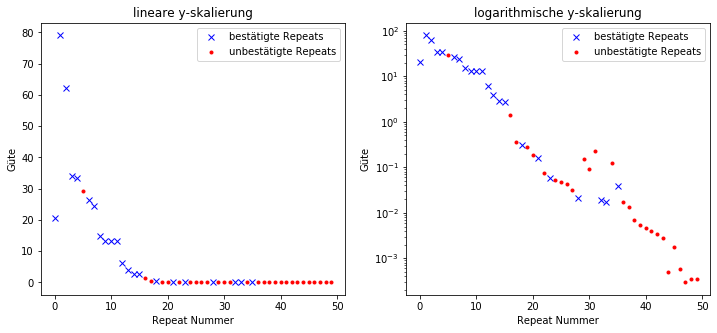

In [11]:
repeats = """558APD 2
1697APD 2
1497APD 2
407APD 2
370APD 2
342APD 2
1004APD 2
47APD 2
401APD 2
342APD 3
342APD 4
462APD 2
2457APD 2
501APD 2
58APD 2
162APD 2
346APD 2
52APD 2
2328APD 2
74APD 2
419APD 2
116APD 2
1160APD 2
175APD 2
388APD 2
339APD 2
1554APD 2
2075APD 2
432APD 2
694APD 2
873APD 2
1806APD 2
898APD 2
2374APD 2
411APD 2
53APD 2
744APD 2
157APD 2
40APD 2
2443APD 2
1693APD 2
214APD 2
371APD 2
1360APD 2"""
repeats = {r.split()[0]:int(r.split()[1]) for r in repeats.splitlines()}

plt.rcParams['figure.figsize'] = 12, 5
rep = repeats.copy()
"""
for r in ret:
    #print(r.güte)
    #print(r.contig)
    r.contig
güte = [r.güte for r in ret]
my_rep = [r.contig for r in ret]
"""
güte = [0.7587409414577064, 0.6888817430788796, 0.5986332394214818, 1.171811959096185, 1.0730361264080817, 0.8005900097235094, 0.6445870983705554, 0.4852551003306362, 0.47339314516209974, 0.4689091863900693, 0.44595759595530543, 0.31267383246482255, 0.28744409959802186, 0.28222705529833003, 0.21400846126285747, 0.21289053652084614, 0.18604104190283072, 0.18191963301504152, 0.1394926392408755, 0.1410371270814369, 0.0919799617378861, 0.07739145287746341, 0.05410463218348118, 0.04552903261230042, 0.044562916252357296, 0.04430028906267725, 0.03414308799455394, 0.03341316645325924, 0.032941004081694855, 0.030092957761054494, 0.027934326126518808, 0.01720883895472836, 0.020577553794939845, 0.016009174807426713, 0.015723710781948584, 0.013870174380686745, 0.011841068440804209, 0.011847137184898784, 0.010737392059032432, 0.009797656963508034, 0.011576531175558609, 0.008639485963702462, 0.009494672578222977, 0.008513615539960578, 0.006909010918517058, 0.006338102443220935, 0.006226106483153299, 0.007905857969116538, 0.0057334727904673035, 0.005598004950001472]

my_rep = ['157APD', '74APD', '1004APD', '162APD', '370APD', '1497APD', '47APD', '339APD', '52APD', '1697APD', '2328APD', '558APD', '388APD', '2185APD', '419APD', '58APD', '898APD', '465APD', '53APD', '72APD', '159APD', '476APD', '145APD', '224APD', '1769APD', '970APD', '1074APD', '1657APD', '178APD', '108APD', '355APD', '271APD', '271APD', '440APD', '214APD', '58APD', '1693APD', '1224APD', '421APD', '34APD', '34APD', '1016APD', '445APD', '393APD', '175APD', '290APD', '342APD', '342APD', '221APD', '84APD']

güte = ret.güte
my_rep = ret.contig
index = []
index2 = []
for k, c in enumerate(my_rep):
    if c in rep:
        index += [k]
        rep[c] -= 1
        if rep[c] == 1:
            rep.pop(c)
    else:
        index2 += [k]
güte1 = [güte[i] for i in index]
güte2 = [güte[i] for i in index2]
plt.subplot(1,2,1)
plt.plot(index,güte1,'xb')
plt.plot(index2,güte2,'.r')
#plt.plot([0,50],[0.35,0.35],':')
#plt.plot([0,50],[1/9,1/9],':')
plt.xlabel('Repeat Nummer')
plt.ylabel('Güte')
#plt.xlim([-1,50])
#plt.ylim([0,1.2])
plt.legend(['bestätigte Repeats','unbestätigte Repeats','0.35','0.11'])
plt.title('lineare y-skalierung')

plt.subplot(1,2,2)
plt.plot(index,güte1,'xb')
plt.plot(index2,güte2,'.r')
#plt.plot([0,50],[0.35,0.35],':')
#plt.plot([0,50],[1/9,1/9],':')
plt.xlabel('Repeat Nummer')
plt.ylabel('Güte')
#plt.xlim([-1,50])
plt.yscale('log')
plt.legend(['bestätigte Repeats','unbestätigte Repeats','0.35','0.11'])
plt.title('logarithmische y-skalierung')
len(index)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 18]

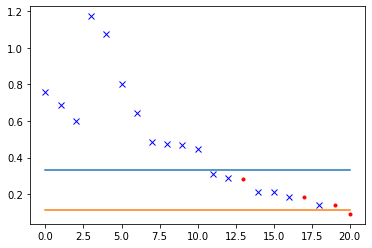

In [93]:
rep = repeats.copy()
for r in ret:
    #print(r.güte)
    #print(r.contig)
    r.contig
güte = [r.güte for r in ret]
my_rep = [r.contig for r in ret]
index = []
index2 = []
for k, c in enumerate(my_rep):
    if k > 20:
        break
    if c in rep:
        index += [k]
        rep[c] -= 1
        if rep[c] == 1:
            rep.pop(c)
    else:
        index2 += [k]
güte1 = [güte[i] for i in index]
güte2 = [güte[i] for i in index2]
plt.plot(index,güte1,'xb')
plt.plot(index2,güte2,'.r')
plt.plot([0,20],[1/3,1/3])
plt.plot([0,20],[1/9,1/9])
#plt.yscale('log')
index

In [41]:
file = open('my_apd200.lst')
fehler = coll.Counter(file)
print('Verteilung der Dopplungen der Constraints')
for key, value in sorted(coll.Counter(fehler.values()).items()):
    print('%2d:%7d'%(key,value))

Verteilung der Dopplungen der Constraints
 1: 114326
 2:   2873
 3:    460
 4:    108
 5:     36
 6:     14
 7:      3
 8:      3
 9:      1
11:      1
13:      1


In [310]:
data = read_file('my_apd199.lst')
r = coll.Counter()
rr = coll.defaultdict(set)
paars = set()
constraints = 0

data = connected(data)
#data = [[a,b,d] for a,b,d in data if d<20000]
contigs = set()
for a,b,d in data:
    contigs |= {a,b}
    constraints += 1
    paars.add(frozenset({a,b}))
    r[a] += 1
    r[b] += 1
    rr[a].add(b)
    rr[b].add(a)

rrr = {a: len(rr[a]) for a in rr}

#u = [[] for i in range(10)]
#for t in r:
#    if r[t] < 10:
#        u[r[t]].append(t)
print(len(contigs))
print(constraints)
print(len(paars))
print(constraints/len(paars))
"""
2124
122226
49417
2.473359370257199
"""
o = connected(data)

Es gibt unzusammenhängende Regionen in den Daten
99.86% der Contigs sind in der größten Komponente.
2121
122219
49415
2.473317818476171
Die Daten sind zusammenhängend


([(1, 45), (2, 143), (3, 47), (4, 16), (5, 8)],
 [(1, 40), (2, 96), (3, 46), (4, 36), (5, 15)])

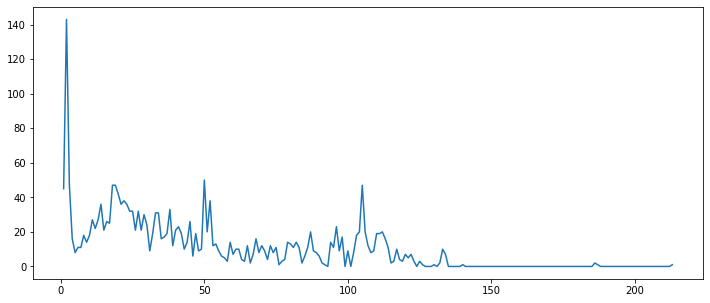

In [318]:
n = max(rrr.values())
x = [0]*n

for i,j in sorted(coll.Counter(rrr.values()).items()):
    x[i-1] = j
plt.plot(range(1,n+1),x)
sorted(coll.Counter(rrr.values()).items())[:5],sorted(coll.Counter(r.values()).items())[:5]

In [312]:
data = read_file('my_apd200.lst')

In [109]:
data2 = [(a,b,d) for (a,b,d) in data if rrr[a]>5 and rrr[b]>5]

In [110]:
connected(data2)

Die Daten sind zusammenhängend


[('1001APD_0', '1001APD_0', 28483.0),
 ('1001APD_0', '100APD_0', 53815.0),
 ('1001APD_0', '1046APD_0', 151293.0),
 ('1001APD_0', '10APD_0', 13985.0),
 ('1001APD_0', '10APD_0', 14118.0),
 ('1001APD_0', '10APD_0', 14260.0),
 ('1001APD_0', '10APD_0', 14387.0),
 ('1001APD_0', '10APD_0', 14443.0),
 ('1001APD_0', '10APD_0', 14522.0),
 ('1001APD_0', '10APD_0', 14528.0),
 ('1001APD_0', '10APD_0', 14547.0),
 ('1001APD_0', '10APD_0', 14997.0),
 ('1001APD_0', '1130APD_0', 126367.0),
 ('1001APD_0', '1133APD_0', 135464.0),
 ('1001APD_0', '1298APD_0', -10013.0),
 ('1001APD_0', '1298APD_0', -10058.0),
 ('1001APD_0', '1298APD_0', -10190.0),
 ('1001APD_0', '1298APD_0', -10202.0),
 ('1001APD_0', '1331APD_0', 38824.0),
 ('1001APD_0', '137APD_0', -33662.0),
 ('1001APD_0', '1418APD_0', 19558.0),
 ('1001APD_0', '1418APD_0', 19724.0),
 ('1001APD_0', '1418APD_0', 19769.0),
 ('1001APD_0', '1488APD_0', 25744.0),
 ('1001APD_0', '1488APD_0', 26084.0),
 ('1001APD_0', '1496APD_0', 10721.0),
 ('1001APD_0', '1496APD_

In [88]:
data

[['1000APD_0', '394APD_0', -2284.634539067446],
 ['1001APD_0', '1001APD_0', 28483.0],
 ['1001APD_0', '100APD_0', 53815.0],
 ['1001APD_0', '1046APD_0', 151293.0],
 ['1001APD_0', '10APD_0', 13985.0],
 ['1001APD_0', '10APD_0', 14118.0],
 ['1001APD_0', '10APD_0', 14260.0],
 ['1001APD_0', '10APD_0', 14387.0],
 ['1001APD_0', '10APD_0', 14443.0],
 ['1001APD_0', '10APD_0', 14522.0],
 ['1001APD_0', '10APD_0', 14528.0],
 ['1001APD_0', '10APD_0', 14547.0],
 ['1001APD_0', '10APD_0', 14997.0],
 ['1001APD_0', '1130APD_0', 126367.0],
 ['1001APD_0', '1133APD_0', 135464.0],
 ['1001APD_0', '1298APD_0', -10013.0],
 ['1001APD_0', '1298APD_0', -10058.0],
 ['1001APD_0', '1298APD_0', -10190.0],
 ['1001APD_0', '1298APD_0', -10202.0],
 ['1001APD_0', '1331APD_0', 38824.0],
 ['1001APD_0', '137APD_0', -33662.0],
 ['1001APD_0', '1418APD_0', 19558.0],
 ['1001APD_0', '1418APD_0', 19724.0],
 ['1001APD_0', '1418APD_0', 19769.0],
 ['1001APD_0', '1488APD_0', 25744.0],
 ['1001APD_0', '1488APD_0', 26084.0],
 ['1001APD_0',

[(1, 40), (2, 98), (3, 46), (4, 36), (5, 15), (6, 13), (7, 2), (8, 7), (9, 3), (10, 4), (11, 5), (12, 3), (13, 4), (14, 4), (15, 3), (16, 7), (17, 5), (18, 7), (19, 6), (20, 5), (21, 4), (22, 4), (23, 8), (24, 3), (25, 10), (26, 5), (27, 3), (28, 2), (29, 4), (30, 5), (31, 6), (32, 2), (34, 7), (35, 7), (36, 3), (37, 6), (38, 9), (39, 7), (40, 8), (41, 6), (42, 7), (43, 9), (44, 10), (45, 9), (46, 7), (47, 5), (48, 9), (49, 8), (50, 7), (51, 12), (52, 12), (53, 7), (54, 15), (55, 10), (56, 8), (57, 8), (58, 15), (59, 10), (60, 6), (61, 6), (62, 8), (63, 6), (64, 16), (65, 6), (66, 14), (67, 6), (68, 10), (69, 13), (70, 7), (71, 8), (72, 8), (73, 9), (74, 12), (75, 4), (76, 10), (77, 9), (78, 12), (79, 10), (80, 7), (81, 10), (82, 21), (83, 7), (84, 9), (85, 6), (86, 13), (87, 8), (88, 4), (89, 14), (90, 14), (91, 9), (92, 7), (93, 7), (94, 7), (95, 12), (96, 16), (97, 10), (98, 14), (99, 9), (100, 14), (101, 13), (102, 12), (103, 12), (104, 12), (105, 2), (106, 14), (107, 6), (108, 12)

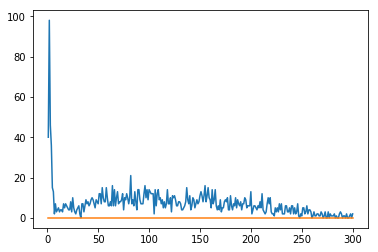

In [102]:
print(sorted(coll.Counter(r.values()).items()))
x = [0]*500
for i,j in sorted(coll.Counter(r.values()).items()):
    x[i-1] = j
plt.plot(range(1,301),x[:300])
plt.plot([1,300],[0,0])

In [59]:
def ordne_Daten_Lösung_zu(position, pre_data):
    i = 0
    fehler = 0
    menge_fehler = set()
    abweichung = 0
    fehl_counter = coll.Counter()
    xxx  = coll.Counter()
    data = []
    yyy = set()
    for a, b, dist in pre_data:
        
        i+=1
        yyy |= {a,b}
        if a not in position:
            fehler += 1
            menge_fehler |= {a}
            fehl_counter[a] += 1
        if b not in position:
            fehler += 1
            menge_fehler |= {b}
            fehl_counter[b] += 1
            continue
        xxx[b] += 1
        if a not in position:
            continue
        xxx[a] += 1
        m = min(
            ([a+'_'+str(i_a),b+'_'+str(i_b),abs(b_i-a_i-dist)]
            for i_a, a_i in enumerate(position[a])
            for i_b, b_i in enumerate(position[b])),
            key = lambda x: x[2]
        )
        abweichung += m[2]
        data.append(m[:2] + [dist])
        i+=1

    print('LP-Wert', abweichung/i)
    print('Anzahl der abgedeckten Constraints', i)
    print('Anzahl der nicht abgedeckten Constraints', fehler)
    #print(menge_fehler)
    #print(fehl_counter)
    print('Anzahl aller fehlenden Contigs', len(fehl_counter))
    #print(xxx)
    print('Anzahl aller vorhandenen Contigs', len(xxx))
    print(len(position))
    zzz = [x for x in position if x not in yyy]
    #print(zzz)
    print('Anzahl aller zusätzlichen Contigs', len(zzz))
    return data
def read_position(datei, ending = True):
    f = open(datei)
    
    position = {}
    contig_repeat = coll.defaultdict(list)
    
    for line in f:
        if ending:
            contig, pos = line.split()
            repeat = contig + '_' + str(len(contig_repeat[contig]))
        else:
            repeat, pos = line.split()
            contig = contig_name(repeat)
        
        position[repeat] = float(pos)
        contig_repeat[contig].append(repeat)
        
    return position, contig_repeat

def read_position_list(datei):
    f = open(datei)
    
    position = coll.defaultdict(list)
    
    for line in f:
        contig, pos = line.split()
        position[contig].append(float(pos))
        
    return position

In [67]:


def bewerte_lösung():
    position, _ = read_position('apdsolution_coords.lst')
    data = read_file('my_apd200.lst', '')
    #umsortieren(data, contig_repeat, position)
    print('AAAA', len(position))
    data = ordne_Daten_Lösung_zu(position, data)
    
    fehler = coll.defaultdict(list)
    for bedingung in data:
        a, b, dist = bedingung

        m = min(
            (
                (b_i-a_i-dist, -b_i+a_i+dist, abs(b_i-a_i-dist))
                for a_i in position[a[:-2]]
                for b_i in position[b[:-2]]
            ),
            key = lambda x:x[-1]
        )
        
        fehler[a].append(m[0])
        fehler[b].append(m[1])
        
    min1 = min(position.values())
    max1 = max(position.values())
    print(min1,max1)
    for c in position:
        if position[c] == min1:
            print('min1',c)
        if position[c] == max1:
            print('max1',c)
    #repeat, gruppe1, gruppe2 = get_repeat(fehler,500,0)

   # contig = repeat[:repeat.rfind('_')]
    #new_contig = contig +'_'+ str(len(contig_repeat[contig]))
    #contig_repeat[contig].append(new_contig)
   # print(repeat)
    #umsortieren(data, contig_repeat, position, model, contigs, bedingungen)

bewerte_lösung()

AAAA 2010
LP-Wert 0.0
Anzahl der abgedeckten Constraints 122226
Anzahl der nicht abgedeckten Constraints 244452
Anzahl aller fehlenden Contigs 2124
Anzahl aller vorhandenen Contigs 0
2010
Anzahl aller zusätzlichen Contigs 2010
0.0 4899601.0
min1 2345APD_0
max1 2080APD_0


In [30]:
print('repeats der Lösung')
sol = {}
f = open('apdsolution_coords.lst')
z = 0
for line in f:
    a, p = line.split()
    p = int(p)
    if a in sol:
        z += 1
        sol[a].append(p)
        print(a, len(sol[a]))
        
        continue
    sol[a] = [p]
    

repeats der Lösung
558APD 2
1697APD 2
1497APD 2
407APD 2
370APD 2
342APD 2
1004APD 2
47APD 2
401APD 2
342APD 3
342APD 4
462APD 2
2457APD 2
501APD 2
58APD 2
162APD 2
346APD 2
52APD 2
2328APD 2
74APD 2
419APD 2
116APD 2
1160APD 2
175APD 2
388APD 2
339APD 2
1554APD 2
2075APD 2
432APD 2
694APD 2
873APD 2
1806APD 2
898APD 2
2374APD 2
411APD 2
53APD 2
744APD 2
157APD 2
40APD 2
2443APD 2
1693APD 2
214APD 2
371APD 2
1360APD 2


[4899601]

In [41]:
contig_len = get_contig_lengths(open('APDContigs.len'))
print(max(max(sol.values())),min(min(sol.values())))
for c in sol:
    if max(sol[c])>4890000:
        print(max(sol[c])+contig_len[c])

4899601 0
4904281
4893524
4895087
4896805
4898398
4899615
4898887
4895758


In [56]:
cP.run("verbessere_loop('my_apd200.lst', 'out.lst' )",sort = 1)

Es gibt unzusammenhängende Regionen in den Daten
99.86% der Contigs sind in der größten Komponente.
Optimize a model with 244438 rows, 124340 columns and 732314 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [8e-06, 8e-06]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 3e+05]

Concurrent LP optimizer: dual simplex and barrier
Showing barrier log only...

Presolve removed 546 rows and 296 columns
Presolve time: 1.64s
Presolved: 243892 rows, 124044 columns, 731676 nonzeros

Ordering time: 0.00s

Barrier statistics:
 Dense cols : 1287
 AA' NZ     : 4.225e+06
 Factor NZ  : 6.490e+06 (roughly 200 MBytes of memory)
 Factor Ops : 9.226e+08 (roughly 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   7.48224503e+05  3.71975307e+01  7.50e+05 0.00e+00  7.47e+04     5s
   1   7.58552025e+05 -2.83538930e+04  2.69e-10 1.01e-02

Optimal objective 2.03058424e+03

Crossover log...

    2348 DPushes remaining with DInf 1.7043520e-03                61s
       0 DPushes remaining with DInf 1.6323158e-03                63s

    3212 PPushes remaining with PInf 6.6813082e-06                63s
       0 PPushes remaining with PInf 0.0000000e+00                64s

  Push phase complete: Pinf 0.0000000e+00, Dinf 4.8233090e-03     64s

Iteration    Objective       Primal Inf.    Dual Inf.      Time
    5493    2.0305842e+03   0.000000e+00   4.823309e-03     64s
    5805    2.0305842e+03   0.000000e+00   0.000000e+00     65s
    5805    2.0305842e+03   0.000000e+00   0.000000e+00     66s

Solved with barrier
Solved in 5805 iterations and 65.68 seconds
Optimal objective  2.030584239e+03
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 0

güte 26.557459860472346
gruppe1 Gruppe(min=-597.0, max=237.0, median=-41.0, mean=-49.88217680700758, std=114.46723557332075, anzahl=298)
gruppe2 Gruppe(min=20599.0, max=2306

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline  

In [74]:
pos = sorted(position3.items(), key = lambda x: x[1])
contig_len = get_contig_lengths(open('APDContigs.len'))

NameError: name 'position3' is not defined

In [75]:
x_werte = [(contig, start, start+contig_len[contig_name(contig)]) for contig, start in pos]
constraints = {frozenset({a,b}) for a, b, _ in data}

NameError: name 'pos' is not defined

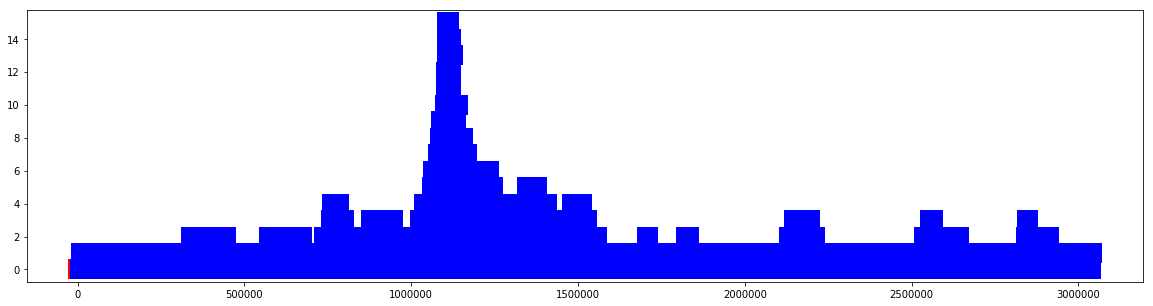

In [84]:
plt.rcParams['figure.figsize'] = 20, 5
y_frei = coll.defaultdict(int)
c, _ = pos[0]
for contig, x1, x2 in x_werte:
    y = 0
    while y_frei[y] > x1:
        y += 1
    if frozenset({contig, c}) in constraints or c == contig:
        plt.plot([x1,x2],[y,y],linewidth = 20, color = 'r')
    else:
        plt.plot([x1,x2],[y,y],linewidth = 20, color = 'b')
    y_frei[y] = x2

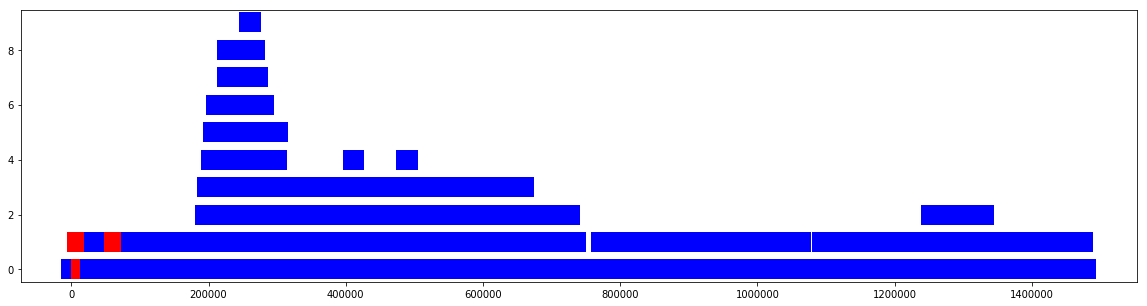

In [126]:
plt.rcParams['figure.figsize'] = 20, 5
y_frei = coll.defaultdict(int)
c, _ = pos[1]
for contig, x1, x2 in x_werte:
    y = 0
    while y_frei[y] > x1:
        y += 1
    if frozenset({contig, c}) in constraints or c == contig:
        plt.plot([x1,x2],[y,y],linewidth = 20, color = 'r')
    else:
        plt.plot([x1,x2],[y,y],linewidth = 20, color = 'b')
    y_frei[y] = x2

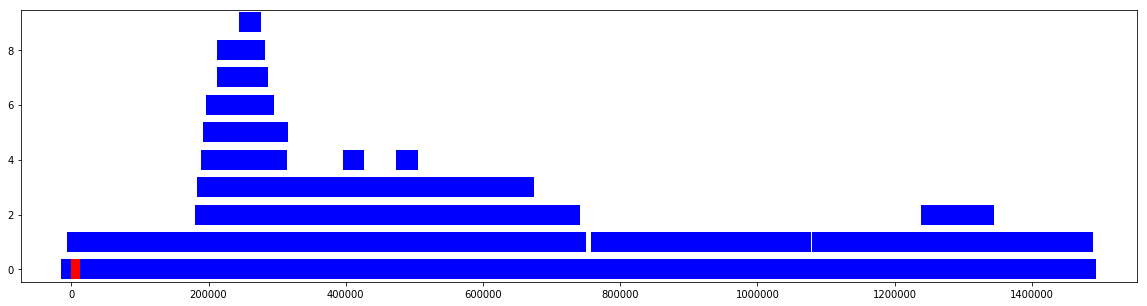

In [128]:
plt.rcParams['figure.figsize'] = 20, 5
y_frei = coll.defaultdict(int)
c, _ = pos[2]
for contig, x1, x2 in x_werte:
    y = 0
    while y_frei[y] > x1:
        y += 1
    if frozenset({contig, c}) in constraints or c == contig:
        plt.plot([x1,x2],[y,y],linewidth = 20, color = 'r')
    else:
        plt.plot([x1,x2],[y,y],linewidth = 20, color = 'b')
    y_frei[y] = x2

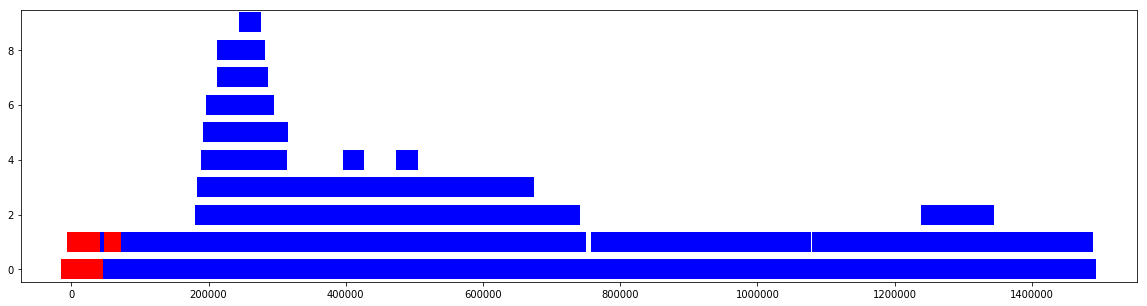

In [127]:
plt.rcParams['figure.figsize'] = 20, 5
y_frei = coll.defaultdict(int)
c, _ = pos[3]
for contig, x1, x2 in x_werte:
    y = 0
    while y_frei[y] > x1:
        y += 1
    if frozenset({contig, c}) in constraints or c == contig:
        plt.plot([x1,x2],[y,y],linewidth = 20, color = 'r')
    else:
        plt.plot([x1,x2],[y,y],linewidth = 20, color = 'b')
    y_frei[y] = x2

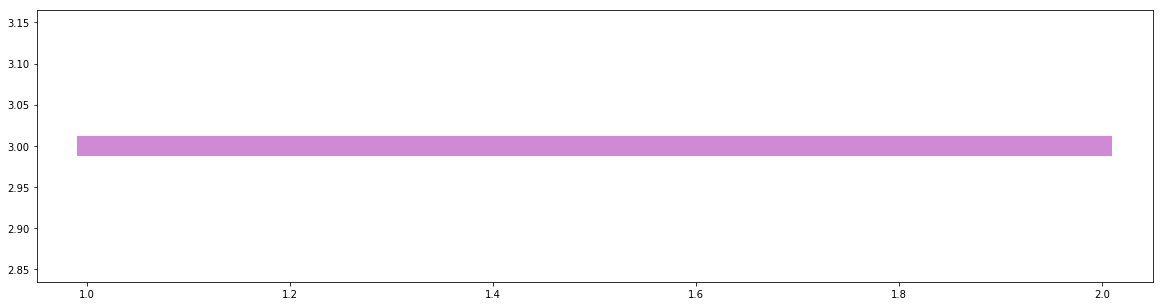

In [79]:
plt.plot([1,2],[3,3],linewidth = 20, color = '#'+hex(np.random.randint(16**6))[2:])


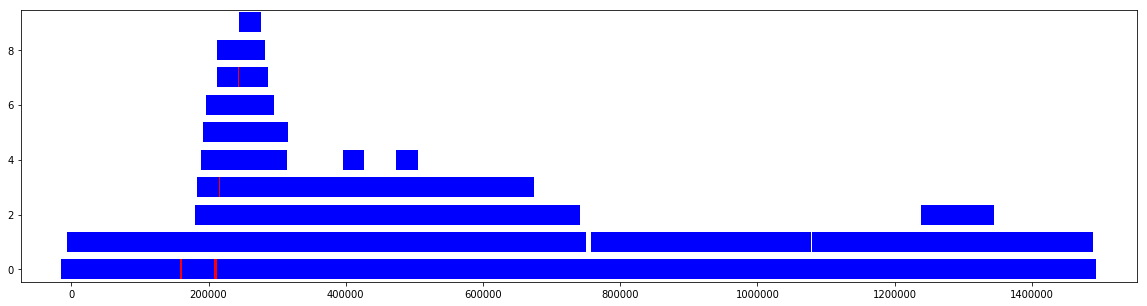

In [131]:
plt.rcParams['figure.figsize'] = 20, 5
y_frei = coll.defaultdict(int)
c, _ = pos[120]
for contig, x1, x2 in x_werte:
    y = 0
    while y_frei[y] > x1:
        y += 1
    if frozenset({contig, c}) in constraints or c == contig:
        plt.plot([x1,x2],[y,y],linewidth = 20, color = 'r')
    else:
        plt.plot([x1,x2],[y,y],linewidth = 20, color = 'b')
    y_frei[y] = x2

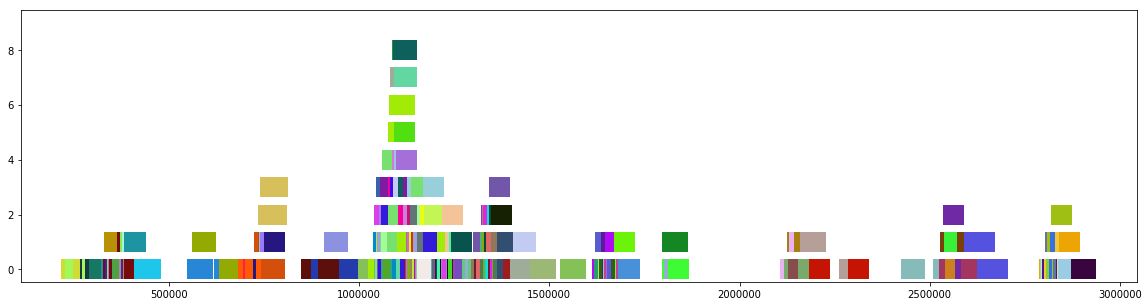

In [113]:
plt.rcParams['figure.figsize'] = 20, 5
y_frei = coll.defaultdict(int)
for contig, x1, x2 in x_werte:
    y = 0
    while y_frei[y] > x1:
        y += 1
    name = contig_name(contig)
    if name in m:
        plt.plot([x1,x2],[y,y],linewidth = 20, color = m[name])
    else:
       # plt.plot([x1,x2],[y,y],linewidth = 20, color = 'k')
        continue
    y_frei[y] = x2

In [36]:
import re

In [37]:
ss = s.splitlines()

In [75]:
sss = [k for k in ss if k and k[0] not in '\t PSCIBsano' and k[:6] not in ['Orderi','Optimi']]
i = 0
for k in sss:
    if k[0] == 'D':
        i +=1
        print()
        print()
        print(i)
    print(k)
i

Es gibt unzusammenhängende Regionen in den Daten
99.86% der Contigs sind in der größten Komponente.
Optimal objective 2.05062193e+03
Optimal objective  2.050621934e+03
max 3035885.125906179
Anzahl der Änderungen: 0
güte 27.35310208953467
gruppe1 Gruppe(min=-32.00000000023283, max=1537.0, median=323.99999999976717, mean=316.5424187960223, std=213.9834439438456, anzahl=207)
gruppe2 Gruppe(min=-12564.000000000233, max=-11401.000000000233, median=-11783.000000000233, mean=-11821.715332287691, std=207.29238681527116, anzahl=205)
rest 5
Anzahl der Änderungen: 205


1
Die Daten sind zusammenhängend
Optimal objective 2.03058424e+03
Optimal objective  2.030584239e+03
max 3036008.7495867116
Anzahl der Änderungen: 0
güte 26.557459860472346
gruppe1 Gruppe(min=-597.0, max=237.0, median=-41.0, mean=-49.88217680700758, std=114.46723557332075, anzahl=298)
gruppe2 Gruppe(min=20599.0, max=23067.0, median=22324.0, mean=22391.53894401743, std=213.5255717748388, anzahl=187)
rest 13
Anzahl der Änderungen: 1

Optimal objective 5.81814309e+02
Optimal objective  5.818143073e+02
max 3036808.8549175262
Anzahl der Änderungen: 9
güte 0.636726465797066
gruppe1 Gruppe(min=-76.00000000046566, max=259.0, median=0.0, mean=9.283025258876537, std=49.73805665444292, anzahl=71)
gruppe2 Gruppe(min=-3978.0, max=-1922.0000000004657, median=-2787.5395737779327, mean=-2837.011306793961, std=620.7973346637468, anzahl=7)
rest 1
Anzahl der Änderungen: 7


173
Die Daten sind zusammenhängend
Optimal objective 5.80315742e+02
Optimal objective  5.803157423e+02
max 3036772.894121678
Anzahl der Änderungen: 2
güte 0.6625713624861459
gruppe1 Gruppe(min=-267.3646544206422, max=523.6353455793578, median=3.6353455793578178, mean=14.108312846582555, std=92.61898342593669, anzahl=80)
gruppe2 Gruppe(min=-3234.0, max=-2571.0, median=-2593.0, mean=-2687.441994751704, std=223.9962638544092, anzahl=7)
rest 8
Anzahl der Änderungen: 15


174
Die Daten sind zusammenhängend
Optimal objective 5.80052699e+02
Optimal objective  5.8005269

277

In [85]:
s = ss.splitlines()

In [86]:
sss = [k for k in s if k and k[:2] == 'gü']
nn = [float(k[5:]) for k in sss]
for n in enumerate(nn):
    print(n)

(0, 27.35310208953467)
(1, 26.557459860472346)
(2, 19.577077585360986)
(3, 19.305374902203308)
(4, 19.016531660977712)
(5, 18.881193605617916)
(6, 18.417342023627445)
(7, 18.075714923716735)
(8, 17.539815626918955)
(9, 17.53898775681898)
(10, 17.491059384928537)
(11, 17.328743809651368)
(12, 17.107823939953562)
(13, 15.996612572567415)
(14, 15.596349093592686)
(15, 13.966881229367669)
(16, 13.47490449669213)
(17, 6.437463200531246)
(18, 6.187626352199974)
(19, 5.94246787171533)
(20, 5.743758897214901)
(21, 5.186814634407762)
(22, 4.000802557200021)
(23, 3.942738952057959)
(24, 3.992600074515826)
(25, 3.942743034530595)
(26, 4.061406886578207)
(27, 3.94589626170611)
(28, 3.9359971067153467)
(29, 4.068265539488999)
(30, 4.065052637440388)
(31, 4.1866147022852465)
(32, 3.9086823761951224)
(33, 4.003930763155172)
(34, 3.840800666981145)
(35, 3.840826783758694)
(36, 3.840831148256628)
(37, 3.8318810602121993)
(38, 3.769905502733743)
(39, 3.7521958042576973)
(40, 3.741156324305339)
(41, 3.70

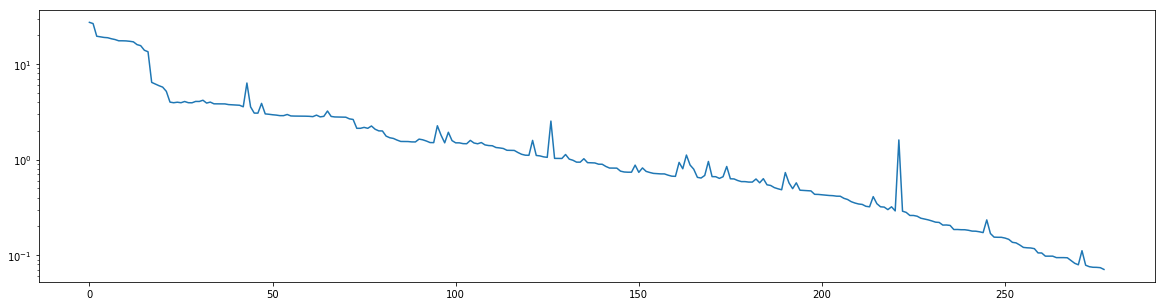

In [80]:
plt.plot(nn)
plt.yscale('log')

([<matplotlib.axis.XTick at 0x7f5c2b862e80>,
 <a list of 11 Text xticklabel objects>)

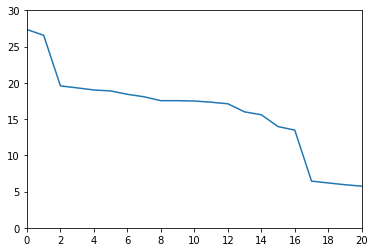

In [30]:
s = """(0, 27.35310208953467)
(1, 26.557459860472346)
(2, 19.577077585360986)
(3, 19.305374902203308)
(4, 19.016531660977712)
(5, 18.881193605617916)
(6, 18.417342023627445)
(7, 18.075714923716735)
(8, 17.539815626918955)
(9, 17.53898775681898)
(10, 17.491059384928537)
(11, 17.328743809651368)
(12, 17.107823939953562)
(13, 15.996612572567415)
(14, 15.596349093592686)
(15, 13.966881229367669)
(16, 13.47490449669213)
(17, 6.437463200531246)
(18, 6.187626352199974)
(19, 5.94246787171533)
(20, 5.743758897214901)
(21, 5.186814634407762)
(22, 4.000802557200021)
(23, 3.942738952057959)
(24, 3.992600074515826)
(25, 3.942743034530595)
(26, 4.061406886578207)
(27, 3.94589626170611)
(28, 3.9359971067153467)
(29, 4.068265539488999)
(30, 4.065052637440388)
(31, 4.1866147022852465)
(32, 3.9086823761951224)
(33, 4.003930763155172)
(34, 3.840800666981145)
(35, 3.840826783758694)
(36, 3.840831148256628)
(37, 3.8318810602121993)
(38, 3.769905502733743)
(39, 3.7521958042576973)
(40, 3.741156324305339)
(41, 3.709946355255372)
(42, 3.5755755657735966)
(43, 6.339743778698787)
(44, 3.569395005870096)
(45, 3.0713854316903855)
(46, 3.067920377982026)
(47, 3.8814441968070645)
(48, 3.0125046874284833)
(49, 2.9860907245124246)
(50, 2.951841094319695)"""
x = [float(x.split(' ')[1][:-1]) for x in s.splitlines()]
plt.plot(x[:21])
plt.ylim([0,30])
plt.xlim([0,20])
plt.xticks(range(0,21,2))

In [111]:
m = { 
    contig_name(contig): '#{:06x}'.format(np.random.randint(16**6)) 
    for contig in position3 if contig[-1] != '0'
}
m

{'1456APD': '#f5c398',
 '307APD': '#d54f0c',
 '1474APD': '#5bf08b',
 '106APD': '#1ec6ec',
 '466APD': '#cedc34',
 '609APD': '#243bae',
 '735APD': '#4ea144',
 '58APD': '#2787d6',
 '1015APD': '#a87afb',
 '194APD': '#9acce4',
 '2088APD': '#a2f859',
 '2200APD': '#2c8e3e',
 '34APD': '#4891d9',
 '157APD': '#167862',
 '778APD': '#62c782',
 '501APD': '#a2eb07',
 '1444APD': '#8234d7',
 '271APD': '#341bd9',
 '834APD': '#52df12',
 '2369APD': '#001038',
 '1497APD': '#b00cf4',
 '1746APD': '#0b053d',
 '565APD': '#ff1e4f',
 '1004APD': '#81f12d',
 '356APD': '#2b261a',
 '1368APD': '#6d1c2e',
 '590APD': '#8eb2cb',
 '1711APD': '#97d0db',
 '1748APD': '#3863a9',
 '1382APD': '#2341e1',
 '693APD': '#148724',
 '2203APD': '#744dbf',
 '464APD': '#4c26a8',
 '2073APD': '#84a912',
 '729APD': '#c0d501',
 '268APD': '#3efc33',
 '78APD': '#a49740',
 '145APD': '#da40e5',
 '1445APD': '#ab8c89',
 '1910APD': '#497c57',
 '342APD': '#77e06e',
 '230APD': '#a56fd9',
 '1986APD': '#abf6db',
 '1224APD': '#ca80db',
 '74APD': '#9bb

In [194]:
position

defaultdict(list,
            {'175APD': [4513984.0, 4477669.0],
             '452APD': [829836.0],
             '1073APD': [1009321.0],
             '288APD': [3763922.0],
             '479APD': [4205509.0],
             '523APD': [1875920.0],
             '100APD': [4096135.0],
             '1317APD': [165447.0],
             '330APD': [4149720.0],
             '501APD': [1298463.0, 1353233.0],
             '476APD': [1857823.0],
             '376APD': [916117.0],
             '353APD': [4470733.0],
             '1638APD': [4490075.0],
             '189APD': [558402.0],
             '2077APD': [990167.0],
             '2078APD': [3398364.0],
             '577APD': [19100.0],
             '151APD': [527698.0],
             '25APD': [4312167.0],
             '40APD': [1428702.0, 1960775.0],
             '1769APD': [1245653.0],
             '39APD': [4238766.0],
             '75APD': [775169.0],
             '849APD': [2763052.0],
             '430APD': [2789392.0],
             '238APD

In [202]:
#data = read_file('data1.lst','')
#position, _ = read_position('sol1.lst',False)

position = read_position_list('apdsolution_coords.lst')
data = read_file('my_apd200.lst', '')
#umsortieren(data, contig_repeat, position)
data = ordne_Daten_Lösung_zu(position, data)
position = {contig + '_' + str(i): pos 
            for contig in position 
            for (i, pos) in enumerate(position[contig])}

LP-Wert 5135.6464782894745
Anzahl der abgedeckten Constraints 119270
Anzahl der nicht abgedeckten Constraints 3094
Anzahl aller fehlenden Contigs 160
Anzahl aller vorhandenen Contigs 1964
Anzahl aller zusätzlichen Contigs 2


In [7]:
data = read_file('data1.lst','')
position, _ = read_position('sol1.lst',False)

In [8]:
a.add_nodes_from(range(5,20))
r = set(a.nodes)
min(a.nodes)

NameError: name 'a' is not defined

In [9]:
a = nx.DiGraph()

NameError: name 'nx' is not defined

In [76]:
def tree_data(root, children):
    import heapq
    positionC = position.copy()
    direct_pred = {}
    heap = [root]
    while heap:
        _, el = heapq.heappop(heap)
        for successor in children[el]:
            direct_pred[successor] = el
            if successor in positionC:
                value = positionC.pop(successor)
                heapq.heappush(heap, (value, successor))
    return direct_pred
direct_pred = tree_data(pos[0], post)
direct_succ = tree_data((-pos[-1][0],pos[-1][1]), pre)


NameError: name 'pos' is not defined

In [10]:
def pfadkontraktion2(graph):
    nodes = set(graph.nodes)
    rename = {node : str(node) for node in nodes}
    while nodes:
        node = nodes.pop()
        if not graph.succ[node]:
            continue
        succ = min(graph.succ[node])
        if (        set(graph.pred[succ]) - {node} <= set(graph.pred[node]) 
                and set(graph.succ[node]) - {succ} <= set(graph.succ[succ])):
            graph = nx.contracted_edge(graph,(node, succ), False)
            rename[node] = rename[node] + '\n' + rename[succ]
            if succ in nodes:
                nodes.remove(succ)
            nodes.add(node)
            nodes |= set(graph.pred[node])
                
    return nx.relabel_nodes(graph, rename)

In [ ]:
"""kantenanzahl = 1
von = 250
bis = 290


data = read_file('data2.lst','')
position, _ = read_position('sol2.lst',False)
data = data2
position = position2
from IPython.display import Image
import networkx as nx

pos = sorted([(value, key) for key, value in position.items()])
intName = {k: i for i, (v, k) in enumerate(pos)}
intName.update({i: k for i, (v, k) in enumerate(pos)})
s = coll.defaultdict(lambda: coll.defaultdict(lambda: (10000000,0)))
p = coll.defaultdict(lambda: coll.defaultdict(lambda: (10000000,0)))
post = {}
pre = {}
#von = -1
#bis = 5200


graph = nx.DiGraph() 
for a, b, dist in data:
    if dist > 14000:
        continue
    if intName[a] == intName[b] == 255:
        print(dist)
    if intName[a] < von or intName[b] < von or intName[a] > bis or intName[b] > bis:
        continue
    real_dist = position[b] - position[a]
    s[a][b] = min(s[a][b],(dist,abs(dist-real_dist)))
    p[b][a] = min(p[b][a],(dist,abs(dist-real_dist)))
    """
    if abs(real_dist - dist) < 2000 and a != b: 
        if position[a] > position[b]:
            a, b, real_dist = b, a, -real_dist
        s[a].add(b)
        p[b].add(a)
    """ 
        
        
       # post.setdefault(a, (real_dist, b))
        #pre.setdefault(b, (real_dist, a))
        #post[a] = min(post[a], (real_dist, b))
        #pre[b] = min(pre[b], (real_dist, a))

 #   elif real_dist - dist > 10000:
 #       if position[a] > position[b]:
  #          a, b, real_dist = b, a, -real_dist
   #     graph.add_edge(intName[a], intName[b], color = 'red')

#    elif 1000 <= abs(real_dist - dist) <= 10000:
 #       if position[a] > position[b]:
  #          a, b, real_dist = b, a, -real_dist
   #     graph.add_edge(intName[a], intName[b], color = 'blue')
    
s = {a: [(s[a][b][0],s[a][b][1],b) for b in s[a]] for a in s}
p = {b: [(p[b][a][0],p[b][a][1],a) for a in p[b]] for b in p}
ss = {a: sorted(s[a])[:kantenanzahl] for a in s}
pp = {b: sorted(p[b])[-kantenanzahl:] for b in p}

for b in pp:
    print(pp[b])
    for _, fehler, a in pp[b]:
        if fehler < 1000:
            color = 'black'
        elif fehler < 10000:
            color = 'blue'
            continue
        else:
            color = 'red'
            continue
        graph.add_edge(intName[a],intName[b],color = color)
for a in ss:
    print(ss[a])
    for _, fehler, b in ss[a]:
        if fehler < 1000:
            color = 'black'
        elif fehler < 10000:
            continue
            color = 'blue'
        else:
            continue
            color = 'red'
        graph.add_edge(intName[a],intName[b],color = color)
#graph = pfadkontraktion2(graph)
"""

In [278]:
kantenanzahl = 20
von = 230
bis = 380


#data = read_file('data2.lst','')
#position, _ = read_position('sol2.lst',False)
data = data2
position = position2
data = u
pos = p
from IPython.display import Image
import networkx as nx

pos = sorted([(value, key) for key, value in position.items()])
intName = {k: i for i, (v, k) in enumerate(pos)}
intName.update({i: k for i, (v, k) in enumerate(pos)})
s = coll.defaultdict(set)
p = coll.defaultdict(set)
post = {}
pre = {}
#von = -1
#bis = 5200


graph = nx.DiGraph() 
for a, b, dist in data:
    if {intName[a], intName[b]} == {255,287}:
        print(a, b, dist)
    if intName[a] < von or intName[b] < von or intName[a] > bis or intName[b] > bis:
        continue
    real_dist = position[b] - position[a]
    if abs(real_dist - dist) < 10000 and a != b:
        if position[a] > position[b]:
            a, b, real_dist = b, a, -real_dist
        s[a].add(b)
        p[b].add(a)
       # post.setdefault(a, (real_dist, b))
        #pre.setdefault(b, (real_dist, a))
        #post[a] = min(post[a], (real_dist, b))
        #pre[b] = min(pre[b], (real_dist, a))

   # elif abs(real_dist - dist) > 10000:
      # # if position[a] > position[b]:
     #   a, b = b, a
     #   if dist <10000:
      #      graph.add_edge(intName[a], intName[b], color = 'red')
      #  elif dist <20000:
      #      graph.add_edge(intName[a], intName[b], color = 'green')
      #  elif dist <30000:
      #      graph.add_edge(intName[a], intName[b], color = 'blue')

   # elif 1000 <= abs(real_dist - dist) <= 10000:
    #    if position[a] > position[b]:
    #        a, b, real_dist = b, a, -real_dist
     #   graph.add_edge(intName[a], intName[b], color = 'blue')

ss = {a: sorted(s[a], key = lambda x: intName[x])[:kantenanzahl] for a in s}
pp = {a: sorted(p[a], key = lambda x: intName[x])[-kantenanzahl:] for a in p}
#print(ss[intName[255]])
for el in pp:
    for pr in pp[el]:
        graph.add_edge(pr,el)
       # graph.add_edge(intName[pr],intName[el])
for el in ss:
    for su in ss[el]:
       # graph.add_edge(intName[el],intName[su])
        graph.add_edge(el,su)
#graph = pfadkontraktion2(graph)


In [279]:

pydot = nx.nx_pydot.to_pydot(graph)

pydot.write_png('t.png')

In [175]:
sorted({1:4,2:3,0:5})

[0, 1, 2]

407APD_0
2394APD_0
694APD_0
491APD_0
2075APD_0
462APD_0


In [133]:
position['58APD_2'],position['58APD_0']


(573055.0, 581456.0)

In [134]:
581456 - 573055

8401

In [137]:
get_contig_lengths(open('APDContigs.len'))['58APD']

8115

In [194]:
pos[255]
for a, b, dist in data:
    if a == '58APD_0' and b == '58APD_0':
        print(a,a,dist)

58APD_0 58APD_0 10849.0
58APD_0 58APD_0 10863.0
58APD_0 58APD_0 10956.0
58APD_0 58APD_0 62960.0
58APD_0 58APD_0 8770.0
58APD_0 58APD_0 8908.0
58APD_0 58APD_0 8948.0
58APD_0 58APD_0 8965.0
58APD_0 58APD_0 8980.0


In [195]:
def fehlerfinden(data, position):
    fehler58 = []
    for i, bedingung in enumerate(data):
        a, b, dist = bedingung
        res_dist = position[b] - position[a]
        if a != '58APD_0' != b:
            continue
        if a == '58APD_0' != b:
            fehler58.append((res_dist - dist, b))
        if a != '58APD_0' == b:
            fehler58.append((dist - res_dist, a))
            
    return fehler58

def extra(gruppe):
    gruppe, contigs  = gruppe
    counter = coll.Counter(contigs)
    # extrahiere Median und Länge der Gruppen und sortiere nach der Länge absteigend
    Gruppe = coll.namedtuple('Gruppe', ['min', 'max', 'median', 'mean', 'std', 'anzahl', 'überdeckung'])
    return Gruppe(
        min = min(gruppe),
        max = max(gruppe),
        median = gruppe[len(gruppe)//2],
        mean = sum(gruppe)/len(gruppe),
        std = np.std(gruppe),
        anzahl = len(gruppe),
        überdeckung = counter[max(counter, key = lambda e:counter[e])]
    )
   
    
def grupp(fehler, min_abstand):
    
    entfernung = lambda x, y: max(y.min - x.max, x.min - y.max)
    calc_güte = ( lambda g1, g2, rest: 
                    g2.anzahl**2
                    * math.log2( entfernung(g1,g2) - min_abstand + 1 )
                    / ( 1 + g2.anzahl + rest ) )
    
    
    
    sorted_fehler = sorted(fehler) 
    # gruppiere sich stützende Daten
    previous = sorted_fehler[0][0]
    current_group = ([],[])
    groups = []
    gruppen_abstand = []
    for current, contig in sorted_fehler:
        if current - previous > min_abstand:
            groups.append(current_group)
            current_group = ([],[])
            gruppen_abstand.append([current - previous, groups[-1], current_group])
        current_group[0].append(current)
        current_group[1].append(contig)
        previous = current
    groups.append(current_group)
    
    gruppen_daten = [extra(g) for g in groups]
    #gruppen_daten.sort(key = lambda x: x.anzahl, reverse=True)
    for g in gruppen_daten:
        if g.anzahl<3 or g.überdeckung < 2:
            continue
        s=''
        for x in zip(['min', 'max', 'median', 'mean', 'std', 'anzahl', 'über'],g):
            if x[0] == 'std' and x[1] <10:
                s += x[0] + '= 10,\t'
                continue
            s += x[0] + '= ' + str(int(x[1])) + ',\t'
        print(s)
  #  print(gruppen_daten)
    max1 , max2 = gruppen_daten[:2]
    güte = calc_güte(max1, max2, len(sorted_fehler) - max1.anzahl - max2.anzahl)
    
    return 


fehler = fehlerfinden(data,position)
grupp(fehler, 100)
print("""

min= -22292,	max= -22292,	median= -22292,	mean= -22292,	std= 10,	anzahl= 1,	über= 1,	
min= -8544,	max= -8272,	median= -8462,	mean= -8439,	std= 62,	anzahl= 15,	über= 4,	
min= -8122,	max= -8122,	median= -8122,	mean= -8122,	std= 10,	anzahl= 1,	über= 1,	
min= -7640,	max= -7494,	median= -7548,	mean= -7553,	std= 30,	anzahl= 18,	über= 1,	
min= -597,	max= -314,	median= -386,	mean= -444,	std= 109,	anzahl= 16,	über= 3,	
min= -113,	max= 159,	median= -16,	mean= -15,	std= 35,	anzahl= 140,	über= 15,	
min= 294,	max= 294,	median= 294,	mean= 294,	std= 10,	anzahl= 1,	über= 1,	
min= 863,	max= 1049,	median= 923,	mean= 931,	std= 46,	anzahl= 13,	über= 7,	
min= 20121,	max= 20121,	median= 20121,	mean= 20121,	std= 10,	anzahl= 1,	über= 1,	
min= 40696,	max= 40696,	median= 40696,	mean= 40696,	std= 10,	anzahl= 1,	über= 1,	
min= 62553,	max= 62646,	median= 62646,	mean= 62599,	std= 46,	anzahl= 2,	über= 1,	
min= 62882,	max= 63046,	median= 62971,	mean= 62968,	std= 27,	anzahl= 107,	über= 4,	
min= 71993,	max= 71999,	median= 71995,	mean= 71995,	std= 10,	anzahl= 3,	über= 1,	

min= -22292,	max= -22292,	median= -22292,	mean= -22292,	std= 10,	anzahl= 1,	über= 1,	
min= -8544,	max= -7494,	median= -7596,	mean= -7961,	std= 437,	anzahl= 34,	über= 6,	
min= -597,	max= 294,	median= -17,	mean= -56,	std= 141,	anzahl= 157,	über= 15,	
min= 863,	max= 1049,	median= 923,	mean= 931,	std= 46,	anzahl= 13,	über= 7,	
min= 20121,	max= 20121,	median= 20121,	mean= 20121,	std= 10,	anzahl= 1,	über= 1,	
min= 40696,	max= 40696,	median= 40696,	mean= 40696,	std= 10,	anzahl= 1,	über= 1,	
min= 62553,	max= 63046,	median= 62970,	mean= 62961,	std= 56,	anzahl= 109,	über= 5,	
min= 71993,	max= 71999,	median= 71995,	mean= 71995,	std= 10,	anzahl= 3,	über= 1,	

min= -22292,	max= -22292,	median= -22292,	mean= -22292,	std= 10,	anzahl= 1,	über= 1,	
min= -8544,	max= -7494,	median= -7596,	mean= -7961,	std= 437,	anzahl= 34,	über= 6,	
min= -597,	max= 1049,	median= -16,	mean= 18,	std= 296,	anzahl= 170,	über= 15,	
min= 20121,	max= 20121,	median= 20121,	mean= 20121,	std= 10,	anzahl= 1,	über= 1,	
min= 40696,	max= 40696,	median= 40696,	mean= 40696,	std= 10,	anzahl= 1,	über= 1,	
min= 62553,	max= 63046,	median= 62970,	mean= 62961,	std= 56,	anzahl= 109,	über= 5,	
min= 71993,	max= 71999,	median= 71995,	mean= 71995,	std= 10,	anzahl= 3,	über= 1,	
""")

min= -8544,	max= -8272,	median= -8462,	mean= -8439,	std= 62,	anzahl= 15,	über= 4,	
min= -597,	max= -314,	median= -386,	mean= -444,	std= 109,	anzahl= 16,	über= 3,	
min= -113,	max= 159,	median= -16,	mean= -15,	std= 35,	anzahl= 140,	über= 15,	
min= 863,	max= 1049,	median= 923,	mean= 931,	std= 46,	anzahl= 13,	über= 7,	
min= 62882,	max= 63046,	median= 62971,	mean= 62968,	std= 27,	anzahl= 107,	über= 4,	







min= -22292,	max= -22292,	median= -22292,	mean= -22292,	std= 10,	anzahl= 1,	über= 1,	
min= -8544,	max= -8272,	median= -8462,	mean= -8439,	std= 62,	anzahl= 15,	über= 4,	
min= -8122,	max= -8122,	median= -8122,	mean= -8122,	std= 10,	anzahl= 1,	über= 1,	
min= -7640,	max= -7494,	median= -7548,	mean= -7553,	std= 30,	anzahl= 18,	über= 1,	
min= -597,	max= -314,	median= -386,	mean= -444,	std= 109,	anzahl= 16,	über= 3,	
min= -113,	max= 159,	median= -16,	mean= -15,	std= 35,	anzahl= 140,	über= 15,	
min= 294,	max= 294,	median= 294,	mean= 294,	std= 10,	anzahl= 1,	über= 1,	
min= 863,	max= 1049,	media

In [116]:
intName

{'2345APD_0': 0,
 '1483APD_0': 1,
 '1395APD_0': 2,
 '1596APD_0': 3,
 '2235APD_0': 4,
 '1534APD_0': 5,
 '546APD_0': 6,
 '577APD_0': 7,
 '998APD_0': 8,
 '209APD_0': 9,
 '1635APD_0': 10,
 '1911APD_0': 11,
 '2109APD_0': 12,
 '996APD_0': 13,
 '1907APD_0': 14,
 '1481APD_0': 15,
 '2113APD_0': 16,
 '1402APD_0': 17,
 '1332APD_0': 18,
 '1067APD_0': 19,
 '225APD_0': 20,
 '1894APD_0': 21,
 '2448APD_0': 22,
 '521APD_0': 23,
 '2319APD_0': 24,
 '1076APD_0': 25,
 '301APD_0': 26,
 '50APD_0': 27,
 '2396APD_0': 28,
 '1980APD_0': 29,
 '958APD_0': 30,
 '2050APD_0': 31,
 '1113APD_0': 32,
 '960APD_0': 33,
 '831APD_0': 34,
 '1877APD_0': 35,
 '1337APD_0': 36,
 '1630APD_0': 37,
 '59APD_0': 38,
 '542APD_0': 39,
 '1631APD_0': 40,
 '176APD_0': 41,
 '567APD_0': 42,
 '776APD_0': 43,
 '86APD_0': 44,
 '71APD_0': 45,
 '1529APD_0': 46,
 '1057APD_0': 47,
 '1472APD_0': 48,
 '1714APD_0': 49,
 '1480APD_0': 50,
 '1400APD_0': 51,
 '2058APD_0': 52,
 '943APD_0': 53,
 '511APD_0': 54,
 '1698APD_0': 55,
 '1903APD_0': 56,
 '1625APD

In [115]:
for c in position:
    if intName[c] == von:
        VON = int(position[c])
    if intName[c] == bis:
        BIS = int(position[c])
        
print('von',VON)
print('bis',BIS)
print('dis',BIS-VON)
#for a, b in X:
#    graph.add_edge(a, b, color = 'red')
pydot = nx.nx_pydot.to_pydot(graph)

pydot.write_png('test.png')

NameError: name 'VON' is not defined

In [184]:
X = {('2060APD_0_0', '14APD_0_0'),
 ('224APD_0_0', '1498APD_0_0'),
 ('393APD_0_0', '574APD_0_0'),
 ('476APD_0_0', '1503APD_0_0'),
 ('849APD_0_0', '1657APD_0_0')}
X = {(intName[a],intName[b]) for a,b in X}

KeyError: '849APD_0_0'

In [ ]:
for e in pydot.get_edges():
    a = e.to_string().split(' -> ')
    a = int(a[0]),int(a[1][:-1])
    if a
    intName[]
    break

517 -> 1438  [color=red];
320 -> 1408  [color=red];
556 -> 705  [color=red];
831 -> 825  [color=red];
1710 -> 1742  [color=red];


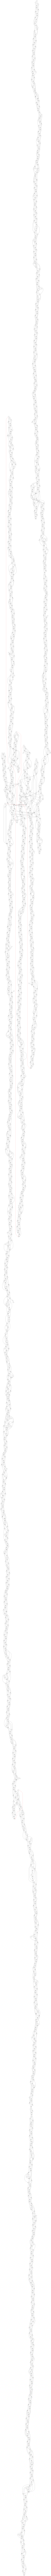

In [16]:
for a, b in X:
    e = pydot.get_edge(str(a), str(b))[0]
    print(e)
    e.set_color('red')
    
pydot.write_png('d.png')
#Image(filename='d.png')

In [260]:
a = 'afsaf'
a.strip('a')
e.get_source()

'574'

In [253]:
e.get_source()
e.get_taillabel()

In [244]:
a = e.to_string().split(' -> ')
a = int(a[0]),int(a[1][:-1])
a

(574, 577)

In [79]:
ipre = {intName[k]: intName[pre[k][1]] for k in pre}
ipre
ipost = {intName[k]: intName[post[k][1]] for k in post}
ipost

{1: 2, 2: 3, 0: 10, 3: 5, 5: 6, 4: 10, 9: 10, 6: 10, 7: 10, 8: 10}

In [70]:
    counter = 0
    post = coll.defaultdict(set)
    pre = coll.defaultdict(set)
    dataX = []
    for a, b, dist in data:
        if a != b and abs(position[b] - position[a] - dist) < 2000:
            counter += 1
            dataX.append([a, b, position[b] - position[a]])
            if position[a] < position[b]:
                post[a].add(b)
                pre[b].add(a)
            elif position[a] > position[b]:
                post[b].add(a)
                pre[a].add(b)
counter

116607

In [46]:
pos = sorted([(value, key) for key, value in position.items()])
intName = {k: i for i, (v, k) in enumerate(pos)}
intName.update({i: k for i, (v, k) in enumerate(pos)})

In [47]:
positionC = position.copy()
import heapq
predirect = {}
heap = [pos[0]]
counter = 0
visit = []
while heap:
    #counter += 1
    #if counter > 100:
    #    break
        
    _, el = heapq.heappop(heap)
    visit.append(el)
    for successor in post[el]:
        predirect[successor] = el
        if successor in positionC:
            value = positionC.pop(successor)
            heapq.heappush(heap, (value, successor))
len(positionC)

575

In [49]:
positionC = position3.copy()
import heapq
predirect = {}
heap = [(-pos[-1][0],pos[-1][1])]
counter = 0
visit = []
while heap:
    _, el = heapq.heappop(heap)
    visit.append(el)
    for successor in pre[el]:
        predirect[successor] = el
        if successor in positionC:
            value = positionC.pop(successor)
            heapq.heappush(heap, (-value, successor))
len(positionC)

460

In [36]:
len(positionC)

537

In [61]:
import networkx as nx

graph = nx.DiGraph()
graph.add_edge(1,2)
nx.nx_pydot.to_pydot(graph).write_png('m.png')

In [165]:
#import tempfile
from IPython.display import Image #,display
import networkx as nx


graph = nx.DiGraph() 
for el in predirect:
    graph.add_edge(intName[predirect[el]],intName[el])
    
def pfadkontraktion(graph, start):
    while len(graph.succ[start]) == 1:
        s = list(graph.succ[start])[0]
        graph = nx.contracted_edge(graph,(start,s),False)
        new_name = str(start) +'\n'+ str(s)
        graph = nx.relabel_nodes(graph, {start : new_name})
        start = new_name
    for s in graph.succ[start]:
        graph = pfadkontraktion(graph, s)
    return graph
graph = pfadkontraktion(graph, 0)    
nx.nx_pydot.to_pydot(graph).write_png('msa.png')
Image(filename='msa.png')

KeyError: '2049APD_0'

In [164]:
from IPython.display import Image #,display
import networkx as nx


graph = nx.DiGraph() 
for el in predirect:
    graph.add_edge(intName[predirect[el]],intName[el])
    
def pfadkontraktion(graph, start):
    while len(graph.succ[start]) == 1:
        s = list(graph.succ[start])[0]
        graph = nx.contracted_edge(graph,(start,s),False)
        new_name = str(start) +'\n'+ str(s)
        graph = nx.relabel_nodes(graph, {start : new_name})
        start = new_name
    for s in graph.succ[start]:
        graph = pfadkontraktion(graph, s)
    return graph
graph = pfadkontraktion(graph, len(pos)-1)    
nx.nx_pydot.to_pydot(graph).write_png('msa.png')
Image(filename='msa.png')

KeyError: '2049APD_0'

In [14]:
kantenanzahl = 2
von = 500
bis = 900


data = data2
position = position2

pos = sorted([(value, key) for key, value in position.items()])
intName = {k: i for i, (v, k) in enumerate(pos)}
intName.update({i: k for i, (v, k) in enumerate(pos)})

d=0
ins=0
rd=0
for a, b, dist in data:
    if intName[a] < von or intName[b] < von or intName[a] > bis or intName[b] > bis:
        continue
    real_dist = position[b] - position[a]
    if abs(real_dist - dist) < 10000 and a != b:
        ins += 1
        if real_dist < 0:
            rd += 1
        if dist < 0:
            d += 1
        if position[a] > position[b]:
            a, b, real_dist = b, a, -real_dist
        s[a].add(b)
        p[b].add(a)
       # post.setdefault(a, (real_dist, b))
        #pre.setdefault(b, (real_dist, a))
        #post[a] = min(post[a], (real_dist, b))
        #pre[b] = min(pre[b], (real_dist, a))

   # elif abs(real_dist - dist) > 10000:
      # # if position[a] > position[b]:
     #   a, b = b, a
     #   if dist <10000:
      #      graph.add_edge(intName[a], intName[b], color = 'red')
      #  elif dist <20000:
      #      graph.add_edge(intName[a], intName[b], color = 'green')
      #  elif dist <30000:
      #      graph.add_edge(intName[a], intName[b], color = 'blue')

   # elif 1000 <= abs(real_dist - dist) <= 10000:
    #    if position[a] > position[b]:
    #        a, b, real_dist = b, a, -real_dist
     #   graph.add_edge(intName[a], intName[b], color = 'blue')
1
#graph = pfadkontraktion2(graph)
ins,d,rd

(16949, 0, 111)

In [36]:
z=set()
for a,b,d in data2:
    if d < 200:
        z.add((a,b))
{ frozenset({a,b}) for a,b in z if (b,a) in z}

{frozenset({'108APD_0', '2213APD_0'}),
 frozenset({'116APD_0', '150APD_0'}),
 frozenset({'445APD_0', '72APD_0'}),
 frozenset({'1262APD_0', '873APD_0'})}

In [210]:
from gurobipy import *
from random import uniform
import itertools as it
import time
import cProfile as cP
import collections as coll
import math
import numpy as np
from IPython.display import Image
import networkx as nx
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline  
plt.rcParams['figure.figsize'] = 12, 5
def contig_name(contig):
    return contig[:contig.rfind('_')]
def read_file(file_name, suffix = '_0'):
    """
    suffix -- wird dem Namen der Contigs angehangen, übergebe suffix = '' wenn der Suffix schon angehangen ist.
    """
    data = []
    with open(file_name) as file:
        for line in file:
            a, b, dist = line.split()
            dist = float(dist)
            data.append([a+suffix, b+suffix, dist])
    return data
def plot():
    x=[]
    l=[]
    for ii in range(20):
        i = 200*2**(ii/3)
        x.append(i)
        Z = {x: gruppiert(z[x], i) for x in z}
        l.append(sum(len(Z[x]) for x in Z) - len(Z))
    plt.plot(x,l,'.')
    plt.plot([1000,1000],[0,5000])
    plt.plot([2000,2000],[0,5000])
    plt.plot([3000,3000],[0,5000])
    plt.plot([4000,4000],[0,5000])
    plt.plot([5000,5000],[0,5000])
    plt.plot([6000,6000],[0,5000])
    plt.plot([7000,7000],[0,5000])
    plt.plot([8000,8000],[0,5000])
    plt.plot([9000,9000],[0,5000])
    plt.plot([10000,10000],[0,5000])
def gruppiert(werte, min_abstand):
    sorted_werte = sorted(werte) 
    # gruppiere sich stützende Daten
    previous = sorted_werte[0]
    current_group = []
    groups = []
    for current in sorted_werte:
        if current - previous > min_abstand:
            groups.append([current_group[len(current_group)//2], len(current_group)])
            current_group = []
        current_group.append(current)
        previous = current
    groups.append([current_group[len(current_group)//2], len(current_group)])
    return groups


data2 = read_file('my_apd199.lst', '')
z = coll.defaultdict(list)
for a,b,d in data2:
    if a>b:
        z[(b,a)].append(-d)
    elif a<b:
        z[(a,b)].append(d)
        
Z = {x: gruppiert(z[x], 500) for x in z}
#sorted([dist,a,b] for (a,b),(dist,gewicht) in Z.items())
print('len z[x] %6d'%sum(len(z[x]) for x in z))
print('len Z[x] %6d'%sum(len(Z[x]) for x in Z))
print('len C    %6d'%len(Z))
print('len Z-C  %6d'%(sum(len(Z[x]) for x in Z) - len(Z)))
print('len z-Z  %6d'%(sum(len(z[x]) for x in z) - sum(len(Z[x]) for x in Z)))

len z[x] 121971
len Z[x]  55429
len C     49218
len Z-C    6211
len z-Z   66542


In [211]:

data3 = [[dist,a,b,gewicht] for (a,b),liste in Z.items() for dist,gewicht in liste]
for da in data3:
    d,a,b,g = da
    if d < 0:
        da[0] = -d
        da[1] = b
        da[2] = a 
        da[3] = g
len(data3)

55429

{'2345APD_0': 0,
 '1483APD_0': 1,
 '1395APD_0': 2,
 '1596APD_0': 3,
 '2235APD_0': 4,
 '1534APD_0': 5,
 '546APD_0': 6,
 '577APD_0': 7,
 '998APD_0': 8,
 '209APD_0': 9,
 '1635APD_0': 10,
 '1911APD_0': 11,
 '2109APD_0': 12,
 '996APD_0': 13,
 '1907APD_0': 14,
 '1481APD_0': 15,
 '2113APD_0': 16,
 '1402APD_0': 17,
 '1332APD_0': 18,
 '1067APD_0': 19,
 '225APD_0': 20,
 '1894APD_0': 21,
 '2448APD_0': 22,
 '521APD_0': 23,
 '2319APD_0': 24,
 '1076APD_0': 25,
 '301APD_0': 26,
 '50APD_0': 27,
 '2396APD_0': 28,
 '1980APD_0': 29,
 '958APD_0': 30,
 '2050APD_0': 31,
 '1113APD_0': 32,
 '960APD_0': 33,
 '831APD_0': 34,
 '1877APD_0': 35,
 '1337APD_0': 36,
 '59APD_0': 37,
 '542APD_0': 38,
 '1631APD_0': 39,
 '176APD_0': 40,
 '567APD_0': 41,
 '776APD_0': 42,
 '86APD_0': 43,
 '71APD_0': 44,
 '1529APD_0': 45,
 '1057APD_0': 46,
 '1472APD_0': 47,
 '1714APD_0': 48,
 '1480APD_0': 49,
 '1400APD_0': 50,
 '2058APD_0': 51,
 '943APD_0': 52,
 '511APD_0': 53,
 '1698APD_0': 54,
 '1903APD_0': 55,
 '1625APD_0': 56,
 '2387APD

In [275]:
X = {'407APD_0','694APD_0','491APD_0','2075APD_1','462APD_1','413APD_0','407APD_1','2394APD_0','491APD_1','2075APD_0','462APD_0'}
X = {'407APD_0','694APD_0','491APD_0','2075APD_0','462APD_0','413APD_0','407APD_0','2394APD_0','491APD_0','2075APD_0','462APD_0'}
Y = {'44APD_0','11APD_0','1783APD_0','407APD_0','2394APD_0','491APD_0','2075APD_0','462APD_0','69APD_0','1022APD_0'}
k = 0
u = []
for d,a,b,g in sorted(data3):
    if a in Y and b in Y:
        k+=1
        if intName[a] == 253:
            print(intName[a],intName[b],int(d)//100,g)
            print(intName[a],intName[b],int(p[b]-p[a])//100)
        u.append([a,b,d])
k

253 273 17 7
253 273 17
253 256 33 6
253 256 33
253 275 33 10
253 275 33
253 276 35 23
253 276 35
253 277 53 12
253 277 53
253 278 62 11
253 278 62


42

In [281]:
intName['407APD_0'],intName['491APD_0']

(253, 256)

In [260]:
u
c = {x for y in u for x in y[:2]}
p = solve_LP(c,u)
p

Optimize a model with 84 rows, 52 columns and 252 nonzeros
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-02, 2e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+02, 2e+04]
Presolve time: 0.01s
Presolved: 84 rows, 52 columns, 252 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.622544e+05   0.000000e+00      0s
      57    4.6524133e+00   0.000000e+00   0.000000e+00      0s

Solved in 57 iterations and 0.02 seconds
Optimal objective  4.652413301e+00


{'1783APD_0': 12826.0,
 '1022APD_0': 19271.0,
 '462APD_0': 16539.0,
 '11APD_0': 6233.0,
 '44APD_0': 0.0,
 '69APD_0': 18401.0,
 '2394APD_0': 14784.028673321265,
 '407APD_0': 13034.028673321265,
 '2075APD_0': 16369.028673321265,
 '491APD_0': 16367.028673321265}

In [266]:

for x in sorted(p,key = lambda k: p[k]):
    print(intName[x],int(p[x])//100)

269 0
270 62
271 128
253 130
273 147
256 163
275 163
276 165
277 184
278 192


In [218]:
def remove_singels(data3):
    contig_counter = coll.Counter([x for d in data3 for x in d[1:3]])
    data4 = [[d,a,b,g] for d,a,b,g in data3 if contig_counter[a]>1 and contig_counter[b]>1]
    for da in data4:
        d,a,b,g = da
        if d < 0:
            da[0] = -d
            da[1] = b
            da[2] = a 
            da[3] = g
    return data4

#data4 = remove_singels(data3)
data4 = data3
len(data4)

55429

In [220]:

data4 = {(d,a,b):g for (d,a,b,g) in data3}
E = coll.defaultdict(list)
for d,a,b in data4:
    E[(a,b)].append(d)
    
succ = coll.defaultdict(set)
pred = coll.defaultdict(set)
for d, a, b in data4:
    succ[a].add(b)
    pred[b].add(a)
succ = dict(succ)
pred = dict(pred)
len(E),len(succ),len(pred)

(50166, 2093, 2100)

In [221]:

def ist_notwendig(a,b,d,succ, pred, E, trans):
    ret = True
    for c in succ[a]&pred[b]:
        for d1,d2 in it.product(E[(a,c)],E[(c,b)]):
            if abs(d1+d2-d) < 500:
                trans[(d1,a,c)] |= trans[(d,a,b)]
                trans[(d2,c,b)] |= trans[(d,a,b)]
                ret = False
    return ret
def data5(data4, succ, pred, E):
    E = deepcopy(E)
    succ = deepcopy(succ)
    pred = deepcopy(pred)
    trans = {k : {k} for k in data4}
    data5 = []
    for d, a, b in sorted(data4, reverse = True):
        if ist_notwendig(a,b,d,succ, pred, E, trans):
            data5.append((d, a, b))
        else:
            E[(a,b)].remove(d)
            if not E[(a,b)]:
                E.pop((a,b))
                succ[a].remove(b)
                pred[b].remove(a)
 #   data5 = {k: (data4[k],  sum(data4[x] for x in trans)) for k in data5}
    return data5, E, succ, pred, trans

data5, E2, succ2, pred2, trans = data5(data4, succ, pred, E)
print(len(data5))

2631


In [222]:
data6 = {k: (data4[k],  sum(data4[x] for x in trans[k])) for k in data5}

In [129]:
len(data6), len(data7)

(2631, 2421)

In [130]:
contig_counter = coll.Counter([x for d in data3 for x in d[1:3]])
len(contig_counter)

2123

In [141]:
data7 = {k: data6[k] for k in data6 if data6[k][0]>1 or data6[k][1]>13}
data8 = connected([[a,b,d] for d,a,b in data7])
len(data8)

Es gibt unzusammenhängende Regionen in den Daten
99.52% der Contigs sind in der größten Komponente.


2416

In [9]:
data6,_ = remove_singels(data5)
data7,_ = remove_singels(data6)
data8,_ = remove_singels(data7)
data9,_ = remove_singels(data8)
data10,_ = remove_singels(data9)
len(data4),len(data5),len(data6),len(data7),len(data8),len(data9),len(data10)
while len(data9) != len(data10):
    data9 = data10
    data10,_ = remove_singels(data10)
    print(len(data10))

2569
2568
2567
2566
2565
2564
2563
2562
2561
2560
2560


In [143]:
len({k: data6[k] for k in data6 if data6[k][1]==1})

91

In [132]:

# for i in range(1000):
#    data.append(['2205APD_0','69APD_0',103069])
# for i in range(100):
#    data.append(['2345APD_0','2080APD_0',4099601.0])
data = data8
data = connected(data)
position = {a for a,_,_ in data} | {b for _,b,_ in data}
contig_repeat = coll.defaultdict(list)
for contig in position:
    contig_repeat[contig_name(contig)].append(contig)

Ret = coll.namedtuple('Ret', ['contig','güte'])
ret = Ret(contig = [], güte = [])
for i in range(1):
    print(str(i) + '. Durchlauf')
    position = solve_LP(position, data)
    print('max', max(position.values()))
    print('sortiere Bedingungen anderen repeats zu')
    umsortieren(data, contig_repeat, position)
    constr_pos = get_constr_pos(data, contig_repeat, position)

    contig, repeats, güte, groups = get_repeat(constr_pos, contig_repeat)
    if güte == 0:
        print(111)
        break
    print(str(len(contig_repeat[contig])) + '. Repeat von '+contig)
    print('alte Positionen:')
    for rep in contig_repeat[contig]:
        print('\t', position[rep])

    new_contig = contig +'_'+ str(len(contig_repeat[contig]))
    contig_repeat[contig].append(new_contig)

    print('neue Positionen:')
    for name, werte in zip(contig_repeat[contig], repeats):
        position[name] = werte.pos
        print('\t', werte.pos)

    print('ordne neuem repeat zu: ')
    umsortieren(data, contig_repeat, position)

    print()
    print()
    #out = 'out' + str(i//10) + '.lst'
    ret.contig.append(contig)
    ret.güte.append(güte)
    #data = connected(data)
    #ret.append(Ret(
     #   contig = contig,
      #  güte = güte,
       # repeats = repeats,
        #constr_pos = constr_pos,
#        pos = position,
 #       rep = contig_repeat,
  #      data = data
   # ))
#position, data = verbessere_loop('my_apd200.lst', 'out.lst' )



Die Daten sind zusammenhängend
0. Durchlauf
max 1394444.30317323
sortiere Bedingungen anderen repeats zu
Anzahl der Änderungen: 0

111


In [118]:
#data = data10
kantenanzahl = 2
#contigs = {x for d in data for x in d[1:]}
#von = -1
#bis = 5200


graph = nx.DiGraph() 
for dist,a, b in data:
    ia = intName[a]
    ib = intName[b]
    if ia < ib:
        graph.add_edge(ia,ib)
    else:
        graph.add_edge(ib,ia,color='red')


NameError: name 'intName' is not defined

In [24]:
pydot = nx.nx_pydot.to_pydot(graph)

pydot.write_png('test2.png')

[(1, 47), (2, 143), (3, 47), (4, 14), (5, 10), (6, 12), (7, 7), (8, 15), (9, 14), (10, 19), (11, 22), (12, 22), (13, 22), (14, 32), (15, 18), (16, 22), (17, 28), (18, 50), (19, 28), (20, 34), (21, 28), (22, 37), (23, 47), (24, 31), (25, 34), (26, 21), (27, 29), (28, 18), (29, 27), (30, 24), (31, 12), (32, 21), (33, 31), (34, 29), (35, 19), (36, 23), (37, 20), (38, 29), (39, 13), (40, 22), (41, 17), (42, 12), (43, 14), (44, 21), (45, 13), (46, 20), (47, 10), (48, 15), (49, 8), (50, 44), (51, 19), (52, 40), (53, 14), (54, 11), (55, 7), (56, 19), (57, 11), (58, 5), (59, 11), (60, 6), (61, 5), (62, 8), (63, 5), (64, 6), (65, 7), (66, 5), (67, 13), (68, 17), (69, 11), (70, 8), (71, 11), (72, 6), (73, 16), (74, 7), (75, 6), (76, 5), (77, 3), (78, 5), (79, 16), (80, 16), (81, 11), (82, 11), (83, 9), (84, 5), (85, 9), (86, 10), (87, 21), (88, 7), (89, 7), (90, 5), (91, 3), (92, 3), (93, 2), (94, 5), (95, 13), (96, 5), (97, 26), (98, 13), (99, 9), (100, 10), (101, 3), (102, 7), (103, 1), (104, 

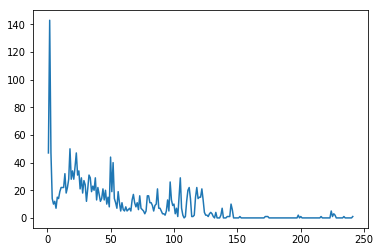

In [145]:
contig_counter = sorted(coll.Counter(coll.Counter([x for d in data3 for x in d[1:]]).values()).items())
n = contig_counter[-1][0]
print(contig_counter)
x = [0]*n
for i,j in contig_counter:
    x[i-1] = j
plt.plot(range(1,n+1),x)

In [137]:
contig_counter.items()

dict_items([('241APD_0', 121), ('2345APD_0', 112), ('1622APD_0', 121), ('1248APD_0', 121), ('1590APD_0', 123), ('832APD_0', 121), ('1494APD_0', 121), ('1395APD_0', 112), ('1586APD_0', 121), ('1942APD_0', 122), ('1596APD_0', 112), ('2122APD_0', 123), ('2235APD_0', 111), ('1534APD_0', 111), ('546APD_0', 111), ('157APD_0', 241), ('577APD_0', 111), ('898APD_0', 128), ('764APD_0', 118), ('684APD_0', 118), ('1701APD_0', 119), ('58APD_0', 216), ('235APD_0', 122), ('216APD_0', 120), ('703APD_0', 100), ('638APD_0', 120), ('998APD_0', 111), ('2296APD_0', 145), ('1439APD_0', 101), ('1390APD_0', 121), ('209APD_0', 113), ('2380APD_0', 121), ('2021APD_0', 174), ('2420APD_0', 101), ('1955APD_0', 123), ('88APD_0', 133), ('986APD_0', 143), ('1543APD_0', 124), ('1635APD_0', 113), ('850APD_0', 173), ('1423APD_0', 101), ('1986APD_0', 172), ('1245APD_0', 99), ('2109APD_0', 113), ('35APD_0', 138), ('996APD_0', 113), ('1481APD_0', 113), ('660APD_0', 200), ('1178APD_0', 152), ('271APD_0', 98), ('1195APD_0', 1

In [92]:
sorted([dist,a,b] for (a,b),liste in Z.items() for dist,gewicht in liste) == sorted([[dist,a,b] for (a,b),liste in Z.items() for dist,gewicht in liste])

True